In [ ]:
# data manipulation
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold


# neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import to_categorical
from tensorflow.keras import backend
import shap

# Tree classifier
import xgboost
from xgboost import XGBClassifier
import scipy.stats as stats
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
sns.set(style='white', context='notebook')

from prettytable import PrettyTable
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
codes = pd.read_csv("/content/drive/MyDrive/Behavioral Annotation Codes.csv")
codes.head(3)

PID QID Degree of Explanation
0  P001  Q1              Succinct
1  P001  Q2              Succinct
2  P001  Q3       Under-explained

In [ ]:
def create_combined_df(pid, exclude_irr):
  """Creates a participants df
     ----------Parameters----------
     pid:         int  participant ID
     include_irr: bool flag to include irrelevant q/a unrelated to the study (keep for speaker id class, ignore for degree explanation)
  """
  #gets the participants transcript
  participants_df = pd.read_csv(f"/content/drive/MyDrive/VetTrain_Transcripts/{pid}_transcript.csv")

  #drops all q/a deemd irrelevant to the scope of the study
  if(exclude_irr):
    participants_df = participants_df[participants_df['Type'] != 'IRR']

  #tracks the time of each q/a and stores it in the df
  participants_df['Time'] = participants_df['End']-participants_df['Start']

  #gets the number of words in the q/a
  temp_df = participants_df.groupby("Type").agg({
      "Start": "min",
      "End": "max",
      "Transcript": " ".join,
      "Time": "sum"
  }).reset_index()
  answer_df = temp_df[temp_df['Type'].str.startswith('A')]
  answer_df['WordCount'] = answer_df['Transcript'].apply(lambda x: len(x.split()))
  answer_df['AnswerTime'] = answer_df['Time']
  question_df = temp_df[temp_df['Type'].str.startswith('Q')]
  question_df['WordCount'] = question_df['Transcript'].apply(lambda x: len(x.split()))
  question_df['QuestionTime'] = question_df['Time']

  #combines all q/a into qid, counts number of BCI occurences in the question, and assigns label
  qid = 1
  sample = ''
  row = 0
  bci_count = 0
  bcv_count = 0
  combined_data = []

  # Iterate through the participant transcript DataFrame
  while row < len(participants_df):
      #check if the current row starts a new question
      if participants_df.iloc[row]['Type'] == f'Q{qid + 1}':

          #gets Degree of Explanation for current QID
          code = codes[(codes['PID'] == pid) & (codes['QID'] == f'Q{qid}')]['Degree of Explanation'].values[0]

          #adds current QID, sample, code, bci_count, bcv_count to combined df
          combined_data.append([pid, f'Q{qid}', sample.strip(), code, bci_count, bcv_count])

          #reset variables
          sample = ''
          bci_count = 0
          bcv_count = 0
          qid += 1
      else:
          #checks for bci occurance
          if participants_df.iloc[row]['Type'] == 'BCI':
                bci_count += 1

          #checks for bcv occurance
          if participants_df.iloc[row]['Type'] == 'BCV':
                bcv_count += 1

          #same question, continues getting transcripts
          sample += ' ' + participants_df.iloc[row]['Transcript']

      #next row
      row += 1

  #handles last question
  if sample:
      code = codes[(codes['PID'] == pid) & (codes['QID'] == f'Q{qid}')]['Degree of Explanation'].values[0]
      combined_data.append([pid, f'Q{qid}', sample.strip(), code, bci_count, bcv_count])

  #create combined df
  combined_df = pd.DataFrame(combined_data, columns=['PID', 'QID', 'Transcript', 'Degree of Explanation', 'BCI Count', 'BCV Count'])

  #add 'question wc' and 'question time' columns
  question_mapping = question_df.set_index('Type')[['WordCount', 'QuestionTime']].to_dict('index')
  combined_df['Question WC'] = combined_df['QID'].map(lambda x: question_mapping.get(x, {}).get('WordCount', 0))
  combined_df['Question Time'] = combined_df['QID'].map(lambda x: question_mapping.get(x, {}).get('QuestionTime', 0))

  #add 'answer wc' and 'answer time' columns
  answer_mapping = answer_df.set_index('Type')[['WordCount', 'AnswerTime']].to_dict('index')
  combined_df['Answer WC'] = combined_df['QID'].map(lambda x: answer_mapping.get(f'A{x[1:]}', {}).get('WordCount', 0))
  combined_df['Answer Time'] = combined_df['QID'].map(lambda x: answer_mapping.get(f'A{x[1:]}', {}).get('AnswerTime', 0))

  return combined_df

In [ ]:
all_data = []

for pid in codes['PID'].unique():
    participant_df = create_combined_df(pid, False)
    all_data.append(participant_df)

combined_df = pd.concat(all_data, ignore_index=True)

#checks PID and QID are strings
combined_df['PID'] = combined_df['PID'].astype(str)
combined_df['QID'] = combined_df['QID'].astype(str)

#get BERT features from csv
bert_df = pd.read_csv('/content/drive/MyDrive/Copy of preprocessed_data.csv')
bert_df['PID'] = bert_df['PID'].astype(str)
bert_df['QID'] = bert_df['QID'].astype(str)
combined_df = combined_df.merge(bert_df, on=['PID', 'QID'], how='left')

#label encode PID
label_encoder = LabelEncoder()
combined_df['PID'] = label_encoder.fit_transform(combined_df['PID']) + 1

#fix explainability columns
combined_df = combined_df.drop(columns=['Degree of Explanation_y']).rename(columns={'Degree of Explanation_x': 'Degree of Explanation'})

#print shape and head
print(combined_df.shape)
combined_df.head(10)

(286, 1782)


PID  QID  \
0    1   Q1   
1    1   Q2   
2    1   Q3   
3    1   Q4   
4    1   Q5   
5    1   Q6   
6    1   Q7   
7    1   Q8   
8    1   Q9   
9    1  Q10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Transcript  \
0                                                                                                                                                                                                                                              Veteran: How are you? Interviewer: Good. I just uh, I uh, always have, it's an ongoing joke, that I uh, I married into an Aggie family and so, ha ha. I'm up here in Kansas City, but they're all, they're all up here with me, so I was supposed to say "Gig  em'", whatever that means. I don't know, but yeah. Well good, well I appreciate you taking the time to, to visit with me today. Just had some questions to run through with you, and, and we'll go from there if that sounds okay, alright? Veteran: Okay. Interviewer: So, I, other than, you know, you can only put so much information into a resume, right? Or  Veteran: Right. Interviewer: else, it would be four, five, pages long, but. Veteran: That's about my age. Interviewer: Right, exactly, well, and I have a very similar background too. I spent many years in law enforcement, so, uh, you know, tell me about, tell me about yourself and kinda what you're looking for uh, you know, um. Interviewer: Are you looking to get out of law enforcement, into a different position? Veteran: Um, I'm, I'm pretty far down the road in my career in law enforcement, um, the uh, the current climate has made me decide to take a different avenue. Um, I'm within, uh, five years of retirement. So, I'm, my plan is to retire, um, once I have my master's degree, and uh, hopefully go follow up wife's footsteps into uh, teaching and that way we can have summers off and go, and you know, have a beautiful life together, so. Interviewer: Yeah, escape the, the heat and humidity down there, right? Veteran: Yeah.   
1                                                                                                                                                                                                                                                                

**Split the Data into 5 folds**

In [ ]:
part_b_df = combined_df.copy()

#number of folds
num_folds = 5

#create an empty list to store folds
folds = [[] for _ in range(num_folds)]

#group by PID
grouped = part_b_df.groupby('PID')

#distribute QIDs into folds randomly
for pid, group in grouped:
    qids = group['QID'].tolist()
    random.shuffle(qids)
    for i, qid in enumerate(qids):
        #assign QIDs to folds in a round-robin fashion
        folds[i % num_folds].append(group[group['QID'] == qid])

#concatenate rows within each fold
fold_dfs = [pd.concat(fold).reset_index(drop=True) for fold in folds]

#test output
fold_dfs[0].head()

PID QID  \
0    1  Q8   
1    1  Q5   
2    2  Q6   
3    2  Q2   
4    3  Q4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Transcript  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Veteran: Um, at the moment, yes. Um, her mother, uh is getting up into her late seventies, um. She doesn't want to leave and leave her by herself, so once she passes, I think we'll be able to go anywhere we want to go but. Interviewer: Okay, but for, okay. So when- Veteran: We're just waiting on her, so.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Veteran: Um, probably uh, just interaction with customers, not, not with, whenever I have to deal with somebody it's usually on a, on a, you know, jovial basis, you know, and, and, so for the last sixteen years I've went into it in a, you know, stern, until things change, or until, I know that I feel safe, um, so going into, back into the civilian world, having to change my mindset would be a very difficult task for me. Interviewer: Yeah, yeah, and it's, it is, I was there, you know, and it sticks with you, but, but you can get through it, you know? There's stuff that you just, will never leave you which is a good, the good 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

### **FNN Model**

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
def fnn_model(X_train, y_train, X_val, y_val):
  fnn_model = Sequential(
      [
          Dense(2048, input_shape=(X_train.shape[1],), activation="relu"),
          Dense(1024, activation="relu"),
          Dropout(.25),
          Dense(512, activation="relu"),
          Dense(256, activation="relu"),
          Dropout(.15),
          Dense(128, activation="relu"),
          Dense(len(np.unique(y_train)), activation="softmax"),
      ]
  )
  fnn_model.summary()

  #compile the model
  fnn_model.compile(
      optimizer=Adam(),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )

  #train the model
  fnn_model_results = fnn_model.fit(X_train, to_categorical(y_train), batch_size=32, epochs=10,
      validation_data=[X_val, to_categorical(y_val)])

  #get predictions
  y_pred = fnn_model.predict(X_val)
  y_pred = np.argmax(y_pred, axis=1)

  #return acc, bacc, and predictions
  return accuracy_score(y_val, y_pred), balanced_accuracy_score(y_val, y_pred), y_pred

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

###**Tree Model**

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
def xgb(X_train, y_train, X_val, y_val):

  #define parameter distribution
  param_dist = {
      'max_depth': randint(3, 10),
      'learning_rate': uniform(0.001, 0.1),
      'subsample': uniform(0.5, 0.4),
      'n_estimators': randint(50, 500)
  }

  #init xbg model
  xgb_model = XGBClassifier(objective="multi:softmax", num_classes=len(np.unique(y_train)))

  #randomized search with cross-validation
  random_search = RandomizedSearchCV(
      estimator=xgb_model,
      param_distributions=param_dist,
      n_iter=10,
      cv=5,
      scoring='accuracy',
      verbose=1,
      n_jobs=-1
  )

  #fit RandomizedSearchCV
  random_search.fit(X_train, y_train)

  print("Best Parameters for XGBoost:", random_search.best_params_)

  #gets best model
  best_model = random_search.best_estimator_

  #predictions
  y_pred = best_model.predict(X_val)

  #return acc, bacc, predictions
  return accuracy_score(y_val, y_pred), balanced_accuracy_score(y_val, y_pred), y_pred

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

###**Part A and B**

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
#stores accuracy data
part_b_accuracy_data = []

#feature numbers
num_fnn_features = [75, 125, 175]
num_xgb_features = [1000, 2000, 3000]
total = 3 * len(fold_dfs)

#get BERT columns
bert_columns = bert_df.columns[14:]

for f, x in zip(num_fnn_features, num_xgb_features):
    for i in range(len(fold_dfs)):

        #show iterations left in run
        print(f'Remaining iterations: {total}')
        total -= 1

        #stores deterministic feature scores for FNN and XGB
        fnn_feature_scores = []
        xgb_feature_scores = []

        #create train and validation data
        train_df = pd.concat(fold_dfs[:i] + fold_dfs[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df = fold_dfs[i].sample(frac=1).reset_index(drop=True)

        #ensure PID and QID are strings in dfs
        train_df['PID'] = train_df['PID'].astype(str).str.strip()
        train_df['QID'] = train_df['QID'].astype(str).str.strip()
        val_df['PID'] = val_df['PID'].astype(str).str.strip()
        val_df['QID'] = val_df['QID'].astype(str).str.strip()

        bert_df['PID'] = bert_df['PID'].astype(str).str.strip()
        bert_df['QID'] = bert_df['QID'].astype(str).str.strip()

        #merge BERT features
        train_df = train_df.merge(bert_df, on=['PID', 'QID'], how='left')
        val_df = val_df.merge(bert_df, on=['PID', 'QID'], how='left')

        #fill missing BERT columns with zeros
        for col in bert_columns:
            if col not in train_df:
                train_df[col] = 0
            if col not in val_df:
                val_df[col] = 0

        ### PART A ###

        #TF-IDF
        vectorizer = TfidfVectorizer(stop_words='english')
        tf_idf_train_features = vectorizer.fit_transform(train_df['Transcript']).toarray()
        tf_idf_val_features = vectorizer.transform(val_df['Transcript']).toarray()

        #vader sentiment scores
        analyzer = SentimentIntensityAnalyzer()
        train_vader_scores = [list(analyzer.polarity_scores(row).values()) for row in train_df['Transcript']]
        train_vader_scores = np.array(train_vader_scores)
        val_vader_scores = [list(analyzer.polarity_scores(row).values()) for row in val_df['Transcript']]
        val_vader_scores = np.array(val_vader_scores)

        #BERT features
        bert_train_features = train_df[bert_columns].to_numpy()
        bert_val_features = val_df[bert_columns].to_numpy()

        #combine features and scores
        X_train = np.concatenate((tf_idf_train_features, train_vader_scores, bert_train_features), axis=1)
        X_val = np.concatenate((tf_idf_val_features, val_vader_scores, bert_val_features), axis=1)
        label_encoder = LabelEncoder()
        label_encoder.fit(combined_df['PID'])
        y_train = label_encoder.transform(train_df['PID'])
        y_val = label_encoder.transform(val_df['PID'])

        ### END OF PART A ###

        #use top k features for fnn
        selectKBest = SelectKBest(f_classif, k=f)
        X_train = selectKBest.fit_transform(X_train, y_train)
        X_val = selectKBest.transform(X_val)

        #get feature scores
        feature_scores = selectKBest.scores_
        feature_indices = selectKBest.get_support(indices=True)

        #map feature names to scores
        feature_names = vectorizer.get_feature_names_out().tolist() + \
                        ['pos', 'neg', 'neu', 'compound'] + \
                        list(bert_columns)

        fnn_feature_scores.append({feature_names[i]: feature_scores[i] for i in feature_indices})

        #scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        #run FNN
        fnn_model_accuracy, fnn_model_balanced_accuracy, fnn_y_pred = fnn_model(X_train, y_train, X_val, y_val)

        #use top k features for xgb
        selectKBest = SelectKBest(f_classif, k=x)
        X_train = selectKBest.fit_transform(X_train, y_train)
        X_val = selectKBest.transform(X_val)

        #get feature scores
        feature_scores = selectKBest.scores_
        feature_indices = selectKBest.get_support(indices=True)

        xgb_feature_scores.append({feature_names[i]: feature_scores[i] for i in feature_indices})

        #scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        #run XGB
        tree_classifier_accuracy, tree_classifier_balanced_accuracy, xgb_y_pred = xgb(X_train, y_train, X_val, y_val)

        #store accuracy
        part_b_accuracy_data.append({
            'fnn num features': f,
            'xgb numfeatures': x,
            'fold': i,
            'fnn acc': fnn_model_accuracy,
            'fnn bacc': fnn_model_balanced_accuracy,
            'xgb acc': tree_classifier_accuracy,
            'xgb bacc': tree_classifier_balanced_accuracy,
            'fnn predictions': fnn_y_pred,
            'xgb predictions': xgb_y_pred,
            'true': y_val,
            'xgb features': xgb_feature_scores,
            'fnn features': fnn_feature_scores
        })

Remaining iterations: 15


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2048)                │         155,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,750 (11.24 MB)

 Trainable params: 2,947,750 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.0517 - loss: 3.6136 - val_accuracy: 0.1127 - val_loss: 3.8261
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1864 - loss: 3.2757 - val_accuracy: 0.1408 - val_loss: 4.0639
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2956 - loss: 2.7578 - val_accuracy: 0.1972 - val_loss: 4.1261
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3978 - loss: 2.2153 - val_accuracy: 0.2254 - val_loss: 4.3411
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4159 - loss: 2.0856 - val_accuracy: 0.2817 - val_loss: 5.1249
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4975 - loss: 1.6769 - val_accuracy: 0.2958 - val_loss: 5.3877
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5121 - loss: 1.5563 - val_accuracy: 0.2958 - val_loss: 5.3858
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5433 - loss: 1.3728 - val_accuracy: 0.2676 - val_loss: 4.8907

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 2048)                │         155,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,750 (11.24 MB)

 Trainable params: 2,947,750 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.0372 - loss: 3.6489 - val_accuracy: 0.1719 - val_loss: 3.4876
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.1787 - loss: 3.3190 - val_accuracy: 0.1875 - val_loss: 3.3480
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2294 - loss: 2.9154 - val_accuracy: 0.2031 - val_loss: 3.1414
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2817 - loss: 2.5298 - val_accuracy: 0.2188 - val_loss: 3.2932
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.2831 - loss: 2.3498 - val_accuracy: 0.2500 - val_loss: 3.0468
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3063 - loss: 2.0933 - val_accuracy: 0.2500 - val_loss: 2.8524
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3947 - loss: 1.9882 - val_accuracy: 0.2500 - val_loss: 2.8641
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4228 - loss: 1.9041 - val_accuracy: 0.2500 - val_loss: 2.8897


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 2048)                │         155,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,750 (11.24 MB)

 Trainable params: 2,947,750 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.0387 - loss: 3.6324 - val_accuracy: 0.1500 - val_loss: 3.4803
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1617 - loss: 3.3419 - val_accuracy: 0.1833 - val_loss: 3.2870
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3155 - loss: 2.9669 - val_accuracy: 0.2667 - val_loss: 3.2886
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2345 - loss: 2.6926 - val_accuracy: 0.1833 - val_loss: 3.2605
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3026 - loss: 2.3999 - val_accuracy: 0.2333 - val_loss: 3.1817
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3180 - loss: 2.2242 - val_accuracy: 0.2167 - val_loss: 2.9739
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3288 - loss: 2.1234 - val_accuracy: 0.2500 - val_loss: 3.3527
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3485 - loss: 2.1079 - val_accuracy: 0.2833 - val_loss: 3.5246


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'learning_rate': 0.03502322178322372, 'max_depth': 3, 'n_estimators': 161, 'subsample': 0.7874235237370366}
Remaining iterations: 12


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 2048)                │         155,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,750 (11.24 MB)

 Trainable params: 2,947,750 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.0393 - loss: 3.6209 - val_accuracy: 0.0816 - val_loss: 3.5487
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2264 - loss: 3.1097 - val_accuracy: 0.1429 - val_loss: 3.3588
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3854 - loss: 2.4251 - val_accuracy: 0.2041 - val_loss: 3.4139
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5215 - loss: 1.8642 - val_accuracy: 0.2653 - val_loss: 3.3502
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5458 - loss: 1.5462 - val_accuracy: 0.2449 - val_loss: 3.9007
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7016 - loss: 1.0984 - val_accuracy: 0.2245 - val_loss: 3.5167
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7659 - loss: 0.8099 - val_accuracy: 0.2041 - val_loss: 4.0382
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7971 - loss: 0.7002 - val_accuracy: 0.3673 - val_loss: 3.8580

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'learning_rate': 0.05076296638447998, 'max_depth': 6, 'n_estimators': 308, 'subsample': 0.6410680269687505}
Remaining iterations: 11


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 2048)                │         155,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,750 (11.24 MB)

 Trainable params: 2,947,750 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.0303 - loss: 3.6160 - val_accuracy: 0.1190 - val_loss: 3.5850
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1993 - loss: 3.2609 - val_accuracy: 0.1429 - val_loss: 3.5709
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3714 - loss: 2.6398 - val_accuracy: 0.1190 - val_loss: 4.6512
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4574 - loss: 2.0777 - val_accuracy: 0.1905 - val_loss: 4.1915
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5777 - loss: 1.5653 - val_accuracy: 0.2143 - val_loss: 4.9304
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6758 - loss: 1.2008 - val_accuracy: 0.2381 - val_loss: 5.4861
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6902 - loss: 1.0279 - val_accuracy: 0.1905 - val_loss: 5.2559
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7475 - loss: 0.8915 - val_accuracy: 0.2857 - val_loss: 6.0264


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 2048)                │         258,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,050,150 (11.64 MB)

 Trainable params: 3,050,150 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.0284 - loss: 3.6556 - val_accuracy: 0.1690 - val_loss: 3.5193
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1958 - loss: 3.3556 - val_accuracy: 0.1408 - val_loss: 3.5741
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.2926 - loss: 2.8837 - val_accuracy: 0.1972 - val_loss: 3.3484
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3788 - loss: 2.3090 - val_accuracy: 0.1972 - val_loss: 3.2823
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3965 - loss: 2.0623 - val_accuracy: 0.2254 - val_loss: 3.4208
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4613 - loss: 1.8244 - val_accuracy: 0.2676 - val_loss: 3.6251
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4843 - loss: 1.6627 - val_accuracy: 0.3380 - val_loss: 3.6560
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4878 - loss: 1.4985 - val_accuracy: 0.3239 - val_loss: 3.6747

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                     │ (None, 2048)                │         258,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,050,150 (11.64 MB)

 Trainable params: 3,050,150 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.0373 - loss: 3.6549 - val_accuracy: 0.0625 - val_loss: 3.7612
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1106 - loss: 3.4165 - val_accuracy: 0.1875 - val_loss: 3.9425
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.2146 - loss: 3.0787 - val_accuracy: 0.1719 - val_loss: 3.8306
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.2153 - loss: 2.6860 - val_accuracy: 0.1875 - val_loss: 3.9132
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.2476 - loss: 2.4423 - val_accuracy: 0.2188 - val_loss: 3.8205
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3432 - loss: 2.2068 - val_accuracy: 0.1875 - val_loss: 4.4083
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3716 - loss: 2.0806 - val_accuracy: 0.2812 - val_loss: 4.4866
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3258 - loss: 2.0706 - val_accuracy: 0.2656 - val_loss: 5.3209

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                     │ (None, 2048)                │         258,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,050,150 (11.64 MB)

 Trainable params: 3,050,150 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.0212 - loss: 3.6803 - val_accuracy: 0.1000 - val_loss: 3.5545
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.1675 - loss: 3.3783 - val_accuracy: 0.1500 - val_loss: 3.4040
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2079 - loss: 3.0679 - val_accuracy: 0.1667 - val_loss: 3.3627
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2449 - loss: 2.6587 - val_accuracy: 0.2167 - val_loss: 3.4995
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.2581 - loss: 2.4427 - val_accuracy: 0.2000 - val_loss: 3.3319
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3152 - loss: 2.3320 - val_accuracy: 0.1833 - val_loss: 3.3551
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3443 - loss: 2.1458 - val_accuracy: 0.2333 - val_loss: 3.3679
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3405 - loss: 2.0041 - val_accuracy: 0.1667 - val_loss: 3.5672


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 2048)                │         258,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,050,150 (11.64 MB)

 Trainable params: 3,050,150 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.0421 - loss: 3.6435 - val_accuracy: 0.0612 - val_loss: 3.8055
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1768 - loss: 3.2479 - val_accuracy: 0.2245 - val_loss: 3.6590
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5017 - loss: 2.3981 - val_accuracy: 0.2041 - val_loss: 3.7903
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5853 - loss: 1.6345 - val_accuracy: 0.2857 - val_loss: 3.3555
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7166 - loss: 1.0803 - val_accuracy: 0.2653 - val_loss: 3.3702
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7806 - loss: 0.7703 - val_accuracy: 0.2041 - val_loss: 4.3411
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8271 - loss: 0.6336 - val_accuracy: 0.2245 - val_loss: 3.6853
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8520 - loss: 0.5141 - val_accuracy: 0.3265 - val_loss: 4.0402


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 2048)                │         258,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,050,150 (11.64 MB)

 Trainable params: 3,050,150 (11.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.0656 - loss: 3.6311 - val_accuracy: 0.1190 - val_loss: 3.6179
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2279 - loss: 3.1529 - val_accuracy: 0.1905 - val_loss: 3.3928
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4653 - loss: 2.4046 - val_accuracy: 0.2381 - val_loss: 4.1731
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6427 - loss: 1.5225 - val_accuracy: 0.3095 - val_loss: 3.9229
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7463 - loss: 1.1145 - val_accuracy: 0.2381 - val_loss: 4.7844
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7375 - loss: 0.9366 - val_accuracy: 0.3810 - val_loss: 4.5932
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8125 - loss: 0.5966 - val_accuracy: 0.3333 - val_loss: 6.1425
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8368 - loss: 0.5365 - val_accuracy: 0.3095 - val_loss: 5.7876


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 2048)                │         360,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,152,550 (12.03 MB)

 Trainable params: 3,152,550 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.0536 - loss: 3.7020 - val_accuracy: 0.0704 - val_loss: 3.8495
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.1409 - loss: 3.3971 - val_accuracy: 0.1690 - val_loss: 4.3685
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2420 - loss: 2.9977 - val_accuracy: 0.2254 - val_loss: 4.6430
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3235 - loss: 2.6232 - val_accuracy: 0.2254 - val_loss: 5.0660
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3242 - loss: 2.3473 - val_accuracy: 0.2113 - val_loss: 5.3250
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3770 - loss: 2.1093 - val_accuracy: 0.2817 - val_loss: 5.3336
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4572 - loss: 1.8128 - val_accuracy: 0.1972 - val_loss: 7.0583
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4521 - loss: 1.7455 - val_accuracy: 0.2254 - val_loss: 7.0927


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                     │ (None, 2048)                │         360,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,152,550 (12.03 MB)

 Trainable params: 3,152,550 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.0501 - loss: 3.6547 - val_accuracy: 0.0781 - val_loss: 3.6139
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1931 - loss: 3.3160 - val_accuracy: 0.1406 - val_loss: 3.7757
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3492 - loss: 2.7706 - val_accuracy: 0.2656 - val_loss: 3.8743
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5409 - loss: 2.0954 - val_accuracy: 0.2969 - val_loss: 3.9685
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5477 - loss: 1.6360 - val_accuracy: 0.1875 - val_loss: 4.4631
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5545 - loss: 1.4908 - val_accuracy: 0.2812 - val_loss: 3.8312
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6607 - loss: 1.2271 - val_accuracy: 0.2344 - val_loss: 4.1622
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7015 - loss: 0.9456 - val_accuracy: 0.3125 - val_loss: 5.2300


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                     │ (None, 2048)                │         360,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,152,550 (12.03 MB)

 Trainable params: 3,152,550 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.0673 - loss: 3.6254 - val_accuracy: 0.0833 - val_loss: 3.8991
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1166 - loss: 3.5987 - val_accuracy: 0.1833 - val_loss: 3.4895
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.1967 - loss: 3.1369 - val_accuracy: 0.2167 - val_loss: 3.5278
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2406 - loss: 2.7551 - val_accuracy: 0.1833 - val_loss: 3.2954
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2731 - loss: 2.4811 - val_accuracy: 0.2167 - val_loss: 3.3832
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2765 - loss: 2.3638 - val_accuracy: 0.1833 - val_loss: 4.1581
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3025 - loss: 2.1959 - val_accuracy: 0.3167 - val_loss: 3.3961
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3754 - loss: 2.1005 - val_accuracy: 0.3000 - val_loss: 3.4474

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                     │ (None, 2048)                │         360,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,152,550 (12.03 MB)

 Trainable params: 3,152,550 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.0666 - loss: 3.6904 - val_accuracy: 0.0816 - val_loss: 3.6427
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2675 - loss: 3.2334 - val_accuracy: 0.1429 - val_loss: 3.4578
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4045 - loss: 2.5732 - val_accuracy: 0.2041 - val_loss: 3.4871
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5655 - loss: 1.7065 - val_accuracy: 0.1837 - val_loss: 3.2868
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6644 - loss: 1.2325 - val_accuracy: 0.2041 - val_loss: 3.3904
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7494 - loss: 0.9009 - val_accuracy: 0.2041 - val_loss: 3.6752
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7541 - loss: 0.8534 - val_accuracy: 0.3265 - val_loss: 3.6572
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8254 - loss: 0.6233 - val_accuracy: 0.2857 - val_loss: 4.164

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                     │ (None, 2048)                │         360,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,152,550 (12.03 MB)

 Trainable params: 3,152,550 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.0783 - loss: 3.6396 - val_accuracy: 0.0714 - val_loss: 3.9743
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.1958 - loss: 3.1399 - val_accuracy: 0.1667 - val_loss: 3.6964
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5474 - loss: 2.2967 - val_accuracy: 0.2143 - val_loss: 4.7488
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6520 - loss: 1.3731 - val_accuracy: 0.1667 - val_loss: 5.9062
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6838 - loss: 1.0994 - val_accuracy: 0.2619 - val_loss: 5.9443
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7881 - loss: 0.7764 - val_accuracy: 0.2143 - val_loss: 6.6289
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8539 - loss: 0.5848 - val_accuracy: 0.1905 - val_loss: 8.4456
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8192 - loss: 0.6056 - val_accuracy: 0.3333 - val_loss: 

----------Mean Accuracies for FNN Features:----------
                   fnn acc  fnn bacc
fnn num features                    
75                0.284081  0.287974
125               0.272548  0.274568
175               0.265158  0.256651

----------Mean Accuracies for XGB Features:----------
                  xgb acc  xgb bacc
xgb numfeatures                    
1000             0.325945  0.309692
2000             0.314322  0.302821
3000             0.324493  0.314450


----------Best Results----------
FNN Features: 75
	Mean ACC: 0.28408067452333047 | Mean BACC: 0.2879744816586922

XGB Features: 1000
	Mean ACC: 0.3259451949794002 | Mean BACC: 0.3096924128503076


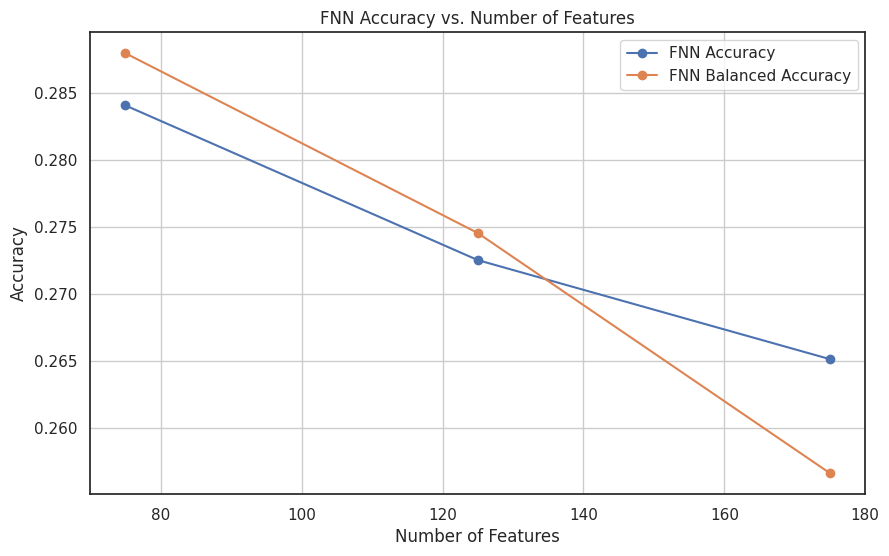

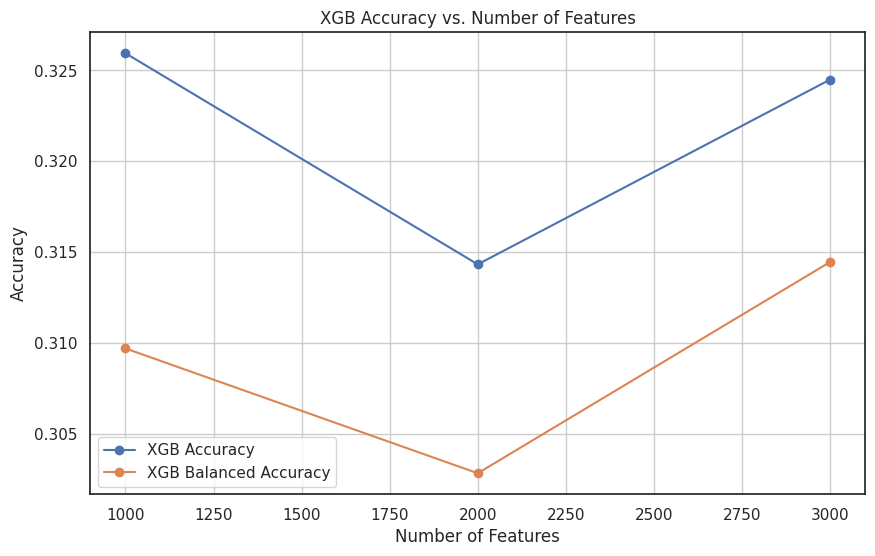

In [ ]:
#create df for fold, number of features, and fnn/xgb acc/bacc
part_b_accuracy_df = pd.DataFrame([
    {key: value for key, value in d.items() if key not in ['fnn predictions', 'xgb predictions', 'true', 'xgb features', 'fnn features']}
    for d in part_b_accuracy_data
])

#calculate mean accuracies across folds for fnn features and xgb features
grouped_fnn = part_b_accuracy_df.groupby('fnn num features')[['fnn acc', 'fnn bacc']].mean()
grouped_xgb = part_b_accuracy_df.groupby('xgb numfeatures')[['xgb acc', 'xgb bacc']].mean()

#get best feature count based on mean accuracy for FNN
best_fnn_features = grouped_fnn['fnn acc'].idxmax()
best_fnn_accuracy = grouped_fnn.loc[best_fnn_features]

#get best feature count based on mean accuracy for XGB
best_xgb_features = grouped_xgb['xgb acc'].idxmax()
best_xgb_accuracy = grouped_xgb.loc[best_xgb_features]

#get most deterministic features for best xgb/fnn model
best_fnn_deterministic_features = None
best_xgb_deterministic_features = None

for data in part_b_accuracy_data:
    if data['fnn num features'] == best_fnn_features and best_fnn_deterministic_features is None:
        best_fnn_deterministic_features = data['fnn features']
    if data['xgb numfeatures'] == best_xgb_features and best_xgb_deterministic_features is None:
        best_xgb_deterministic_features = data['xgb features']

#sorts deterministic features
sorted_fnn_features = sorted(best_fnn_deterministic_features[0].items(), key=lambda x: x[1], reverse=True)
sorted_xgb_features = sorted(best_xgb_deterministic_features[0].items(), key=lambda x: x[1], reverse=True)

#show results
print("----------Mean Accuracies for FNN Features:----------")
print(grouped_fnn)
print("\n----------Mean Accuracies for XGB Features:----------")
print(grouped_xgb)
print("\n\n----------Best Results----------")
print(f"FNN Features: {best_fnn_features}")
print(f"\tMean ACC: {best_fnn_accuracy['fnn acc']} | Mean BACC: {best_fnn_accuracy['fnn bacc']}")
print(f"\nXGB Features: {best_xgb_features}")
print(f"\tMean ACC: {best_xgb_accuracy['xgb acc']} | Mean BACC: {best_xgb_accuracy['xgb bacc']}")

#plot fnn results
plt.figure(figsize=(10, 6))
plt.plot(grouped_fnn.index, grouped_fnn['fnn acc'], label='FNN Accuracy', marker='o')
plt.plot(grouped_fnn.index, grouped_fnn['fnn bacc'], label='FNN Balanced Accuracy', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('FNN Accuracy vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

#plot xgb results
plt.figure(figsize=(10, 6))
plt.plot(grouped_xgb.index, grouped_xgb['xgb acc'], label='XGB Accuracy', marker='o')
plt.plot(grouped_xgb.index, grouped_xgb['xgb bacc'], label='XGB Balanced Accuracy', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('XGB Accuracy vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

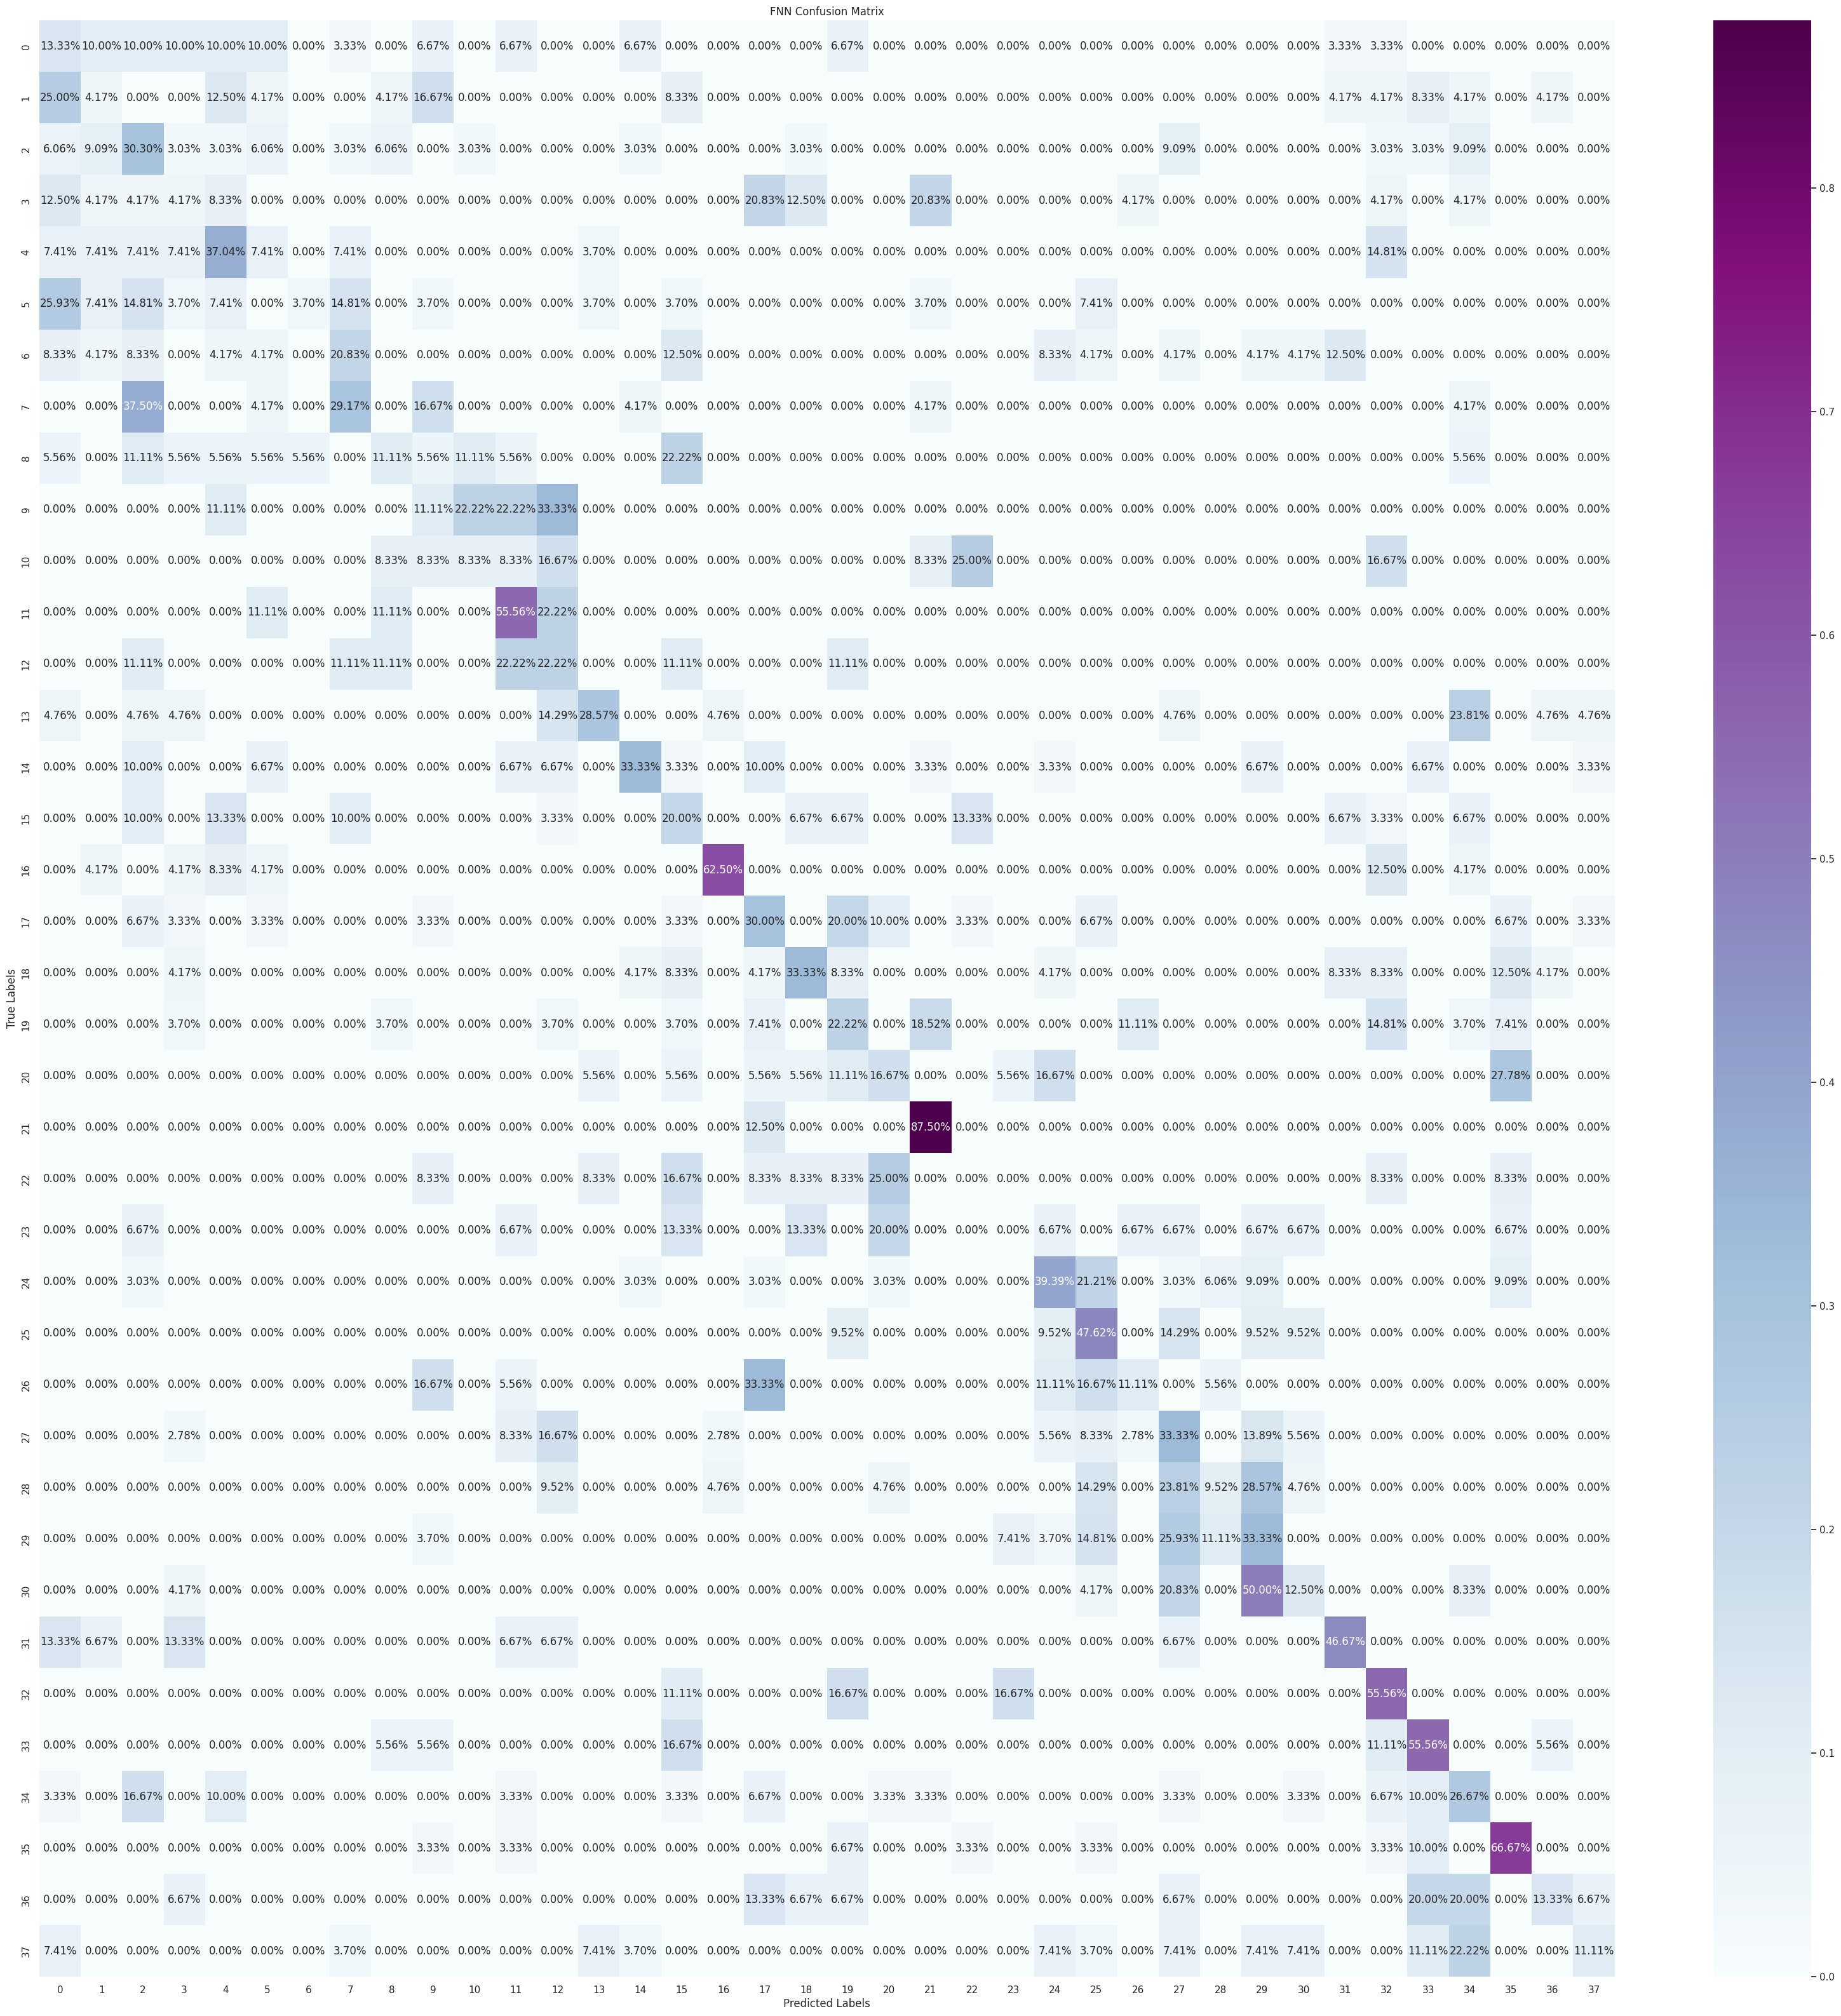

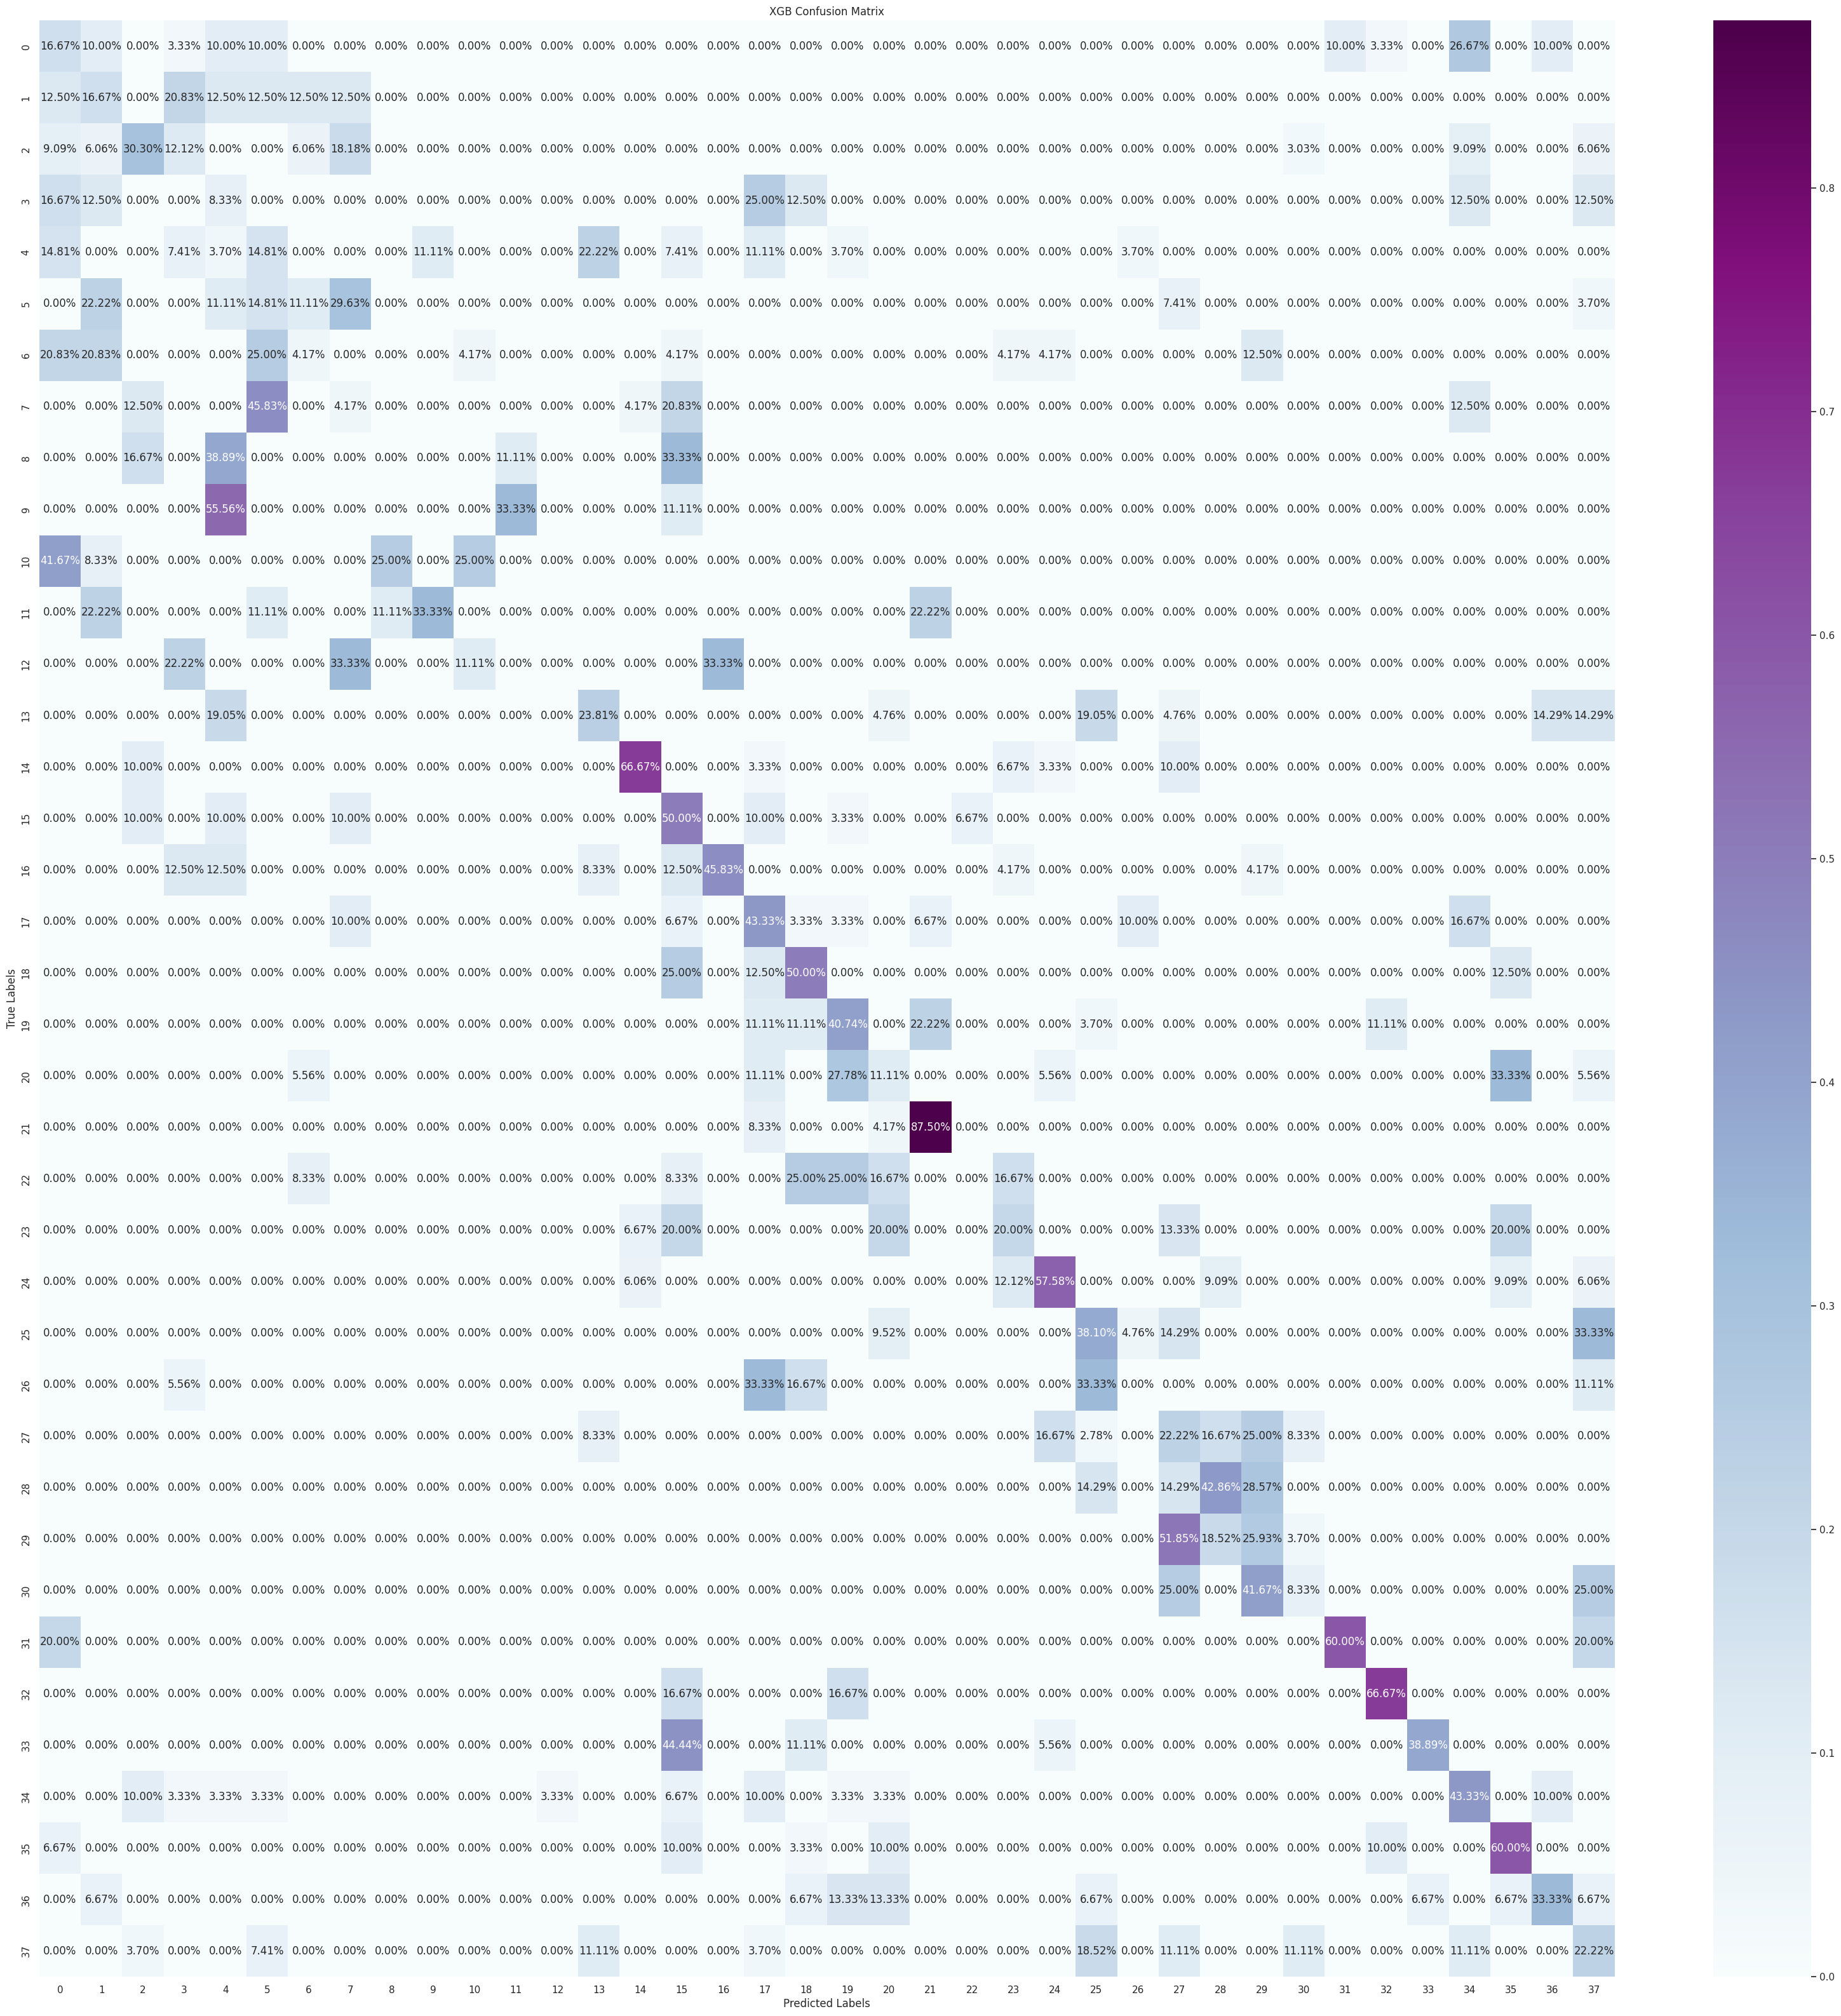

In [ ]:
#init data arrays
true_labels = []
fnn_predicted_labels = []
xgb_predicted_labels = []

#get true/pred for fnn/xgb
for data in part_b_accuracy_data:
    true_labels.extend(data['true'])  # True labels are the same for both models
    fnn_predicted_labels.extend(data['fnn predictions'])
    xgb_predicted_labels.extend(data['xgb predictions'])

#compute confusion matrix
cm_fnn = confusion_matrix(true_labels, fnn_predicted_labels)
cm_xgb = confusion_matrix(true_labels, xgb_predicted_labels)

#normalize cm
cm_fnn_normalized = cm_fnn.astype('float') / cm_fnn.sum(axis=1)[:, np.newaxis]
cm_xgb_normalized = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

#plot FNN CM
plt.figure(figsize=(40, 40))  # Set size for FNN confusion matrix
sns.heatmap(cm_fnn_normalized, annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=np.unique(fnn_predicted_labels), yticklabels=np.unique(true_labels))
plt.title('FNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#plot XGB CM
plt.figure(figsize=(40, 40))  # Set size for XGB confusion matrix
sns.heatmap(cm_xgb_normalized, annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=np.unique(xgb_predicted_labels), yticklabels=np.unique(true_labels))
plt.title('XGB Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

###**Part C and D**

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
all_data = []

for pid in codes['PID'].unique():
    participant_df = create_combined_df(pid, True)
    all_data.append(participant_df)

combined_df = pd.concat(all_data, ignore_index=True)

#checks PID and QID are strings
combined_df['PID'] = combined_df['PID'].astype(str)
combined_df['QID'] = combined_df['QID'].astype(str)

#get BERT features from csv
bert_df = pd.read_csv('/content/drive/MyDrive/Copy of preprocessed_data.csv')
bert_df['PID'] = bert_df['PID'].astype(str)
bert_df['QID'] = bert_df['QID'].astype(str)
combined_df = combined_df.merge(bert_df, on=['PID', 'QID'], how='left')

#label encode PID
label_encoder = LabelEncoder()
combined_df['PID'] = label_encoder.fit_transform(combined_df['PID']) + 1

#fix explainability columns
combined_df = combined_df.drop(columns=['Degree of Explanation_y']).rename(columns={'Degree of Explanation_x': 'Degree of Explanation'})

#print shape
combined_df.shape

(286, 1782)

In [ ]:
#filter only under-explained and succinct for part c
part_c_df = combined_df[combined_df['Degree of Explanation'].isin(['Under-explained', 'Succinct'])]

#filter only comprehensive and over-explained for part d
part_d_df = combined_df[combined_df['Degree of Explanation'].isin(['Comprehensive', 'Over-explained'])]
part_d_df.head(3)

PID QID  \
6     1  Q7   
8     1  Q9   
12    2  Q3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Transcript  \
6                                                                                                                                                                                                                                                                                                                            Interviewer: What, what kind of steps did you take to get that position, or was it something that you just inherited, or how did that work? Veteran: Becuase I kind of backed into it. Um, I uh, ah, my previous sheriff who passed away in August, um, fired me, one, for my technical skills, but two, becuase I was a police officer, but he needed someone at the office that he could rely on to give him a straight answers. Not from people trying to sell him stuff. Interviewer: Right. Veteran: And uh, we, I did that for several years and I approached him, uh, one day, I said "Look, uh, I know you're, you want to move this sheriff's office forward, what do you think about this?" And it was to go to a forensic class and get my forensic certification. Uh, to be uh, CCFE, and uh, he agreed to it and I had no degree, I had no certificates, I just, I just knew what I knew, and I went to the class, and I, I got certified. Um, but ah, I dressed the courts about becoming a professional, or uh, um, I don't know what they call them. A professional witness I guess. And they said "You need something in your background, and I, just telling me you're, you know these things and getting a certification isn't enough. You need to, need to go to school". And this was from a district judge, so I, we got along well. He's an ex-army guy, you know, military, military guy to military guy and he said: "You need to go get some education", so that's where I went.   
8   Veteran: Twety-twenty three Interviewer: Okay, so, that's when you want to make the move? Veteran: Right, right. Interviewer: So, you've got some time. Interviewer: Um, I guess one of the questions I would ask is "If I was, you know, the uh school district, or you're wanting to work for. Why Would, why would I hire you versus other poeple? Why are you the right person for the job?" So this is, 

In [ ]:
#map under-explained to 0 and succinct to 1
part_c_df['Degree of Explanation'] = part_c_df['Degree of Explanation'].map({'Under-explained': 0, 'Succinct': 1})
part_c_df['Degree of Explanation'] = part_c_df['Degree of Explanation'].fillna(-1).astype(int)
part_c_df.head(3)

#map over-explained to 0 and comprehensive to 1
part_d_df['Degree of Explanation'] = part_d_df['Degree of Explanation'].map({'Over-explained': 0, 'Comprehensive': 1})
part_d_df['Degree of Explanation'] = part_d_df['Degree of Explanation'].fillna(-1).astype(int)
part_d_df.head(3)

PID QID  \
6     1  Q7   
8     1  Q9   
12    2  Q3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Transcript  \
6                                                                                                                                                                                                                                                                                                                            Interviewer: What, what kind of steps did you take to get that position, or was it something that you just inherited, or how did that work? Veteran: Becuase I kind of backed into it. Um, I uh, ah, my previous sheriff who passed away in August, um, fired me, one, for my technical skills, but two, becuase I was a police officer, but he needed someone at the office that he could rely on to give him a straight answers. Not from people trying to sell him stuff. Interviewer: Right. Veteran: And uh, we, I did that for several years and I approached him, uh, one day, I said "Look, uh, I know you're, you want to move this sheriff's office forward, what do you think about this?" And it was to go to a forensic class and get my forensic certification. Uh, to be uh, CCFE, and uh, he agreed to it and I had no degree, I had no certificates, I just, I just knew what I knew, and I went to the class, and I, I got certified. Um, but ah, I dressed the courts about becoming a professional, or uh, um, I don't know what they call them. A professional witness I guess. And they said "You need something in your background, and I, just telling me you're, you know these things and getting a certification isn't enough. You need to, need to go to school". And this was from a district judge, so I, we got along well. He's an ex-army guy, you know, military, military guy to military guy and he said: "You need to go get some education", so that's where I went.   
8   Veteran: Twety-twenty three Interviewer: Okay, so, that's when you want to make the move? Veteran: Right, right. Interviewer: So, you've got some time. Interviewer: Um, I guess one of the questions I would ask is "If I was, you know, the uh school district, or you're wanting to work for. Why Would, why would I hire you versus other poeple? Why are you the right person for the job?" So this is, 

In [ ]:
#label encode the PID column for c and d
label_encoder = LabelEncoder()
part_c_df['PID'] = label_encoder.fit_transform(part_c_df['PID']) + 1
part_d_df['PID'] = label_encoder.fit_transform(part_d_df['PID']) + 1

#number of folds
num_folds = 5

#generates folds
def create_folds(dataframe, num_folds):
    #create an empty list to store folds
    folds = [[] for _ in range(num_folds)]

    #group by PID
    grouped = dataframe.groupby('PID')

    #distribute QIDs into folds randomly
    for pid, group in grouped:
        qids = group['QID'].tolist()
        random.shuffle(qids)
        for i, qid in enumerate(qids):
            #assign QIDs to folds in a round-robin fashion
            folds[i % num_folds].append(group[group['QID'] == qid])

    #concatenate rows within each fold
    return [pd.concat(fold).reset_index(drop=True) for fold in folds]

#creates c/d folds
fold_dfs_c = create_folds(part_c_df, num_folds)
fold_dfs_d = create_folds(part_d_df, num_folds)

# #test output for c
# print("Part C Fold 1:")
# print(fold_dfs_c[0].head(3))

# #test output for d
# print("Part D Fold 1:")
# print(fold_dfs_d[0].head(3))

In [ ]:
#bert intervals: 1014-1782
#sentiment intervals: 1009:1013
#tfidf intervals: 10:1008

def compute_mi_and_select_features(df, k_tfidf, k_sentiment, k_bert, k_other):
    #compute MI
    mi_tfidf = mutual_info_classif(df.iloc[:, 10:1009], df['Degree of Explanation'], discrete_features=False)
    mi_sentiment = mutual_info_classif(df.iloc[:, 1009:1014], df['Degree of Explanation'], discrete_features=False)
    mi_bert = mutual_info_classif(df.iloc[:, 1014:], df['Degree of Explanation'], discrete_features=False)
    mi_other = mutual_info_classif(df.iloc[:, 4:10], df['Degree of Explanation'], discrete_features=False)

    #create df for MI scores
    mi_scores_tfidf = pd.DataFrame({'Feature': df.iloc[:, 10:1009].columns, 'MI': mi_tfidf}).sort_values(by='MI', ascending=False)
    mi_scores_sentiment = pd.DataFrame({'Feature': df.iloc[:, 1009:1014].columns, 'MI': mi_sentiment}).sort_values(by='MI', ascending=False)
    mi_scores_bert = pd.DataFrame({'Feature': df.iloc[:, 1014:].columns, 'MI': mi_bert}).sort_values(by='MI', ascending=False)
    mi_scores_other = pd.DataFrame({'Feature': df.iloc[:, 4:10].columns, 'MI': mi_other}).sort_values(by='MI', ascending=False)

    #get top features
    top_k_tfidf = mi_scores_tfidf.head(k_tfidf)['Feature']
    top_k_sentiment = mi_scores_sentiment.head(k_sentiment)['Feature']
    top_k_bert = mi_scores_bert.head(k_bert)['Feature']
    top_k_other = mi_scores_other.head(k_other)['Feature']

    #combine features
    selected_features = pd.concat([top_k_tfidf, top_k_sentiment, top_k_bert, top_k_other])

    return selected_features.tolist()

In [ ]:
def prepare_dataset(df, selected_features):
    #convert to strings
    df['PID'] = df['PID'].astype(str).str.strip()
    df['QID'] = df['QID'].astype(str).str.strip()

    return df[['PID', 'QID'] + selected_features + ['Degree of Explanation']]

In [ ]:
def random_forest_model(X_train, y_train, X_val, y_val):
    #init rf
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    model.fit(X_train, y_train)

    #get pred
    y_pred = model.predict(X_val)

    #return acc, bacc, y_pred, model
    return accuracy_score(y_val, y_pred), balanced_accuracy_score(y_val, y_pred), y_pred, model

In [ ]:
def fnn_model_1(X_train, y_train, X_val, y_val):
  fnn_model = Sequential(
      [
          Dense(2048, input_shape=(X_train.shape[1],), activation="relu"),
          Dense(1024, activation="relu"),
          Dropout(.25),
          Dense(512, activation="relu"),
          Dense(256, activation="relu"),
          Dropout(.15),
          Dense(128, activation="relu"),
          Dense(len(np.unique(y_train)), activation="softmax"),
      ]
  )
  fnn_model.summary()

  #compile the model
  fnn_model.compile(
      optimizer=Adam(),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )

  #train the model
  fnn_model_results = fnn_model.fit(X_train, to_categorical(y_train), batch_size=32, epochs=10,
      validation_data=[X_val, to_categorical(y_val)])

  #get predictions
  y_pred = fnn_model.predict(X_val)
  y_pred = np.argmax(y_pred, axis=1)

  #return acc, bacc, predictions, and model
  return accuracy_score(y_val, y_pred), balanced_accuracy_score(y_val, y_pred), y_pred, fnn_model

In [ ]:
# number of features
k_values = [25, 50, 150, 250, 350]
total = len(k_values) * len(fold_dfs_c) + len(k_values) * len(fold_dfs_d)

# get bert columns
bert_columns_c = part_c_df.columns[1014:]
bert_columns_d = part_d_df.columns[1014:]

# accuracy data for part c and part d
accuracy_data_combined_c = []
accuracy_data_combined_d = []


#-------------------- part c --------------------
for k in k_values:
    #compute mi and select features for part c
    selected_features_c = compute_mi_and_select_features(part_c_df, k_tfidf=k, k_sentiment=4, k_bert=k, k_other=6)

    for i in range(len(fold_dfs_c)):
        print(f'remaining iterations: {total}')
        total -= 1

        #split train/val
        train_df_c = pd.concat(fold_dfs_c[:i] + fold_dfs_c[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df_c = fold_dfs_c[i].sample(frac=1).reset_index(drop=True)

        #prepare datasets
        train_data_c = prepare_dataset(train_df_c, selected_features_c)
        val_data_c = prepare_dataset(val_df_c, selected_features_c)

        #separate features and labels
        X_train_c = train_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_train_c = train_data_c['Degree of Explanation']
        X_val_c = val_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_val_c = val_data_c['Degree of Explanation']

        #scale features
        scaler = StandardScaler()
        X_train_c = scaler.fit_transform(X_train_c)
        X_val_c = scaler.transform(X_val_c)

        #smote to oversample
        smote = SMOTE()
        X_train_c_balanced, y_train_c_balanced = smote.fit_resample(X_train_c, y_train_c)

        #run rf
        rf_acc_c, rf_bacc_c, rf_y_pred_c, rf_model = random_forest_model(X_train_c_balanced, y_train_c_balanced, X_val_c, y_val_c)

        feature_importances = rf_model.feature_importances_
        feature_names = train_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).columns
        important_features = sorted(zip(feature_importances, feature_names), reverse=True)

        #store rf results
        accuracy_data_combined_c.append({
            'model': 'Random Forest',
            'k': k,
            'fold': i,
            'accuracy': rf_acc_c,
            'balanced_accuracy': rf_bacc_c,
            'predictions': rf_y_pred_c.tolist(),
            'important features' : important_features,
            'true': y_val_c.tolist(),
        })

        #run fnn
        fnn_acc_c, fnn_bacc_c, fnn_y_pred_c, model = fnn_model_1(X_train_c, y_train_c, X_val_c, y_val_c)

        #get abs fnn weights
        input_layer_weights = model.layers[0].get_weights()[0]  # Weights from input to first hidden layer
        feature_importance_fnn = np.sum(np.abs(input_layer_weights), axis=1)

        #map importance scores to feature names
        importance_scores = zip(feature_importance_fnn, feature_names)
        sorted_importance = sorted(importance_scores, key=lambda x: x[0], reverse=True)

        #store fnn results
        accuracy_data_combined_c.append({
            'model': 'FNN',
            'k': k,
            'fold': i,
            'accuracy': fnn_acc_c,
            'balanced_accuracy': fnn_bacc_c,
            'predictions': fnn_y_pred_c.tolist(),
            'important features' : sorted_importance,
            'true': y_val_c.tolist(),
        })


#-------------------- part d --------------------
for k in k_values:
    #compute mi and select features for part d
    selected_features_d = compute_mi_and_select_features(part_d_df, k_tfidf=k, k_sentiment=4, k_bert=k, k_other=6)

    for i in range(len(fold_dfs_d)):
        print(f'remaining iterations: {total}')
        total -= 1

        #split train/val
        train_df_d = pd.concat(fold_dfs_d[:i] + fold_dfs_d[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df_d = fold_dfs_d[i].sample(frac=1).reset_index(drop=True)

        #prepare datasets
        train_data_d = prepare_dataset(train_df_d, selected_features_d)
        val_data_d = prepare_dataset(val_df_d, selected_features_d)

        #separate features and labels
        X_train_d = train_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_train_d = train_data_d['Degree of Explanation']
        X_val_d = val_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_val_d = val_data_d['Degree of Explanation']

        #scale features
        scaler = StandardScaler()
        X_train_d = scaler.fit_transform(X_train_d)
        X_val_d = scaler.transform(X_val_d)

        #smote to oversample
        smote = SMOTE()
        X_train_d_balanced, y_train_d_balanced = smote.fit_resample(X_train_d, y_train_d)

        #run rf
        rf_acc_d, rf_bacc_d, rf_y_pred_d, rf_model = random_forest_model(X_train_d_balanced, y_train_d_balanced, X_val_d, y_val_d)

        feature_importances = rf_model.feature_importances_
        feature_names = train_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).columns
        important_features = sorted(zip(feature_importances, feature_names), reverse=True)

        #store rf results
        accuracy_data_combined_d.append({
            'model': 'Random Forest',
            'k': k,
            'fold': i,
            'accuracy': rf_acc_d,
            'balanced_accuracy': rf_bacc_d,
            'predictions': rf_y_pred_d.tolist(),
            'important features' : important_features,
            'true': y_val_d.tolist(),
        })

        #run fnn
        fnn_acc_d, fnn_bacc_d, fnn_y_pred_d, model = fnn_model_1(X_train_d, y_train_d, X_val_d, y_val_d)

        #get abs fnn weights
        input_layer_weights = model.layers[0].get_weights()[0]  # Weights from input to first hidden layer
        feature_importance_fnn = np.sum(np.abs(input_layer_weights), axis=1)

        #map importance scores to feature names
        importance_scores = zip(feature_importance_fnn, feature_names)
        sorted_importance = sorted(importance_scores, key=lambda x: x[0], reverse=True)

        #store fnn results
        accuracy_data_combined_d.append({
            'model': 'FNN',
            'k': k,
            'fold': i,
            'accuracy': fnn_acc_d,
            'balanced_accuracy': fnn_bacc_d,
            'predictions': fnn_y_pred_d.tolist(),
            'important features' : sorted_importance,
            'true': y_val_d.tolist(),
        })

remaining iterations: 50


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                     │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.7739 - loss: 0.5588 - val_accuracy: 0.8293 - val_loss: 0.6631
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8515 - loss: 0.3464 - val_accuracy: 0.8293 - val_loss: 0.4638
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8466 - loss: 0.3486 - val_accuracy: 0.8293 - val_loss: 0.6581
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8415 - loss: 0.2194 - val_accuracy: 0.8293 - val_loss: 1.0077
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8908 - loss: 0.1662 - val_accuracy: 0.7317 - val_loss: 0.9938
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9827 - loss: 0.1265 - val_accuracy: 0.8293 - val_loss: 1.4130
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0484 - val_accuracy: 0.8293 - val_loss: 1.9092
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.8293 - val_loss: 2

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                     │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.5572 - loss: 0.6251 - val_accuracy: 0.8667 - val_loss: 0.3935
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7990 - loss: 0.4344 - val_accuracy: 0.8667 - val_loss: 0.3263
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7959 - loss: 0.4005 - val_accuracy: 0.8667 - val_loss: 0.3011
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8080 - loss: 0.3203 - val_accuracy: 0.8667 - val_loss: 0.3017
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8645 - loss: 0.2550 - val_accuracy: 0.8667 - val_loss: 0.3320
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8461 - loss: 0.2210 - val_accuracy: 0.9000 - val_loss: 0.3771
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9137 - loss: 0.1494 - val_accuracy: 0.8333 - val_loss: 0.4162
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9845 - loss: 0.0782 - val_accuracy: 0.8333 - val_loss: 0.554

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6174 - loss: 0.6359 - val_accuracy: 0.8519 - val_loss: 0.4854
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8398 - loss: 0.3440 - val_accuracy: 0.8519 - val_loss: 0.4740
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8043 - loss: 0.3530 - val_accuracy: 0.8519 - val_loss: 0.5623
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8127 - loss: 0.2604 - val_accuracy: 0.8519 - val_loss: 0.6265
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8953 - loss: 0.2178 - val_accuracy: 0.7778 - val_loss: 0.6628
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9483 - loss: 0.1557 - val_accuracy: 0.8148 - val_loss: 1.0967
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9319 - loss: 0.1203 - val_accuracy: 0.7778 - val_loss: 1.1210
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9909 - loss: 0.0736 - val_accuracy: 0.7778 - val_loss: 1.2912

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8206 - loss: 0.5099 - val_accuracy: 0.7368 - val_loss: 0.5545
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8481 - loss: 0.3051 - val_accuracy: 0.5263 - val_loss: 0.6741
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9565 - loss: 0.2128 - val_accuracy: 0.5263 - val_loss: 1.2569
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9704 - loss: 0.0896 - val_accuracy: 0.5263 - val_loss: 1.7791
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.5789 - val_loss: 2.3865
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.5263 - val_loss: 3.2497
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.5789 - val_loss: 3.8183
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.5263 - val_loss: 4.7090

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.8167 - loss: 0.5892 - val_accuracy: 0.7692 - val_loss: 0.5193
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8170 - loss: 0.4462 - val_accuracy: 0.7692 - val_loss: 0.4504
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8306 - loss: 0.3649 - val_accuracy: 0.7692 - val_loss: 0.4515
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8410 - loss: 0.2873 - val_accuracy: 0.7692 - val_loss: 0.4089
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9390 - loss: 0.2010 - val_accuracy: 0.7692 - val_loss: 0.4921
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9558 - loss: 0.1535 - val_accuracy: 0.7692 - val_loss: 0.6395
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9966 - loss: 0.0510 - val_accuracy: 0.7692 - val_loss: 0.9016
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0191 - val_accuracy: 0.7692 - val_loss: 1.7000

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7219 - loss: 0.5713 - val_accuracy: 0.8293 - val_loss: 0.4270
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8398 - loss: 0.3227 - val_accuracy: 0.8293 - val_loss: 0.4294
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8098 - loss: 0.2563 - val_accuracy: 0.8293 - val_loss: 0.6172
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9368 - loss: 0.1532 - val_accuracy: 0.8293 - val_loss: 0.6917
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0605 - val_accuracy: 0.7317 - val_loss: 0.9545
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.8293 - val_loss: 1.6013
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.8293 - val_loss: 2.3159
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.8537 - val_loss: 2.953

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_126 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7844 - loss: 0.5515 - val_accuracy: 0.8667 - val_loss: 0.4625
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7719 - loss: 0.5770 - val_accuracy: 0.8667 - val_loss: 0.3435
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8000 - loss: 0.3208 - val_accuracy: 0.9000 - val_loss: 0.3340
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8765 - loss: 0.2159 - val_accuracy: 0.8667 - val_loss: 0.4758
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9572 - loss: 0.1096 - val_accuracy: 0.8667 - val_loss: 0.7526
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0350 - val_accuracy: 0.7333 - val_loss: 1.1528
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.8333 - val_loss: 1.6596
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9908 - loss: 0.0109 - val_accuracy: 0.8333 - val_loss: 1.9609

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5197 - loss: 0.6527 - val_accuracy: 0.8519 - val_loss: 0.3576
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8043 - loss: 0.3659 - val_accuracy: 0.8519 - val_loss: 0.2937
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8252 - loss: 0.2631 - val_accuracy: 0.8519 - val_loss: 0.3247
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9298 - loss: 0.1952 - val_accuracy: 0.8519 - val_loss: 0.3496
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9540 - loss: 0.1119 - val_accuracy: 0.9259 - val_loss: 0.3768
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9909 - loss: 0.0469 - val_accuracy: 0.9259 - val_loss: 0.4690
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8889 - val_loss: 0.7995
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8889 - val_loss: 1.0

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8024 - loss: 0.5985 - val_accuracy: 0.7368 - val_loss: 0.5402
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8195 - loss: 0.3428 - val_accuracy: 0.7368 - val_loss: 0.6995
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8651 - loss: 0.1918 - val_accuracy: 0.5263 - val_loss: 1.0303
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9849 - loss: 0.0854 - val_accuracy: 0.5263 - val_loss: 1.7964
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.5263 - val_loss: 2.6274
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.5263 - val_loss: 3.5704
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 2.8384e-04 - val_accuracy: 0.5263 - val_loss: 4.4435
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.2712e-05 - val_accuracy: 0.5263 - val_loss

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.7575 - loss: 0.6276 - val_accuracy: 0.7692 - val_loss: 0.5456
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8264 - loss: 0.4050 - val_accuracy: 0.7692 - val_loss: 0.4787
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8316 - loss: 0.2696 - val_accuracy: 0.7692 - val_loss: 0.5341
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8683 - loss: 0.1899 - val_accuracy: 0.8462 - val_loss: 0.5945
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9945 - loss: 0.0876 - val_accuracy: 0.7692 - val_loss: 0.9955
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0241 - val_accuracy: 0.8462 - val_loss: 1.5027
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.7692 - val_loss: 1.7459
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 7.6556e-04 - val_accuracy: 0.7692 - val_loss: 3

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.6274 - loss: 0.6215 - val_accuracy: 0.8293 - val_loss: 0.4399
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8125 - loss: 0.4009 - val_accuracy: 0.8293 - val_loss: 0.5502
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8532 - loss: 0.2362 - val_accuracy: 0.8293 - val_loss: 0.5688
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9849 - loss: 0.1224 - val_accuracy: 0.8293 - val_loss: 0.6835
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0542 - val_accuracy: 0.8293 - val_loss: 1.5499
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 0.8293 - val_loss: 2.1197
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.8293 - val_loss: 2.3781
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.4172e-04 - val_accuracy: 0.8293 - val_loss: 2.

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.6512 - loss: 0.6099 - val_accuracy: 0.8667 - val_loss: 0.7977
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7473 - loss: 0.8477 - val_accuracy: 0.8667 - val_loss: 0.3854
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8063 - loss: 0.3650 - val_accuracy: 0.8667 - val_loss: 0.4703
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8217 - loss: 0.2308 - val_accuracy: 0.9333 - val_loss: 0.2932
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9785 - loss: 0.1242 - val_accuracy: 0.8667 - val_loss: 0.6414
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0353 - val_accuracy: 0.8667 - val_loss: 1.3896
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.8667 - val_loss: 1.7144
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8667 - val_loss: 1

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_162 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6109 - loss: 0.6012 - val_accuracy: 0.8519 - val_loss: 0.4426
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8293 - loss: 0.4003 - val_accuracy: 0.8519 - val_loss: 0.3848
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8366 - loss: 0.2947 - val_accuracy: 0.8519 - val_loss: 0.3346
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9449 - loss: 0.1681 - val_accuracy: 0.8889 - val_loss: 0.2987
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0614 - val_accuracy: 0.8889 - val_loss: 0.5880
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.8889 - val_loss: 0.6227
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8519 - val_loss: 0.8297
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.3978e-04 - val_accuracy: 0.8889 - val_loss: 1.

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_169 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_170 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_171 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_172 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_173 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.5428 - loss: 0.7278 - val_accuracy: 0.7368 - val_loss: 0.6661
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8362 - loss: 0.3559 - val_accuracy: 0.7368 - val_loss: 1.0033
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8569 - loss: 0.2222 - val_accuracy: 0.6316 - val_loss: 1.0212
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9840 - loss: 0.1493 - val_accuracy: 0.6842 - val_loss: 2.4758
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0332 - val_accuracy: 0.6316 - val_loss: 3.0593
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.6316 - val_loss: 4.2027
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 6.5091e-04 - val_accuracy: 0.6316 - val_loss: 5.2610
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 1.9699e-04 - val_accuracy: 0.6316 - val_l

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_174 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_175 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_179 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.7223 - loss: 0.6270 - val_accuracy: 0.7692 - val_loss: 0.4737
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8150 - loss: 0.3713 - val_accuracy: 0.7692 - val_loss: 0.4730
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8886 - loss: 0.1883 - val_accuracy: 0.7692 - val_loss: 0.4576
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0843 - val_accuracy: 0.7692 - val_loss: 0.9998
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.6923 - val_loss: 1.1772
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.6154 - val_loss: 1.9431
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 1.3938e-04 - val_accuracy: 0.6154 - val_loss: 2.6544
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.3818e-04 - val_accuracy: 0.6154 - val_loss

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_184 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_185 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.7470 - loss: 0.8094 - val_accuracy: 0.8293 - val_loss: 0.4327
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8281 - loss: 0.3920 - val_accuracy: 0.8293 - val_loss: 0.4273
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8606 - loss: 0.2360 - val_accuracy: 0.8537 - val_loss: 0.4784
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0781 - val_accuracy: 0.8537 - val_loss: 0.6883
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.8537 - val_loss: 1.0483
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 9.7617e-04 - val_accuracy: 0.8537 - val_loss: 1.1584
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 1.0056e-04 - val_accuracy: 0.8293 - val_loss: 1.2483
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 1.0079e-05 - val_accuracy: 0.8293 - val

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_186 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_187 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_188 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_189 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_190 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_191 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.5456 - loss: 0.8226 - val_accuracy: 0.8667 - val_loss: 0.4970
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8261 - loss: 0.3765 - val_accuracy: 0.9000 - val_loss: 0.4408
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9107 - loss: 0.2995 - val_accuracy: 0.8667 - val_loss: 1.3822
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8339 - loss: 0.2487 - val_accuracy: 0.8667 - val_loss: 0.7739
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9939 - loss: 0.0641 - val_accuracy: 0.8333 - val_loss: 1.3307
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8667 - val_loss: 2.4167
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8667 - val_loss: 3.2542
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8667 - val_loss: 3.7948

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_196 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_197 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.7872 - loss: 0.6501 - val_accuracy: 0.8519 - val_loss: 0.5847
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8106 - loss: 0.3971 - val_accuracy: 0.8519 - val_loss: 0.5870
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8869 - loss: 0.2483 - val_accuracy: 0.8519 - val_loss: 1.1380
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9665 - loss: 0.1159 - val_accuracy: 0.8148 - val_loss: 1.0609
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 0.8519 - val_loss: 2.0286
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8519 - val_loss: 3.3952
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 8.4211e-04 - val_accuracy: 0.8519 - val_loss: 4.3629
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 2.2269e-04 - val_accuracy: 0.8519 - val_lo

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_198 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_199 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_200 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_201 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_202 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_203 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.6471 - loss: 0.7310 - val_accuracy: 0.7368 - val_loss: 0.5980
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8591 - loss: 0.3428 - val_accuracy: 0.7368 - val_loss: 0.7163
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9108 - loss: 0.2116 - val_accuracy: 0.7368 - val_loss: 1.0292
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9943 - loss: 0.0476 - val_accuracy: 0.7368 - val_loss: 1.8784
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.7368 - val_loss: 2.7668
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.7368 - val_loss: 4.6149
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 1.2954e-04 - val_accuracy: 0.7368 - val_loss: 6.0151
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 1.2393e-04 - val_accuracy: 0.7368 - val_loss

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_204 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_206 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_207 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_208 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_209 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.6220 - loss: 0.6576 - val_accuracy: 0.7692 - val_loss: 0.6096
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8327 - loss: 0.3976 - val_accuracy: 0.7692 - val_loss: 0.9866
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8728 - loss: 0.2731 - val_accuracy: 0.7692 - val_loss: 1.4272
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.9616 - loss: 0.0899 - val_accuracy: 0.8462 - val_loss: 1.7905
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 0.7692 - val_loss: 2.4724
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.5980e-04 - val_accuracy: 0.7692 - val_loss: 4.7896
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9966 - loss: 0.0037 - val_accuracy: 0.7692 - val_loss: 6.2533
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 4.4791e-04 - val_accuracy: 0.7692 - val_l

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_211 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_212 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_213 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_214 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_215 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.6257 - loss: 0.6965 - val_accuracy: 0.8293 - val_loss: 0.4110
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8007 - loss: 0.4399 - val_accuracy: 0.8293 - val_loss: 0.5929
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.8320 - loss: 0.3561 - val_accuracy: 0.8293 - val_loss: 0.5231
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.8518 - loss: 0.2343 - val_accuracy: 0.7805 - val_loss: 0.4268
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9653 - loss: 0.0878 - val_accuracy: 0.8049 - val_loss: 1.0197
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.8049 - val_loss: 1.4822
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.8049 - val_loss: 1.7687
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 9.2146e-04 - val_accuracy: 0.8049 - val_l

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_216 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_217 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_218 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_219 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_220 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.6575 - loss: 0.5722 - val_accuracy: 0.8667 - val_loss: 1.3066
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8555 - loss: 0.5143 - val_accuracy: 0.9000 - val_loss: 0.5704
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9235 - loss: 0.1900 - val_accuracy: 0.8667 - val_loss: 1.2115
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 0.8667 - val_loss: 1.8899
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9939 - loss: 0.0144 - val_accuracy: 0.8667 - val_loss: 3.8155
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9939 - loss: 0.0123 - val_accuracy: 0.9000 - val_loss: 3.6323
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 7.9164e-05 - val_accuracy: 0.9000 - val_loss: 3.1183
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9939 - loss: 0.0274 - val_accuracy: 0.9333 - val_loss

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_222 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_223 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_224 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_225 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_226 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_227 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.4786 - loss: 0.7912 - val_accuracy: 0.8148 - val_loss: 0.6104
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8322 - loss: 0.4332 - val_accuracy: 0.8148 - val_loss: 0.5608
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9119 - loss: 0.2038 - val_accuracy: 0.8519 - val_loss: 0.9807
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9540 - loss: 0.1113 - val_accuracy: 0.8519 - val_loss: 1.4209
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.8519 - val_loss: 3.9807
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.8519 - val_loss: 4.4615
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 9.4860e-04 - val_accuracy: 0.8519 - val_loss: 4.0947
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 5.9773e-06 - val_accuracy: 0.8889 - val_loss

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_230 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_231 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_232 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_233 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6098 - loss: 0.6898 - val_accuracy: 0.7368 - val_loss: 0.6423
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8216 - loss: 0.4121 - val_accuracy: 0.7368 - val_loss: 1.8355
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8309 - loss: 0.3505 - val_accuracy: 0.6316 - val_loss: 1.1237
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9907 - loss: 0.1022 - val_accuracy: 0.6842 - val_loss: 3.1585
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.6316 - val_loss: 4.1925
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.6316 - val_loss: 5.1468
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.6591e-04 - val_accuracy: 0.6316 - val_loss: 6.2731
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 2.6476e-04 - val_accuracy: 0.6316 - val

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_234 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_235 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_236 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_237 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_238 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_239 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6445 - loss: 0.7061 - val_accuracy: 0.7692 - val_loss: 0.5222
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8420 - loss: 0.4000 - val_accuracy: 0.7692 - val_loss: 0.8284
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8691 - loss: 0.2277 - val_accuracy: 0.6923 - val_loss: 0.5747
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0802 - val_accuracy: 0.7692 - val_loss: 1.3248
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.7692 - val_loss: 1.3158
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 9.4995e-04 - val_accuracy: 0.7692 - val_loss: 1.6003
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 5.9673e-04 - val_accuracy: 0.7692 - val_loss: 2.2153
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.9991e-06 - val_accuracy: 0.6923 - val_

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_241 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_243 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_245 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.7673 - loss: 0.6917 - val_accuracy: 0.8667 - val_loss: 0.4354
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8304 - loss: 0.4065 - val_accuracy: 0.9111 - val_loss: 0.2689
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8486 - loss: 0.3102 - val_accuracy: 0.8222 - val_loss: 0.3563
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8890 - loss: 0.1873 - val_accuracy: 0.8889 - val_loss: 0.2628
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9559 - loss: 0.0984 - val_accuracy: 0.8000 - val_loss: 0.7214
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9793 - loss: 0.0650 - val_accuracy: 0.8889 - val_loss: 0.3154
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9912 - loss: 0.0548 - val_accuracy: 0.9111 - val_loss: 0.4284
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.8444 - val_loss: 0.6714

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_247 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_248 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_249 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_250 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_251 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5982 - loss: 0.6490 - val_accuracy: 0.7436 - val_loss: 0.5648
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8121 - loss: 0.4192 - val_accuracy: 0.7949 - val_loss: 0.5208
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8580 - loss: 0.2670 - val_accuracy: 0.7949 - val_loss: 0.8680
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9354 - loss: 0.1973 - val_accuracy: 0.7436 - val_loss: 1.0079
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9618 - loss: 0.0878 - val_accuracy: 0.7692 - val_loss: 1.5878
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9731 - loss: 0.0639 - val_accuracy: 0.7949 - val_loss: 2.3160
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9702 - loss: 0.0668 - val_accuracy: 0.7692 - val_loss: 2.0319
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9966 - loss: 0.0150 - val_accuracy: 0.7692 - val_loss: 2.0603

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_253 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_254 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_255 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_257 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.6669 - loss: 0.6389 - val_accuracy: 0.8333 - val_loss: 0.3883
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8207 - loss: 0.3698 - val_accuracy: 0.8667 - val_loss: 0.2672
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8407 - loss: 0.2712 - val_accuracy: 0.8333 - val_loss: 0.2727
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9130 - loss: 0.1994 - val_accuracy: 0.8333 - val_loss: 0.2815
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9832 - loss: 0.0774 - val_accuracy: 0.8000 - val_loss: 0.3598
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9895 - loss: 0.0495 - val_accuracy: 0.8667 - val_loss: 0.5956
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9916 - loss: 0.0371 - val_accuracy: 0.8000 - val_loss: 0.7033
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.8333 - val_loss: 0.78

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_259 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_260 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_261 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_262 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_263 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.7057 - loss: 0.5611 - val_accuracy: 0.8750 - val_loss: 0.4594
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8449 - loss: 0.3172 - val_accuracy: 0.8333 - val_loss: 0.7755
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9343 - loss: 0.1709 - val_accuracy: 0.7917 - val_loss: 0.7995
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9464 - loss: 0.1250 - val_accuracy: 0.8750 - val_loss: 1.1476
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9863 - loss: 0.0465 - val_accuracy: 0.8750 - val_loss: 1.0312
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9880 - loss: 0.0413 - val_accuracy: 0.8333 - val_loss: 1.2973
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.8333 - val_loss: 1.5538
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.8750 - val_loss: 1.7014

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_264 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_265 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_266 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_267 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7789 - loss: 0.5696 - val_accuracy: 0.7222 - val_loss: 0.6518
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8657 - loss: 0.3099 - val_accuracy: 0.7778 - val_loss: 0.9831
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9225 - loss: 0.1725 - val_accuracy: 0.7778 - val_loss: 0.8051
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9003 - loss: 0.2034 - val_accuracy: 0.7778 - val_loss: 1.7660
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9654 - loss: 0.1166 - val_accuracy: 0.7778 - val_loss: 1.2621
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9704 - loss: 0.1046 - val_accuracy: 0.7778 - val_loss: 2.1757
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9926 - loss: 0.0251 - val_accuracy: 0.7778 - val_loss: 2.7408
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.7222 - val_loss: 2.844

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_270 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_271 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_272 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_273 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_274 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_275 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.6430 - loss: 0.6178 - val_accuracy: 0.8222 - val_loss: 0.4798
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7864 - loss: 0.3914 - val_accuracy: 0.8889 - val_loss: 0.5123
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8765 - loss: 0.2207 - val_accuracy: 0.7556 - val_loss: 0.5724
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9699 - loss: 0.0779 - val_accuracy: 0.8444 - val_loss: 0.8705
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9912 - loss: 0.0442 - val_accuracy: 0.8444 - val_loss: 1.2076
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.7556 - val_loss: 1.6795
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 2.3927e-04 - val_accuracy: 0.7333 - val_loss: 2.0970
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 3.4829e-04 - val_accuracy: 0.7333 - val_

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_276 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_277 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_278 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_279 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_280 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_281 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.7614 - loss: 0.5696 - val_accuracy: 0.7436 - val_loss: 0.4534
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8578 - loss: 0.2993 - val_accuracy: 0.7692 - val_loss: 0.4482
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9527 - loss: 0.1538 - val_accuracy: 0.7692 - val_loss: 0.7434
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9914 - loss: 0.0302 - val_accuracy: 0.7436 - val_loss: 1.1136
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7692 - val_loss: 1.6845
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.4549e-04 - val_accuracy: 0.7692 - val_loss: 2.1578
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 6.4835e-05 - val_accuracy: 0.7692 - val_loss: 2.5241
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 6.7603e-06 - val_accuracy: 0.7692 - val_

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_282 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_283 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_284 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_285 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_286 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_287 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7100 - loss: 0.5703 - val_accuracy: 0.9000 - val_loss: 0.2795
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8534 - loss: 0.3144 - val_accuracy: 0.9000 - val_loss: 0.2795
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9435 - loss: 0.1262 - val_accuracy: 0.8667 - val_loss: 0.3032
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9947 - loss: 0.0375 - val_accuracy: 0.8000 - val_loss: 0.5134
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.8333 - val_loss: 0.7914
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8333 - val_loss: 0.8831
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 1.4297e-04 - val_accuracy: 0.8667 - val_loss: 1.0223
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 1.2902e-04 - val_accuracy: 0.8333 - val_lo

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_288 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_289 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_290 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_291 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_292 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_293 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.6080 - loss: 0.6009 - val_accuracy: 0.7083 - val_loss: 0.5550
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8796 - loss: 0.3357 - val_accuracy: 0.8333 - val_loss: 0.7893
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9061 - loss: 0.1977 - val_accuracy: 0.7917 - val_loss: 0.6867
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9707 - loss: 0.1051 - val_accuracy: 0.7917 - val_loss: 1.4314
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9962 - loss: 0.0321 - val_accuracy: 0.8333 - val_loss: 1.2180
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9866 - loss: 0.0475 - val_accuracy: 0.7917 - val_loss: 2.3261
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9918 - loss: 0.0217 - val_accuracy: 0.7917 - val_loss: 2.2489
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.7917 - val_loss: 2.4105

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_295 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_296 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_297 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_298 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_299 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5410 - loss: 0.6262 - val_accuracy: 0.7222 - val_loss: 0.4346
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8591 - loss: 0.3146 - val_accuracy: 0.8333 - val_loss: 0.3329
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9266 - loss: 0.1779 - val_accuracy: 0.8333 - val_loss: 0.4259
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9793 - loss: 0.0952 - val_accuracy: 0.8333 - val_loss: 0.9264
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9579 - loss: 0.0973 - val_accuracy: 0.7778 - val_loss: 0.5898
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9792 - loss: 0.0413 - val_accuracy: 0.8333 - val_loss: 0.7636
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7778 - val_loss: 2.7642
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9422 - loss: 0.0987 - val_accuracy: 0.7778 - val_loss: 1.8582

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_301 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_303 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_304 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_305 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5756 - loss: 0.7215 - val_accuracy: 0.8444 - val_loss: 0.4165
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8792 - loss: 0.3454 - val_accuracy: 0.8444 - val_loss: 0.8500
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8532 - loss: 0.2437 - val_accuracy: 0.6667 - val_loss: 0.9694
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9611 - loss: 0.1082 - val_accuracy: 0.8444 - val_loss: 0.9631
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9912 - loss: 0.0197 - val_accuracy: 0.8444 - val_loss: 1.5727
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.7556 - val_loss: 1.3631
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.7333 - val_loss: 1.4595
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.5788e-04 - val_accuracy: 0.7556 - val_los

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_306 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_307 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_308 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_309 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_310 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_311 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.7300 - loss: 0.6297 - val_accuracy: 0.7436 - val_loss: 0.5116
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9130 - loss: 0.3500 - val_accuracy: 0.7436 - val_loss: 1.2845
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8856 - loss: 0.2450 - val_accuracy: 0.7436 - val_loss: 0.7953
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9554 - loss: 0.1035 - val_accuracy: 0.7436 - val_loss: 2.0669
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9731 - loss: 0.0367 - val_accuracy: 0.7436 - val_loss: 2.6178
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.7179 - val_loss: 2.3067
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 1.2827e-04 - val_accuracy: 0.7436 - val_loss: 2.1484
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 7.0319e-04 - val_accuracy: 0.7436 - val_loss

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_312 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_313 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_314 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_315 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_105 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_316 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_317 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.5969 - loss: 0.6618 - val_accuracy: 0.5333 - val_loss: 0.6437
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8219 - loss: 0.4263 - val_accuracy: 0.8667 - val_loss: 0.2345
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9465 - loss: 0.1708 - val_accuracy: 0.8667 - val_loss: 0.2484
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9770 - loss: 0.0679 - val_accuracy: 0.9000 - val_loss: 0.3790
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0210 - val_accuracy: 0.8667 - val_loss: 0.4536
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9000 - val_loss: 0.9720
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8667 - val_loss: 0.9162
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.3810e-04 - val_accuracy: 0.9000 - val_loss: 

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_318 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_319 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_320 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_321 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_107 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_322 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_323 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.6169 - loss: 0.6031 - val_accuracy: 0.8750 - val_loss: 1.0019
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8202 - loss: 0.2850 - val_accuracy: 0.8750 - val_loss: 1.9476
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9730 - loss: 0.0929 - val_accuracy: 0.8750 - val_loss: 1.7290
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9923 - loss: 0.0266 - val_accuracy: 0.8333 - val_loss: 3.1618
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9944 - loss: 0.0077 - val_accuracy: 0.7917 - val_loss: 3.5123
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9962 - loss: 0.0080 - val_accuracy: 0.8333 - val_loss: 3.5905
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9833 - loss: 0.0337 - val_accuracy: 0.8750 - val_loss: 7.7990
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9769 - loss: 0.0633 - val_accuracy: 0.8750 - val_loss: 8.1048

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_324 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_325 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_108 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_326 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_327 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_109 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_328 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_329 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.7417 - loss: 0.6975 - val_accuracy: 0.7222 - val_loss: 0.5043
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8303 - loss: 0.3007 - val_accuracy: 0.7778 - val_loss: 0.4240
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9464 - loss: 0.1325 - val_accuracy: 0.7778 - val_loss: 0.8934
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9976 - loss: 0.0239 - val_accuracy: 0.8333 - val_loss: 1.1990
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9919 - loss: 0.0156 - val_accuracy: 0.7778 - val_loss: 2.3504
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.8333 - val_loss: 2.5776
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9963 - loss: 0.0140 - val_accuracy: 0.7778 - val_loss: 2.9709
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.8333 - val_loss: 2.

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_330 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_331 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_332 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_333 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_334 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_335 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.7990 - loss: 1.0625 - val_accuracy: 0.8222 - val_loss: 0.5389
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.7542 - loss: 0.4870 - val_accuracy: 0.8222 - val_loss: 0.3381
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8502 - loss: 0.2384 - val_accuracy: 0.7556 - val_loss: 0.5732
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9264 - loss: 0.2007 - val_accuracy: 0.8889 - val_loss: 0.3933
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9964 - loss: 0.0608 - val_accuracy: 0.9111 - val_loss: 0.4562
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8222 - val_loss: 0.8299
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.6889 - val_loss: 1.6901
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.6889 - val_loss: 1

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_337 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_112 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_338 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_339 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_340 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_341 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.6449 - loss: 0.7664 - val_accuracy: 0.6154 - val_loss: 0.6708
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7839 - loss: 0.4524 - val_accuracy: 0.7949 - val_loss: 1.0429
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8999 - loss: 0.1684 - val_accuracy: 0.7436 - val_loss: 0.9713
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9914 - loss: 0.0317 - val_accuracy: 0.7436 - val_loss: 2.3716
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.7436 - val_loss: 3.2734
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.6923 - val_loss: 3.5724
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.7692 - val_loss: 3.4762
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 2.1781e-05 - val_accuracy: 0.7436 - val_loss: 3.

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_342 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_343 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_344 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_345 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_115 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_346 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_347 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.5186 - loss: 0.7225 - val_accuracy: 0.8000 - val_loss: 0.5059
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8008 - loss: 0.3629 - val_accuracy: 0.8333 - val_loss: 0.3929
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9560 - loss: 0.1501 - val_accuracy: 0.8667 - val_loss: 0.7446
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.8000 - val_loss: 1.1565
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.8333 - val_loss: 2.1235
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 8.0845e-04 - val_accuracy: 0.8333 - val_loss: 2.7450
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.7667 - val_loss: 2.3029
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.8333 - val_loss: 3

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_348 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_349 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_116 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_350 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_351 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_117 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_352 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_353 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6733 - loss: 0.6190 - val_accuracy: 0.7917 - val_loss: 0.8331
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7989 - loss: 0.5534 - val_accuracy: 0.6667 - val_loss: 0.6124
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9420 - loss: 0.1702 - val_accuracy: 0.8750 - val_loss: 0.7505
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9732 - loss: 0.0737 - val_accuracy: 0.8750 - val_loss: 0.5820
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9866 - loss: 0.0319 - val_accuracy: 0.8750 - val_loss: 1.0162
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8750 - val_loss: 1.4604
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9944 - loss: 0.0115 - val_accuracy: 0.8750 - val_loss: 1.4667
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 4.9492e-05 - val_accuracy: 0.8750 - val_loss: 1

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_354 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_355 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_118 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_356 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_357 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_119 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_358 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_359 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.6095 - loss: 0.6292 - val_accuracy: 0.7222 - val_loss: 0.8481
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8147 - loss: 0.4166 - val_accuracy: 0.7778 - val_loss: 0.4928
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9536 - loss: 0.1222 - val_accuracy: 0.7222 - val_loss: 0.4945
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9867 - loss: 0.0373 - val_accuracy: 0.7778 - val_loss: 1.0764
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7778 - val_loss: 1.5493
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.0566e-04 - val_accuracy: 0.7778 - val_loss: 1.1600
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.3312e-04 - val_accuracy: 0.8333 - val_loss: 1.0188
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.5342e-05 - val_accuracy: 0.8333 - val_

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_360 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_361 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_120 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_362 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_363 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_121 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_364 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_365 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.7309 - loss: 0.6907 - val_accuracy: 0.8222 - val_loss: 0.8523
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7859 - loss: 0.4481 - val_accuracy: 0.7333 - val_loss: 0.5562
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9466 - loss: 0.1616 - val_accuracy: 0.8667 - val_loss: 0.8324
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9704 - loss: 0.0874 - val_accuracy: 0.8000 - val_loss: 0.8578
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9964 - loss: 0.0058 - val_accuracy: 0.7333 - val_loss: 1.0578
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 9.1684e-04 - val_accuracy: 0.8222 - val_loss: 0.9062
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 1.2539e-04 - val_accuracy: 0.8444 - val_loss: 0.9034
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 3.4110e-05 - val_accuracy: 0.8444 - va

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_366 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_367 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_122 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_368 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_369 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_370 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_371 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4783 - loss: 0.9169 - val_accuracy: 0.7436 - val_loss: 0.5631
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7638 - loss: 0.4298 - val_accuracy: 0.7436 - val_loss: 0.7538
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8410 - loss: 0.2863 - val_accuracy: 0.8205 - val_loss: 0.5987
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9561 - loss: 0.1063 - val_accuracy: 0.7692 - val_loss: 1.8140
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9851 - loss: 0.0372 - val_accuracy: 0.7692 - val_loss: 2.0686
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 7.5177e-04 - val_accuracy: 0.7949 - val_loss: 2.1973
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7436 - val_loss: 2.7381
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 3.3221e-05 - val_accuracy: 0.7692 - val_lo

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_372 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_373 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_374 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_375 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_376 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_377 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.7265 - loss: 0.7240 - val_accuracy: 0.8000 - val_loss: 0.5481
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8344 - loss: 0.4276 - val_accuracy: 0.8667 - val_loss: 0.9546
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9204 - loss: 0.1758 - val_accuracy: 0.8667 - val_loss: 1.6378
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 0.8333 - val_loss: 3.0482
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.8333 - val_loss: 5.3301
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 3.8882e-04 - val_accuracy: 0.8333 - val_loss: 7.0326
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9916 - loss: 0.0169 - val_accuracy: 0.8000 - val_loss: 4.5648
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9947 - loss: 0.0344 - val_accuracy: 0.8333 - val_loss: 4.

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_378 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_379 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_380 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_381 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_382 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_383 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.5629 - loss: 0.8195 - val_accuracy: 0.7917 - val_loss: 0.6296
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7968 - loss: 0.5250 - val_accuracy: 0.6250 - val_loss: 0.5996
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8808 - loss: 0.3135 - val_accuracy: 0.8333 - val_loss: 0.8032
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9595 - loss: 0.0843 - val_accuracy: 0.8333 - val_loss: 1.0910
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0252 - val_accuracy: 0.8750 - val_loss: 1.6317
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.8750 - val_loss: 1.5752
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 5.0483e-04 - val_accuracy: 0.8333 - val_loss: 1.6768
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.0429e-04 - val_accuracy: 0.8333 - v

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_384 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_385 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_386 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_387 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_129 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_388 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_389 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8126 - loss: 0.8301 - val_accuracy: 0.7778 - val_loss: 0.4053
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9315 - loss: 0.2948 - val_accuracy: 0.7222 - val_loss: 0.7070
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9031 - loss: 0.2067 - val_accuracy: 0.7778 - val_loss: 1.9775
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9243 - loss: 0.2376 - val_accuracy: 0.8333 - val_loss: 1.0450
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9735 - loss: 0.0926 - val_accuracy: 0.8333 - val_loss: 1.1172
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.7778 - val_loss: 1.5256
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7778 - val_loss: 1.9816
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9867 - loss: 0.0716 - val_accuracy: 0.7778 - val_loss: 1.9112

---------- Best Results ----------
Random Forest Features: 250 (Accuracy) | 25 (Balanced Accuracy)
	Mean ACC: 0.8323 | Mean BACC: 0.6321

FNN Features: 250 (Accuracy) | 150 (Balanced Accuracy)
	Mean ACC: 0.8108 | Mean BACC: 0.5527

---------- Best Model Deterministic Features ----------
Best RF Features (k=25):
[(0.03073402012147472, '177'), (0.022065471475813343, '621'), (0.018260090955733492, '636'), (0.01691769228626399, '292'), (0.01674482937323506, '755'), (0.01646766410734898, '2'), (0.016066068447429888, '531'), (0.015677049673002263, '239'), (0.014868035749860406, '624'), (0.014525134734993702, '370'), (0.014352597829760491, '151'), (0.013987078111458509, '602'), (0.013698823797667958, 'Answer WC'), (0.012759092729355083, '565'), (0.012696286469812698, '640'), (0.012479263495792254, '144'), (0.012400051396570806, '538'), (0.0123651856068524, '92'), (0.011331514521426285, '568'), (0.011264775674403194, '609')]

Best FNN Features (k=150):
[(52.829613, 'week'), (52.397278, '334'),

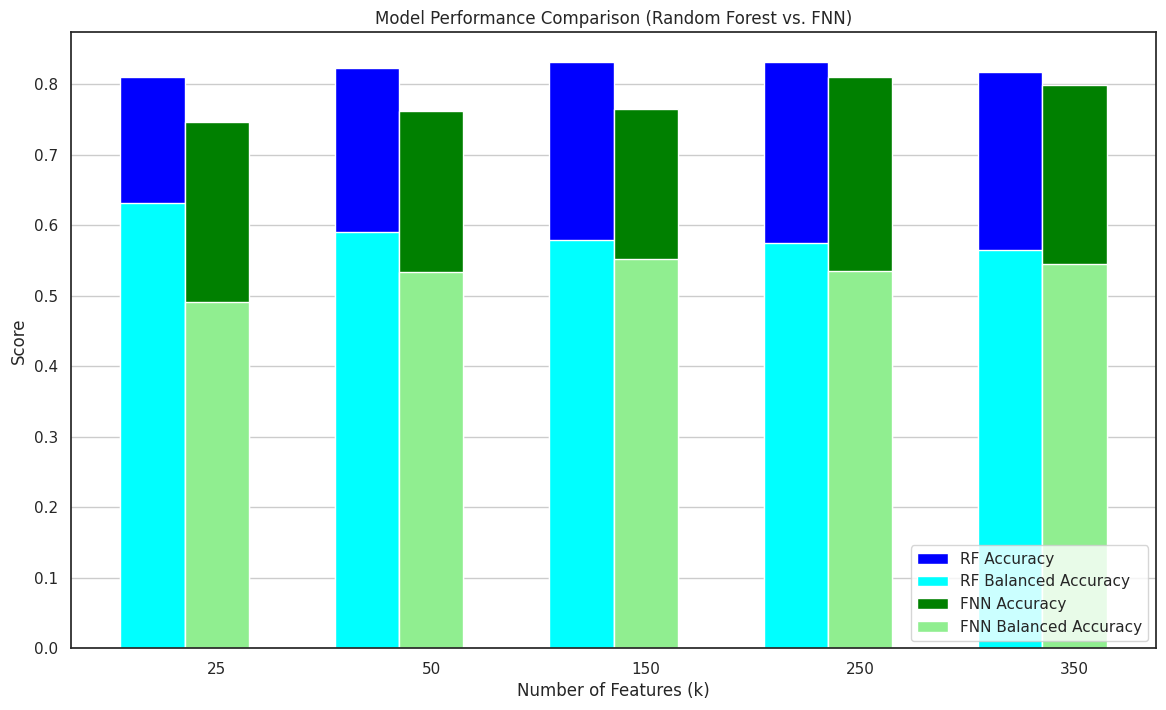

In [ ]:
#convert to df
results_df_combined = pd.DataFrame(accuracy_data_combined_c)

#get mean acc/bacc for rf across folds
avg_results_rf = results_df_combined[results_df_combined['model'] == 'Random Forest'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get mean acc/bacc for rf
avg_results_fnn = results_df_combined[results_df_combined['model'] == 'FNN'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get best mean acc/bacc results for rf
best_rf_acc_k = avg_results_rf.loc[avg_results_rf['accuracy'].idxmax(), 'k']
best_rf_bacc_k = avg_results_rf.loc[avg_results_rf['balanced_accuracy'].idxmax(), 'k']
best_rf_accuracy = avg_results_rf.loc[avg_results_rf['accuracy'].idxmax()]
best_rf_balanced_accuracy = avg_results_rf.loc[avg_results_rf['balanced_accuracy'].idxmax()]
best_rf_features_all_c = results_df_combined[(results_df_combined['model'] == 'Random Forest') & (results_df_combined['k'] == best_rf_acc_k)]['important features'].iloc[0]

#get best mean acc/bacc results for fnn
best_fnn_acc_k = avg_results_fnn.loc[avg_results_fnn['accuracy'].idxmax(), 'k']
best_fnn_bacc_k = avg_results_fnn.loc[avg_results_fnn['balanced_accuracy'].idxmax(), 'k']
best_fnn_accuracy = avg_results_fnn.loc[avg_results_fnn['accuracy'].idxmax()]
best_fnn_balanced_accuracy = avg_results_fnn.loc[avg_results_fnn['balanced_accuracy'].idxmax()]
best_fnn_features_all_c = results_df_combined[(results_df_combined['model'] == 'FNN') &  (results_df_combined['k'] == best_fnn_acc_k)]['important features'].iloc[0]

#top 20 deterministic features
best_rf_features_c = best_rf_features_all_c[:20]
best_fnn_features_c = best_fnn_features_all_c[:20]

#show best results
print("---------- Best Results ----------")
print(f"Random Forest Features: {best_rf_acc_k} (Accuracy) | {best_rf_bacc_k} (Balanced Accuracy)")
print(f"\tMean ACC: {best_rf_accuracy['accuracy']:.4f} | Mean BACC: {best_rf_balanced_accuracy['balanced_accuracy']:.4f}")
print(f"\nFNN Features: {best_fnn_acc_k} (Accuracy) | {best_fnn_bacc_k} (Balanced Accuracy)")
print(f"\tMean ACC: {best_fnn_accuracy['accuracy']:.4f} | Mean BACC: {best_fnn_balanced_accuracy['balanced_accuracy']:.4f}")
print("\n---------- Best Model Deterministic Features ----------")
print(f"Best RF Features (k={best_rf_bacc_k}):")
print(best_rf_features_c)
print(f"\nBest FNN Features (k={best_fnn_bacc_k}):")
print(best_fnn_features_c)

# plot bar graph
plt.figure(figsize=(14, 8))
bar_width = 0.3
x = np.arange(len(avg_results_rf['k']))

#rf bars
plt.bar(x - bar_width, avg_results_rf['accuracy'], width=bar_width, label='RF Accuracy', color='blue')
plt.bar(x - bar_width, avg_results_rf['balanced_accuracy'], width=bar_width, label='RF Balanced Accuracy', color='cyan')

#fnn bars
plt.bar(x, avg_results_fnn['accuracy'], width=bar_width, label='FNN Accuracy', color='green')
plt.bar(x, avg_results_fnn['balanced_accuracy'], width=bar_width, label='FNN Balanced Accuracy', color='lightgreen')

#labels
plt.xlabel('Number of Features (k)')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Random Forest vs. FNN)')
plt.xticks(x, avg_results_rf['k'])
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

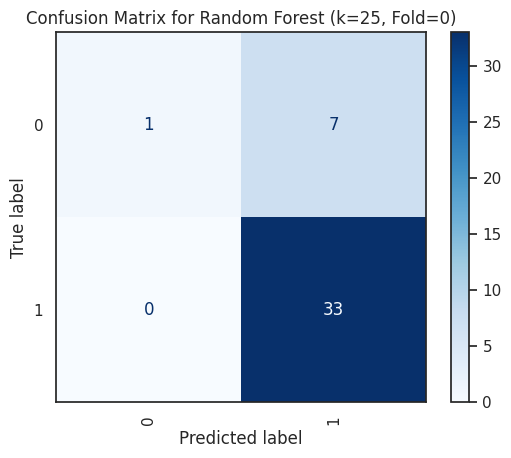

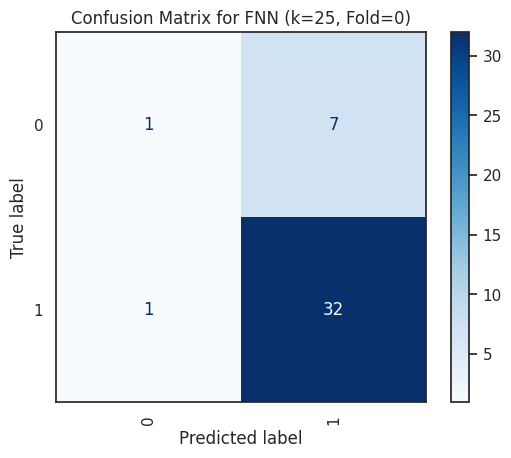

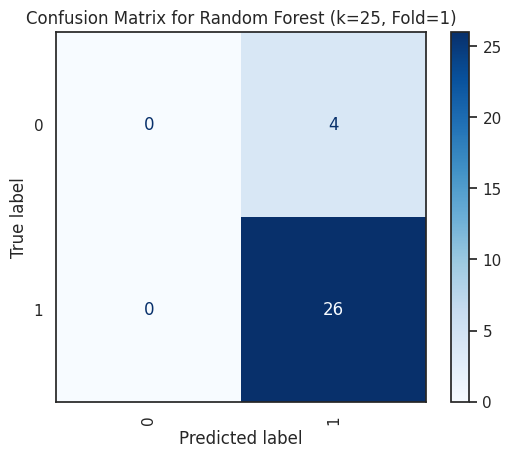

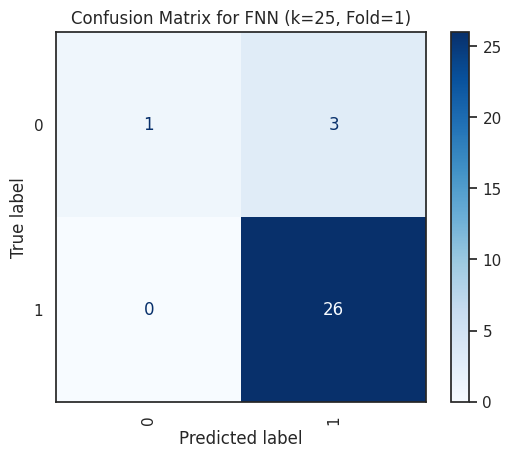

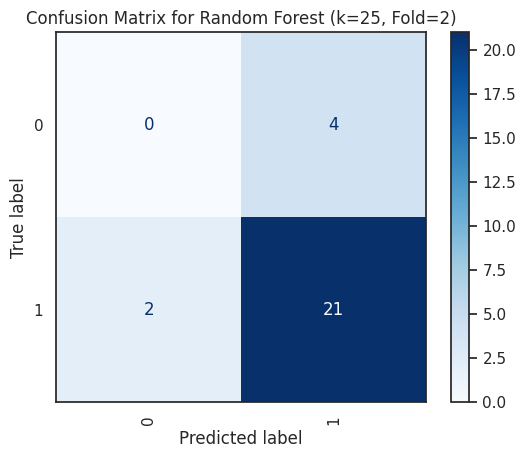

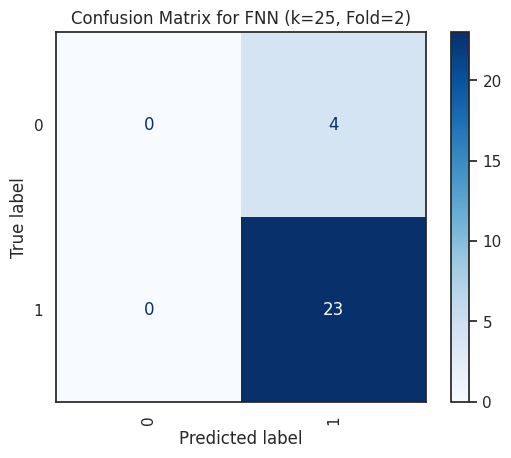

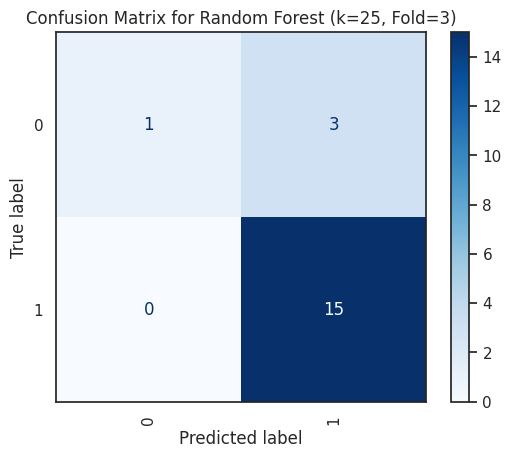

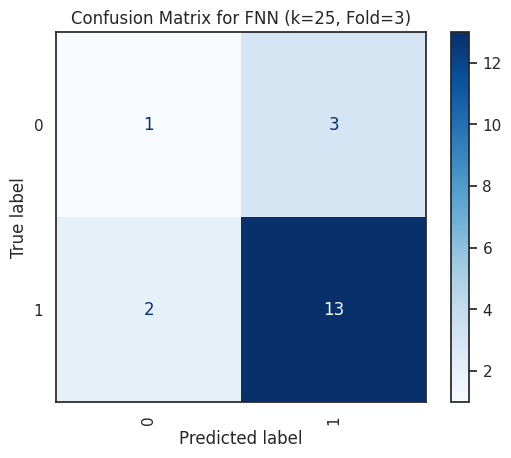

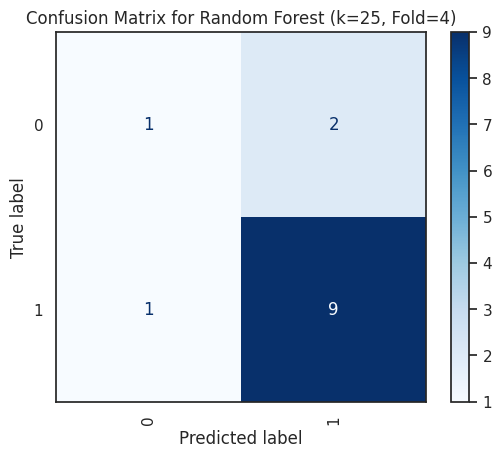

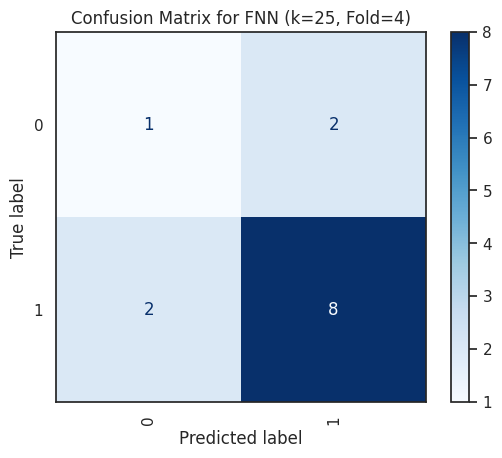

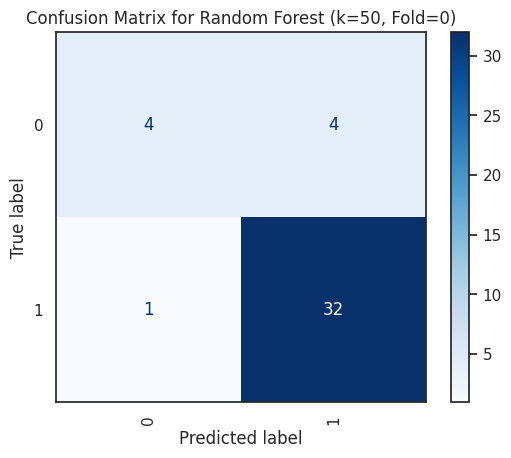

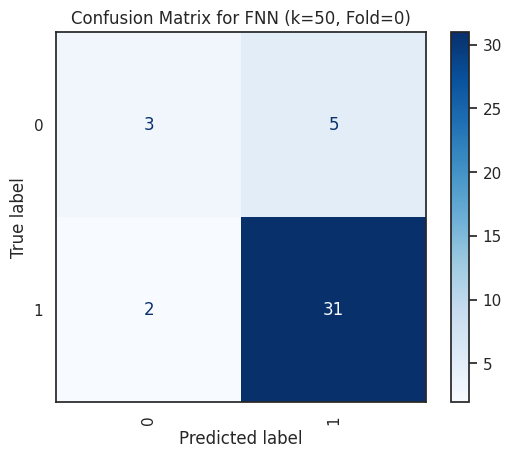

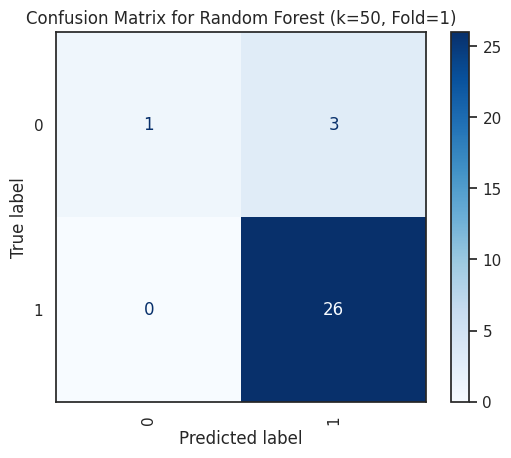

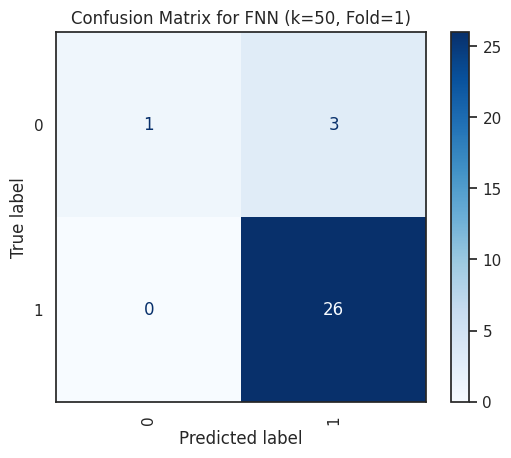

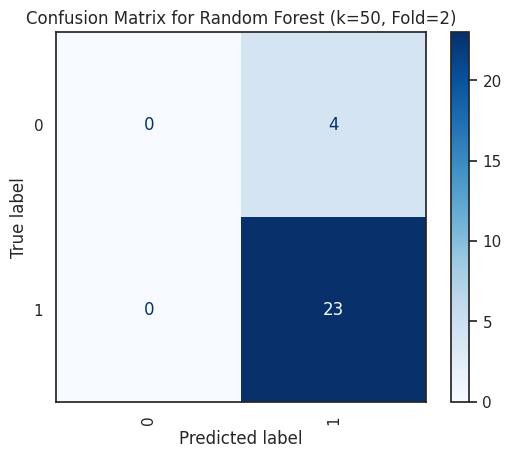

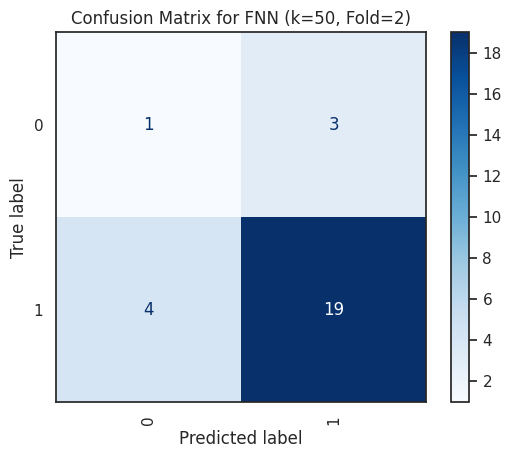

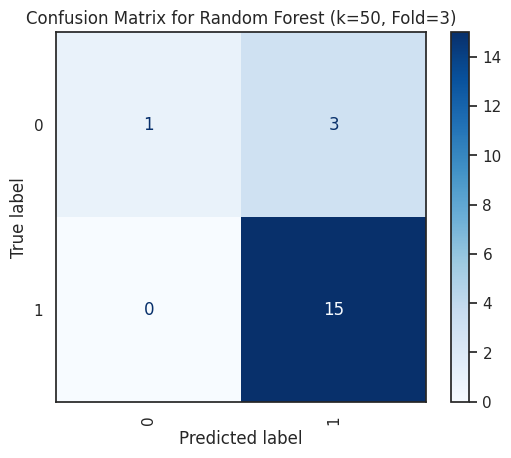

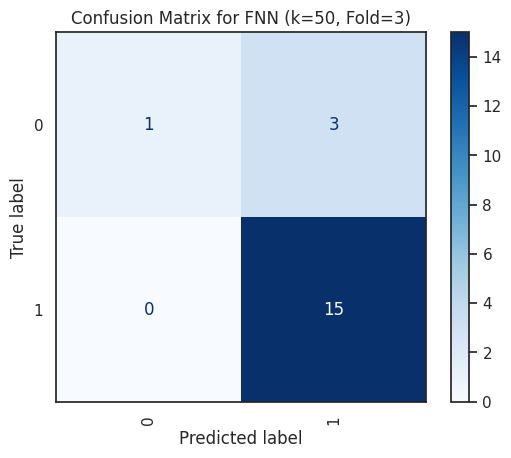

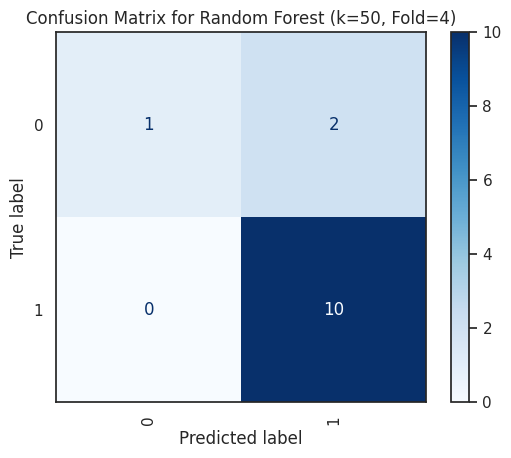

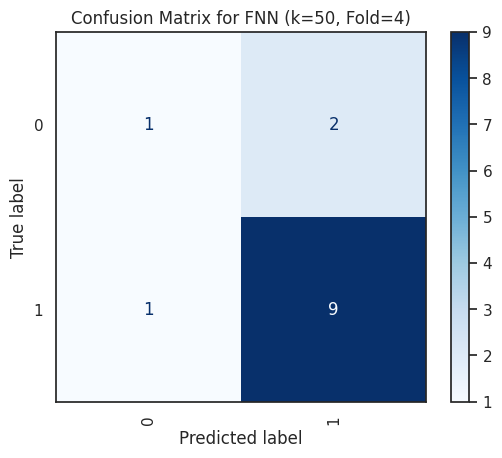

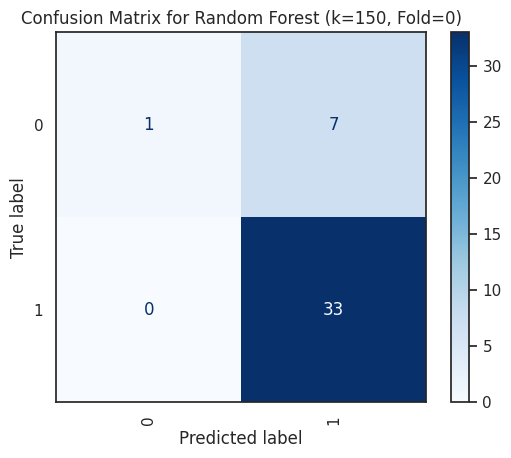

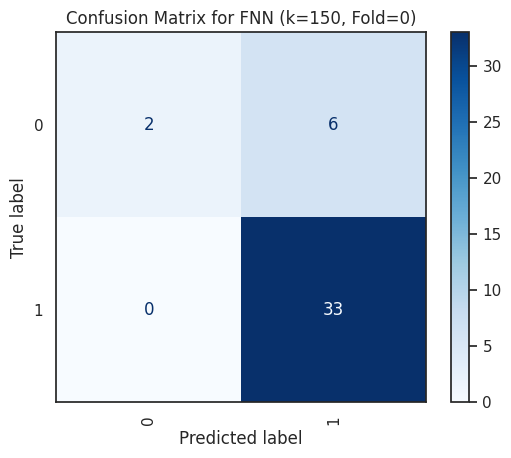

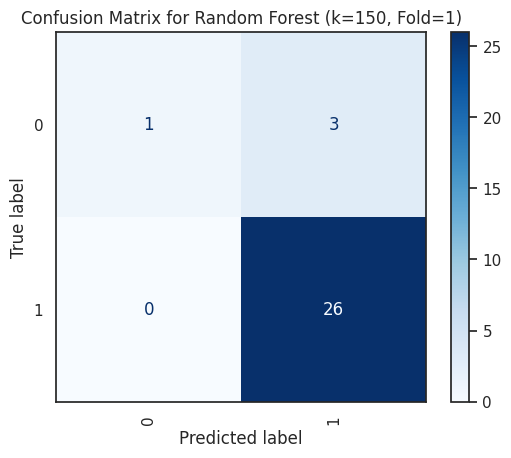

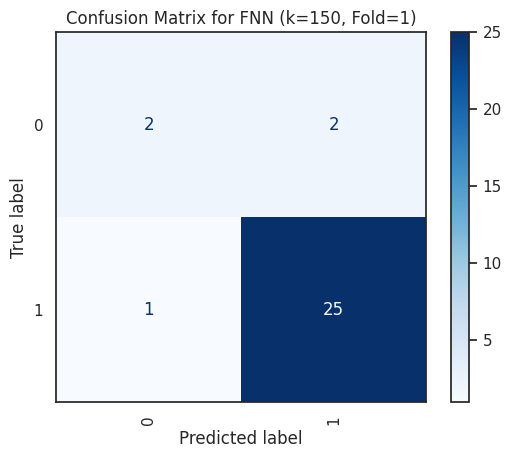

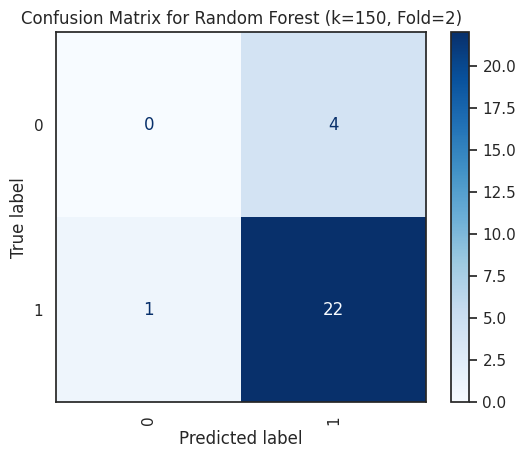

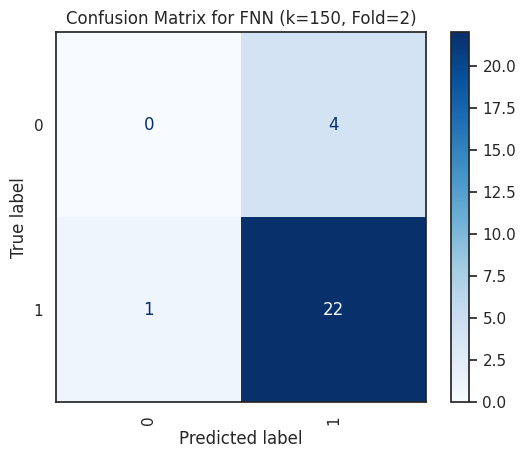

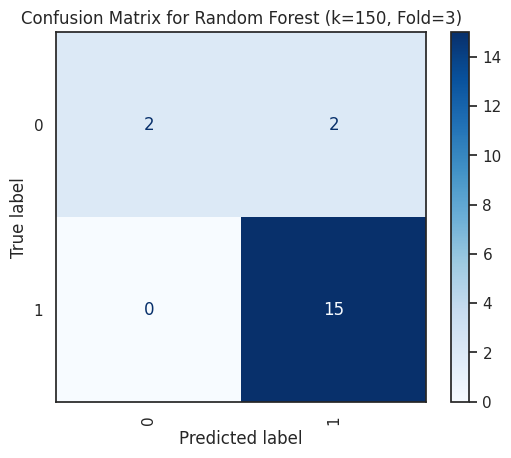

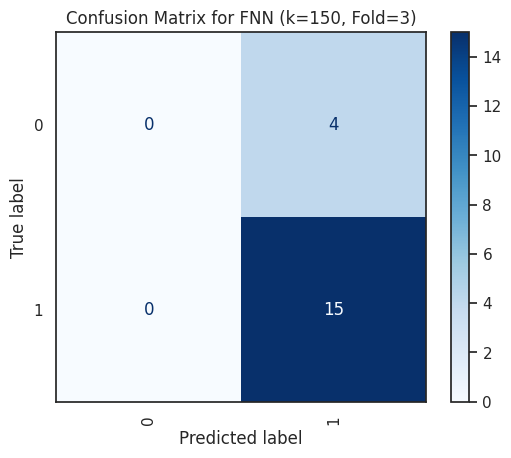

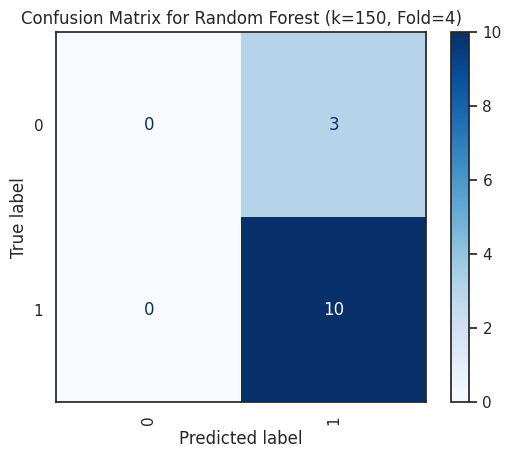

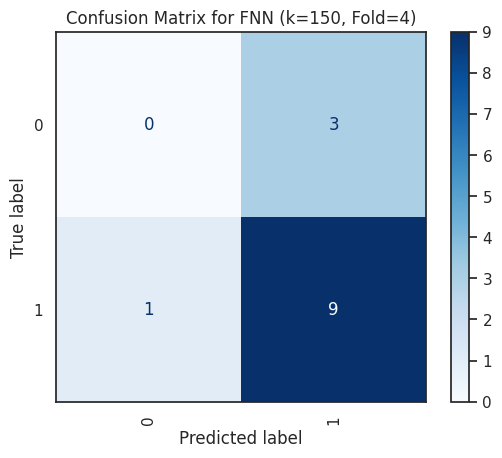

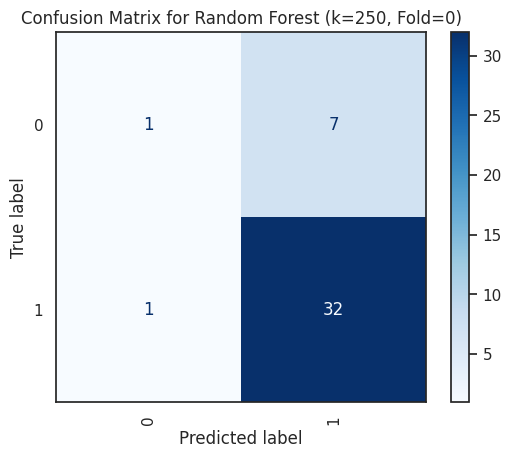

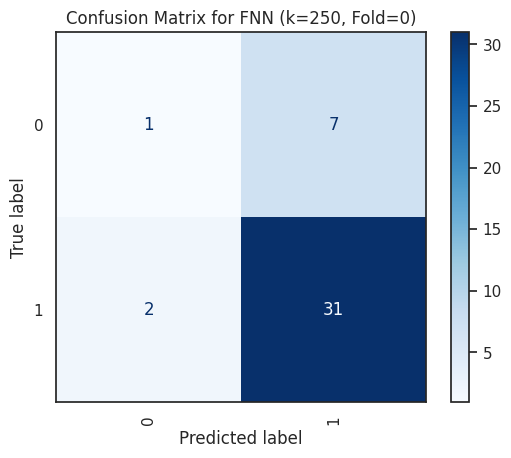

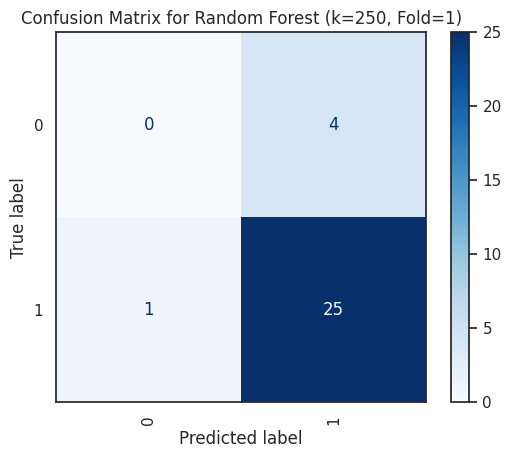

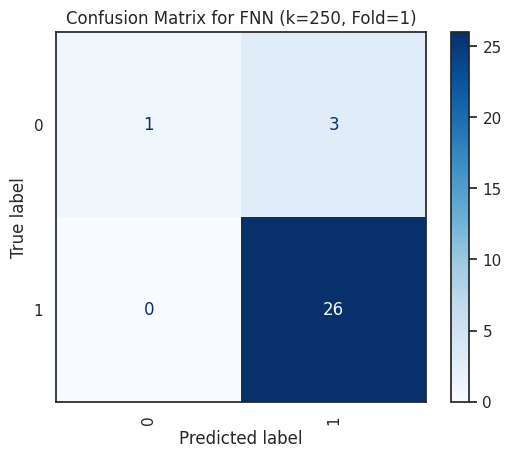

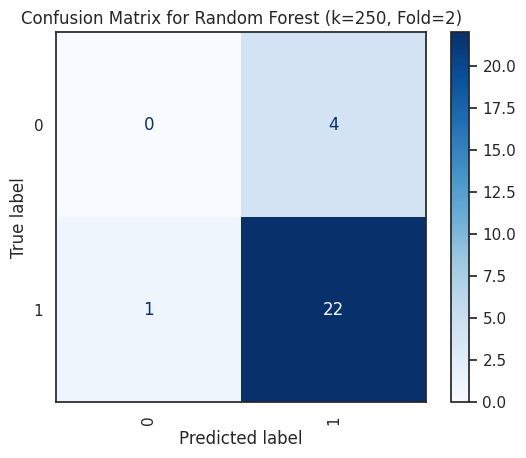

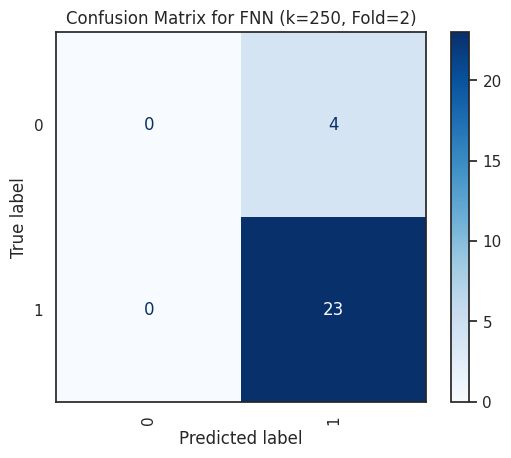

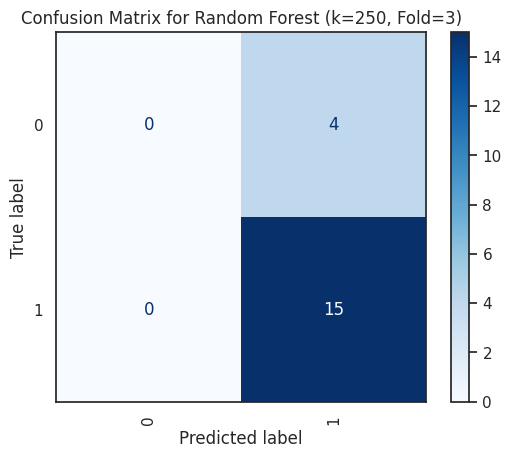

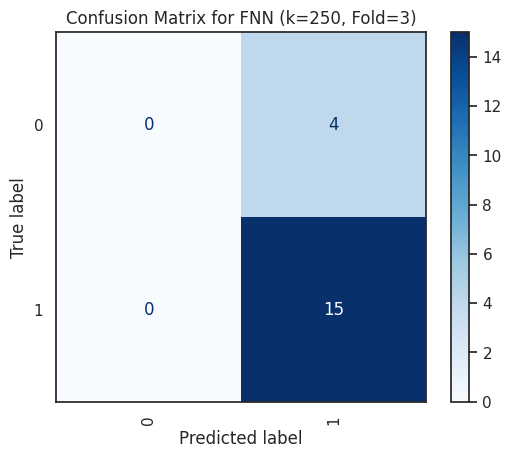

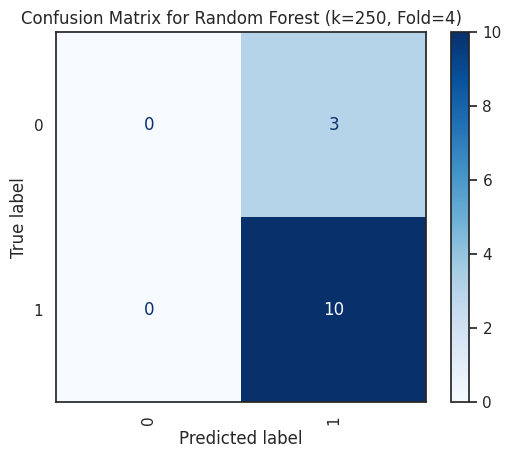

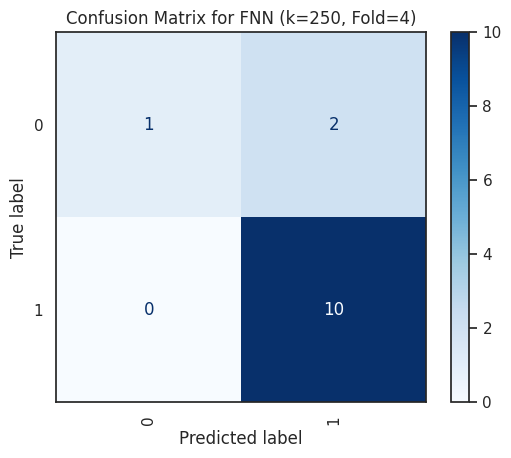

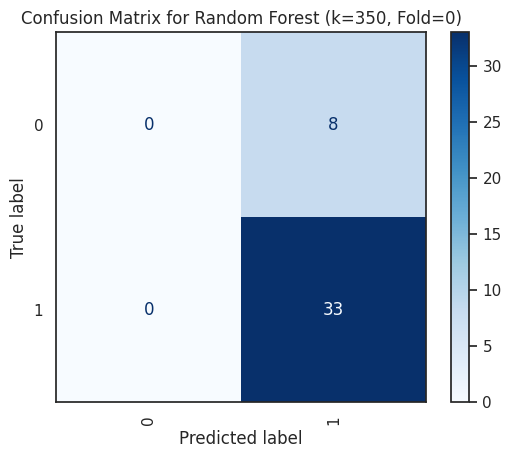

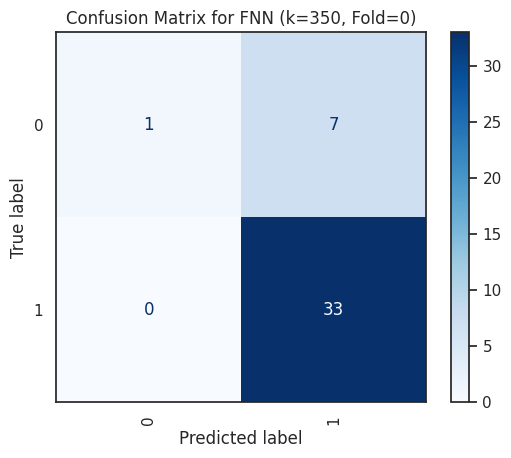

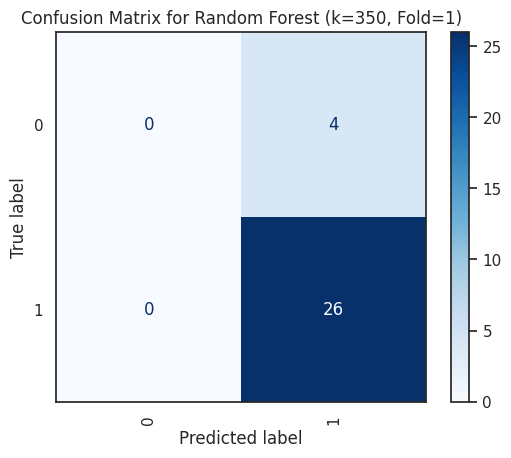

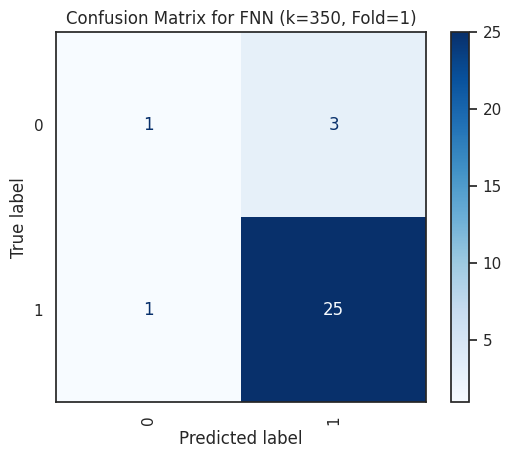

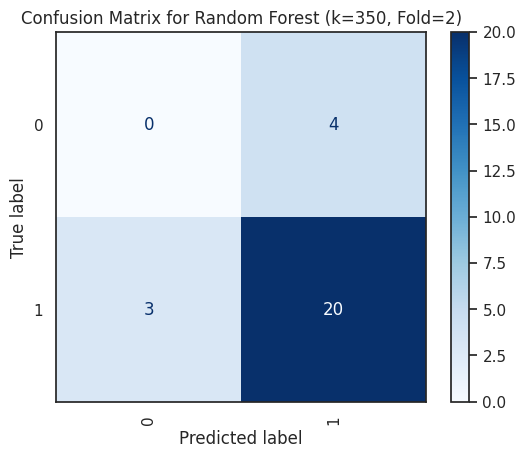

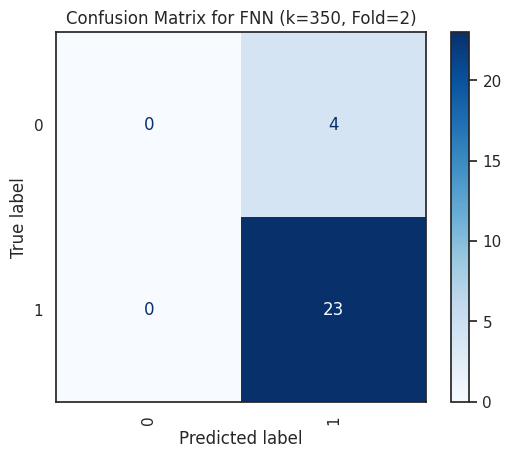

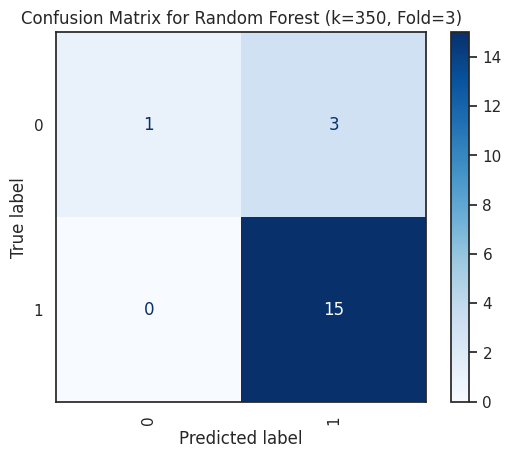

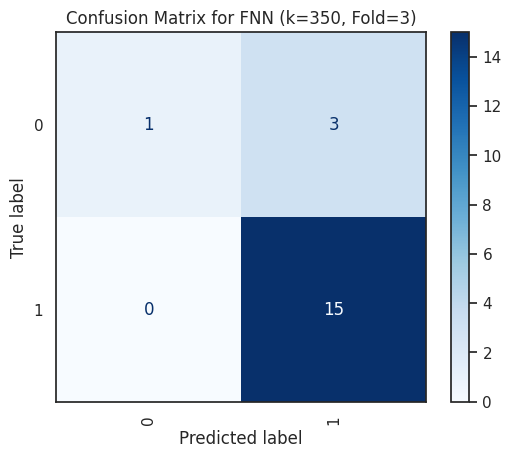

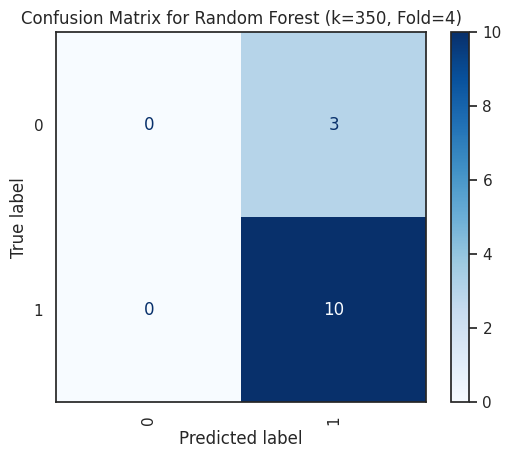

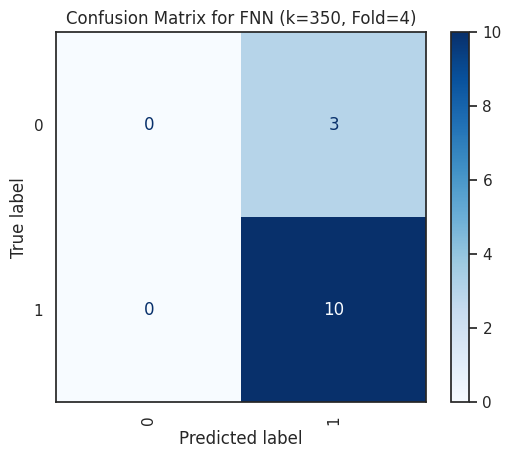

In [ ]:
#gets each data entry
for entry in accuracy_data_combined_c:
    k = entry['k']
    fold = entry['fold']
    model = entry['model']
    y_true = entry['true']
    y_pred = entry['predictions']

    #compute cm
    cm = confusion_matrix(y_true, y_pred)

    #ensure labels match the true/pred classes (sometimes fold contains all of one class)
    labels = np.unique(np.concatenate((y_true, y_pred)))

    #show cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {model} (k={k}, Fold={fold})")
    plt.show()

---------- Best Results ----------
Random Forest Features: 150 (Accuracy) | 50 (Balanced Accuracy)
	Mean ACC: 0.8569 | Mean BACC: 0.7717

FNN Features: 250 (Accuracy) | 250 (Balanced Accuracy)
	Mean ACC: 0.8171 | Mean BACC: 0.6994

---------- Best Model Deterministic Features ----------
Best RF Features (k=50):
[(0.0430524416395746, '23'), (0.028244970765142107, '722'), (0.025405227714245016, 'having'), (0.023986340901732336, 'Answer Time'), (0.0206067237745402, '224'), (0.020532144568743374, 'Answer WC'), (0.019365218507119305, '741'), (0.019061817715227105, '205'), (0.018454530272181472, '302'), (0.01823244869975251, '667'), (0.017829820256257747, '411'), (0.017002585986950654, 'big'), (0.016448945689201508, '20.1'), (0.014765235743253056, '461'), (0.014745993630486018, '8'), (0.013265629241960276, '46'), (0.01284197566056494, '431'), (0.012218538378811263, '383'), (0.012013155523315538, '542'), (0.011428446127550462, '275')]

Best FNN Features (k=250):
[(52.80452, 'Answer Time'), (5

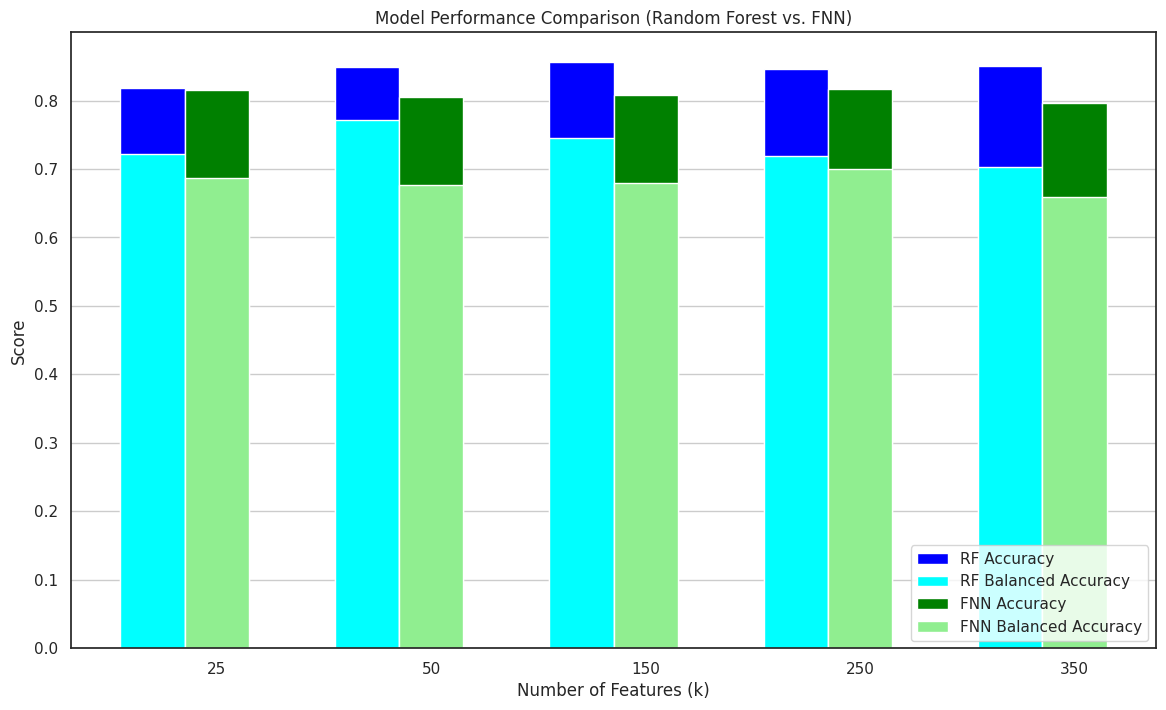

In [ ]:
#convert to df
results_df_combined_d = pd.DataFrame(accuracy_data_combined_d)

#get mean acc/bacc for rf across folds
avg_results_rf_d = results_df_combined_d[results_df_combined_d['model'] == 'Random Forest'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get mean acc/bacc for rf
avg_results_fnn_d = results_df_combined_d[results_df_combined_d['model'] == 'FNN'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get best mean acc/bacc results
best_rf_acc_k_d = avg_results_rf_d.loc[avg_results_rf_d['accuracy'].idxmax(), 'k']
best_rf_bacc_k_d = avg_results_rf_d.loc[avg_results_rf_d['balanced_accuracy'].idxmax(), 'k']
best_rf_accuracy_d = avg_results_rf_d.loc[avg_results_rf_d['accuracy'].idxmax()]
best_rf_balanced_accuracy_d = avg_results_rf_d.loc[avg_results_rf_d['balanced_accuracy'].idxmax()]
best_rf_features_all_d = results_df_combined_d[(results_df_combined_d['model'] == 'Random Forest') & (results_df_combined_d['k'] == best_rf_acc_k_d)]['important features'].iloc[0]

#get best mean acc/bacc results for fnn
best_fnn_acc_k_d = avg_results_fnn_d.loc[avg_results_fnn_d['accuracy'].idxmax(), 'k']
best_fnn_bacc_k_d = avg_results_fnn_d.loc[avg_results_fnn_d['balanced_accuracy'].idxmax(), 'k']
best_fnn_accuracy_d = avg_results_fnn_d.loc[avg_results_fnn_d['accuracy'].idxmax()]
best_fnn_balanced_accuracy_d = avg_results_fnn_d.loc[avg_results_fnn_d['balanced_accuracy'].idxmax()]
best_fnn_features_all_d = results_df_combined_d[(results_df_combined_d['model'] == 'FNN') &  (results_df_combined_d['k'] == best_fnn_acc_k_d)]['important features'].iloc[0]

#top 20 deterministic features
best_rf_features_d = best_rf_features_all_d[:20]
best_fnn_features_d = best_fnn_features_all_d[:20]

#show best results
print("---------- Best Results ----------")
print(f"Random Forest Features: {best_rf_acc_k_d} (Accuracy) | {best_rf_bacc_k_d} (Balanced Accuracy)")
print(f"\tMean ACC: {best_rf_accuracy_d['accuracy']:.4f} | Mean BACC: {best_rf_balanced_accuracy_d['balanced_accuracy']:.4f}")
print(f"\nFNN Features: {best_fnn_acc_k_d} (Accuracy) | {best_fnn_bacc_k_d} (Balanced Accuracy)")
print(f"\tMean ACC: {best_fnn_accuracy_d['accuracy']:.4f} | Mean BACC: {best_fnn_balanced_accuracy_d['balanced_accuracy']:.4f}")
print("\n---------- Best Model Deterministic Features ----------")
print(f"Best RF Features (k={best_rf_bacc_k_d}):")
print(best_rf_features_d)
print(f"\nBest FNN Features (k={best_fnn_bacc_k_d}):")
print(best_fnn_features_d)


# plot bar graph
plt.figure(figsize=(14, 8))
bar_width = 0.3
x = np.arange(len(avg_results_rf_d['k']))

#rf bars
plt.bar(x - bar_width, avg_results_rf_d['accuracy'], width=bar_width, label='RF Accuracy', color='blue')
plt.bar(x - bar_width, avg_results_rf_d['balanced_accuracy'], width=bar_width, label='RF Balanced Accuracy', color='cyan')

#fnn bars
plt.bar(x, avg_results_fnn_d['accuracy'], width=bar_width, label='FNN Accuracy', color='green')
plt.bar(x, avg_results_fnn_d['balanced_accuracy'], width=bar_width, label='FNN Balanced Accuracy', color='lightgreen')

#labels
plt.xlabel('Number of Features (k)')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Random Forest vs. FNN)')
plt.xticks(x, avg_results_rf_d['k'])
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

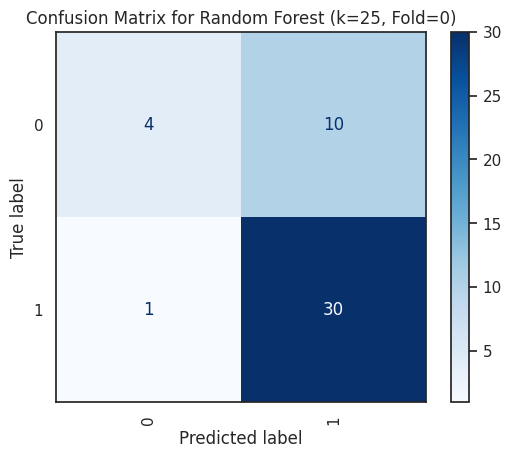

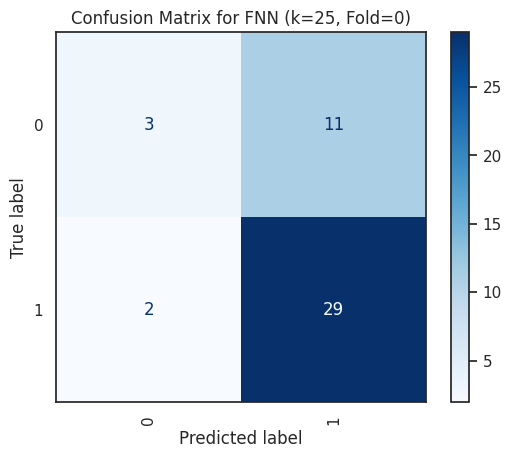

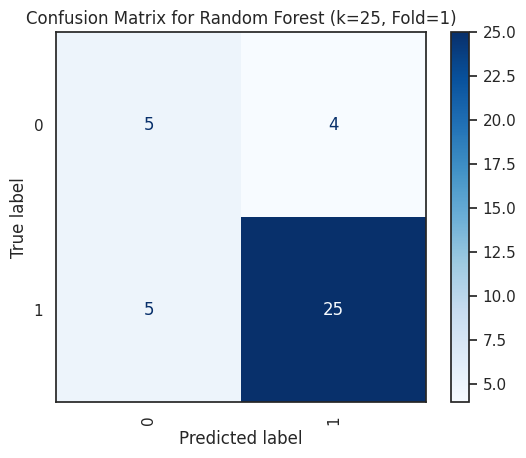

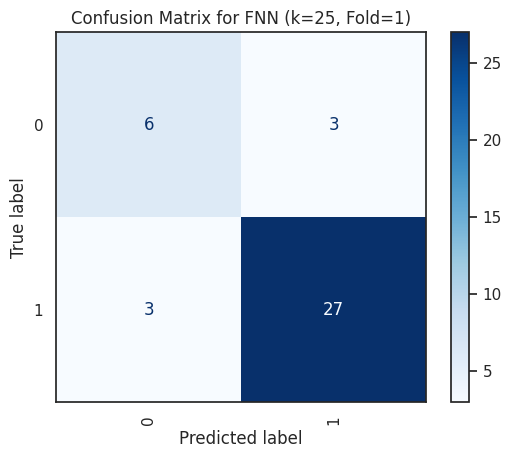

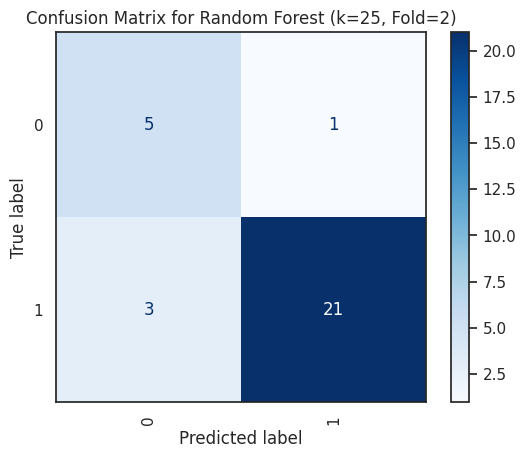

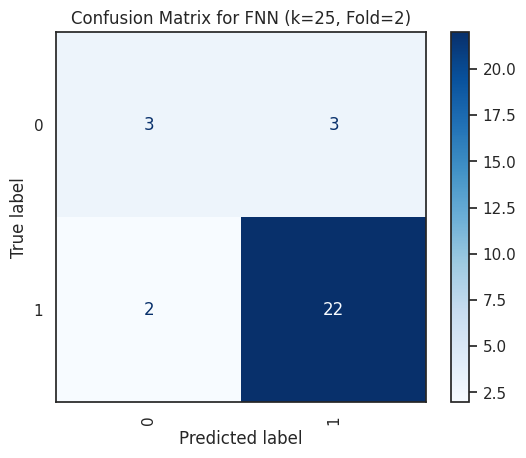

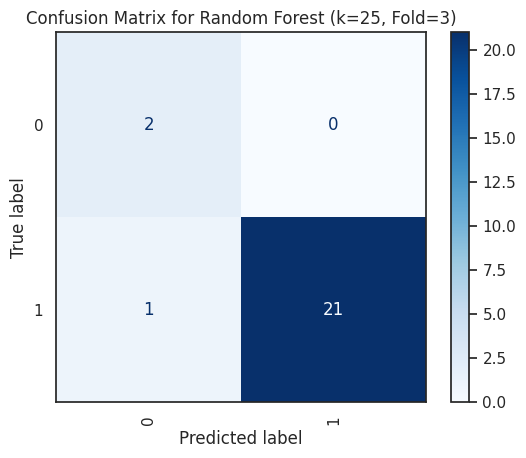

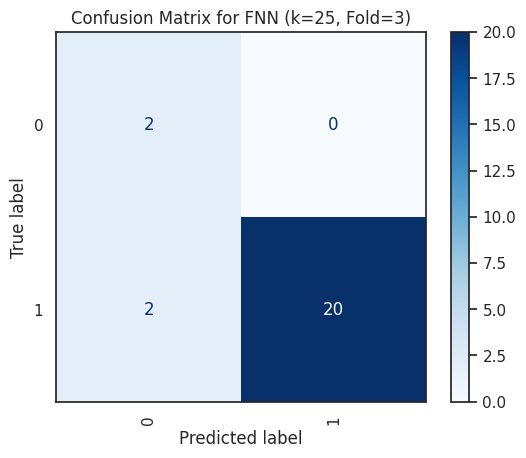

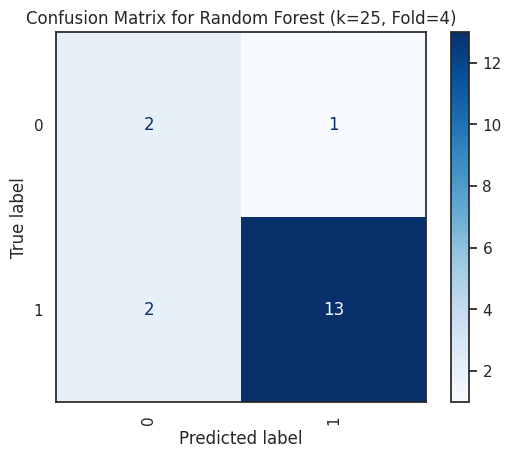

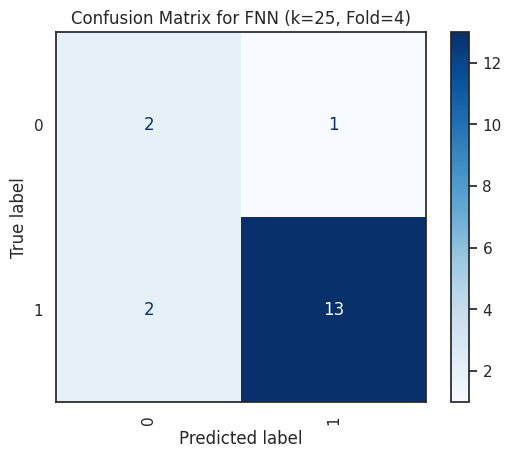

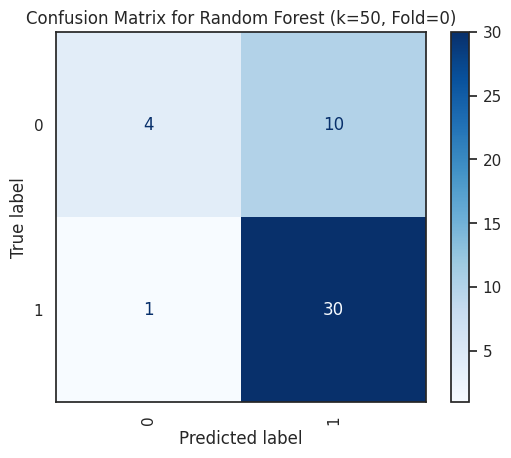

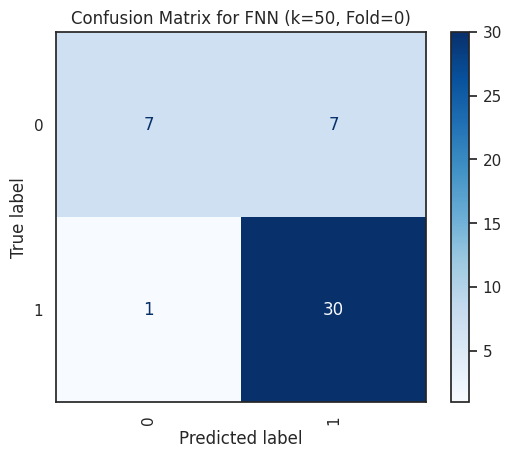

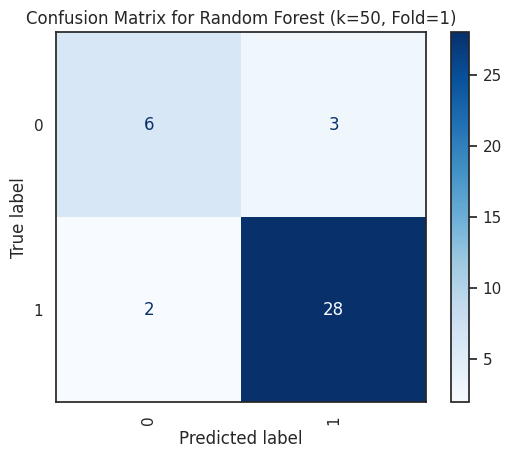

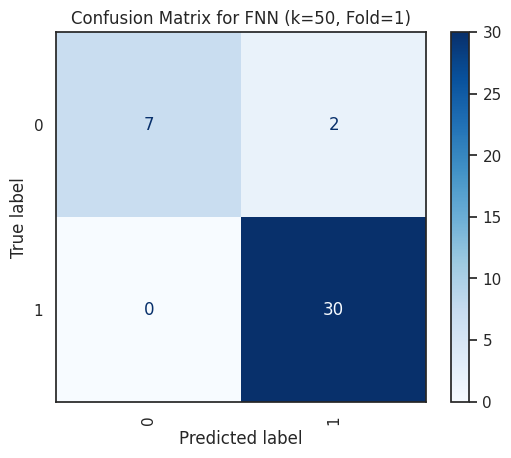

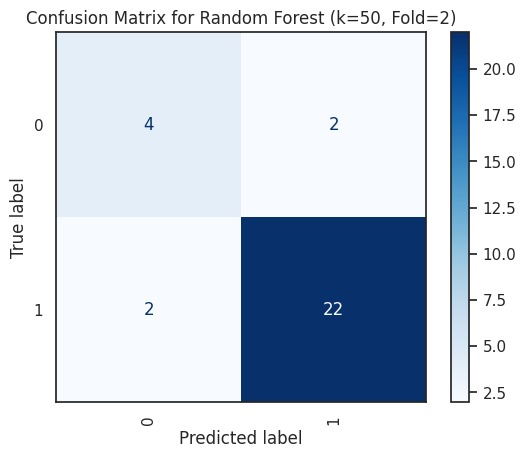

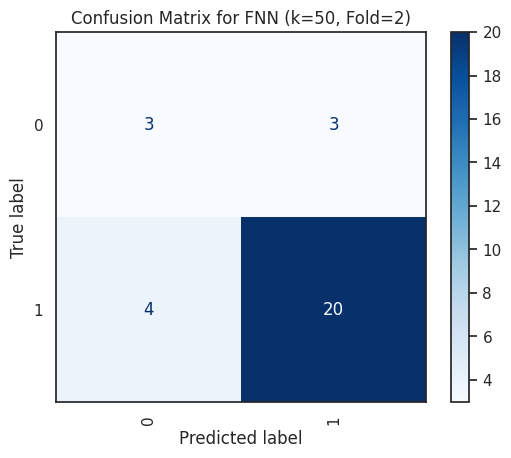

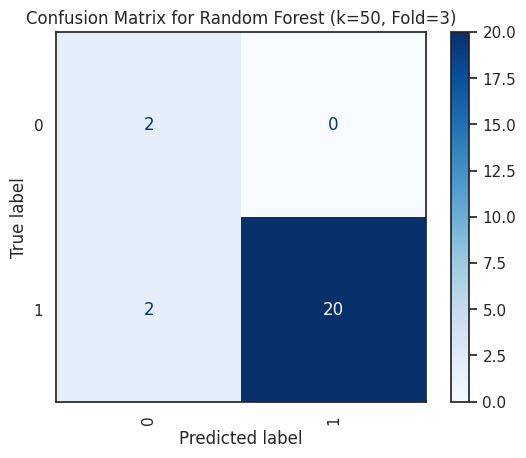

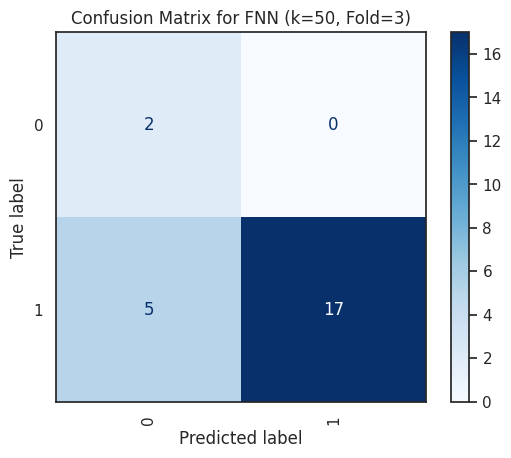

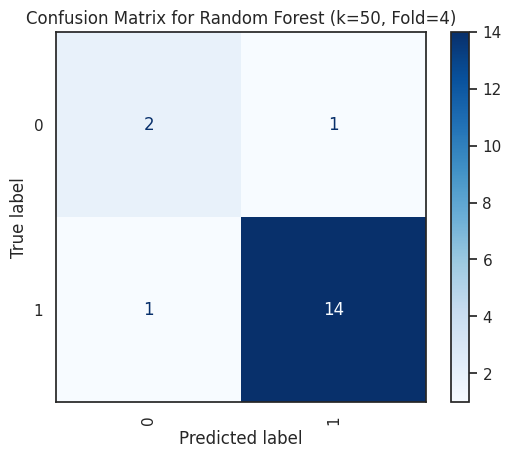

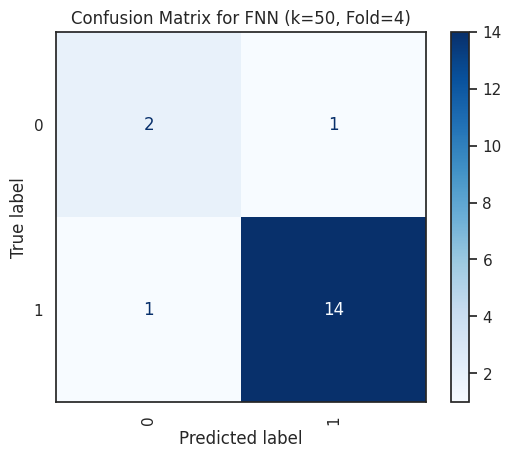

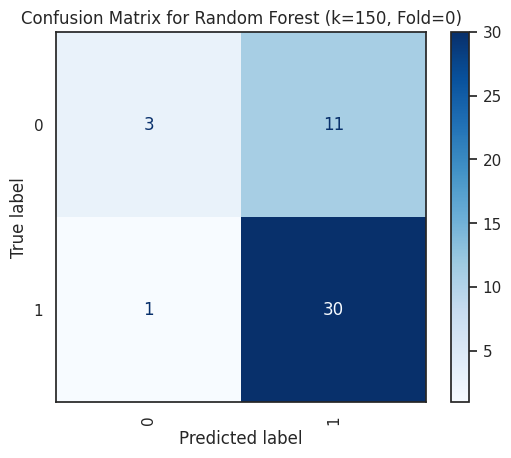

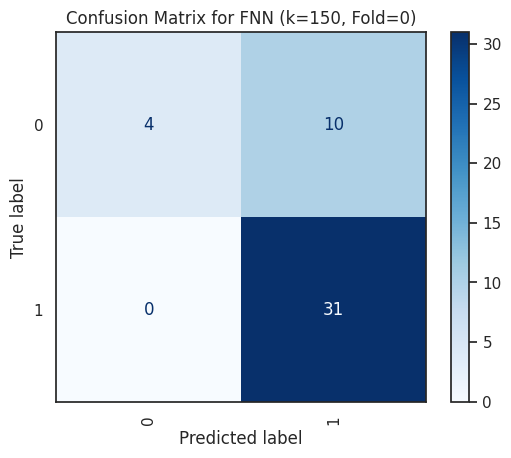

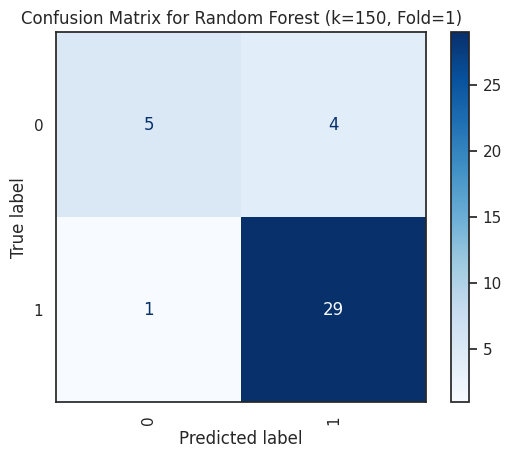

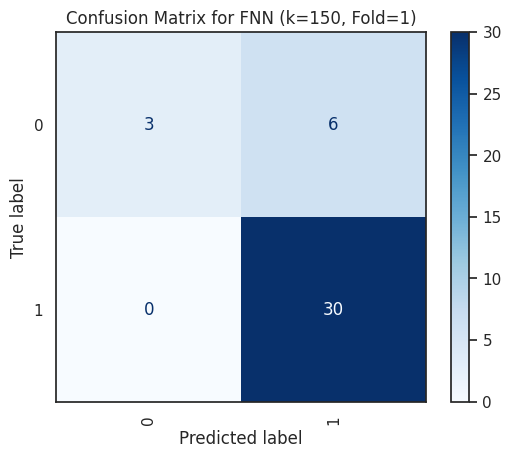

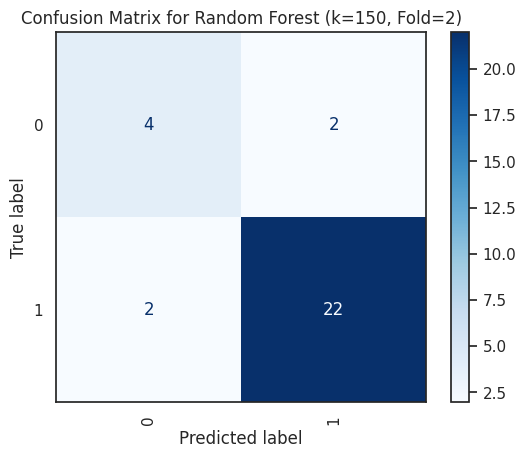

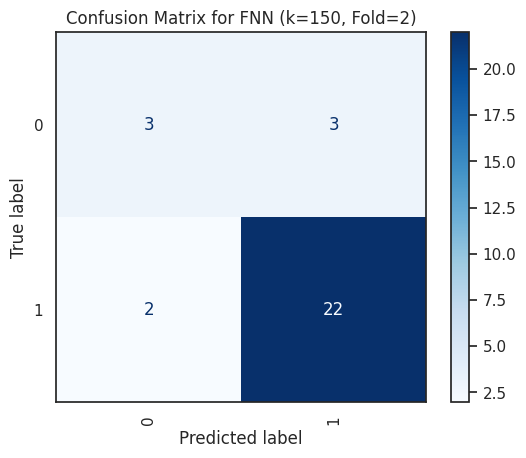

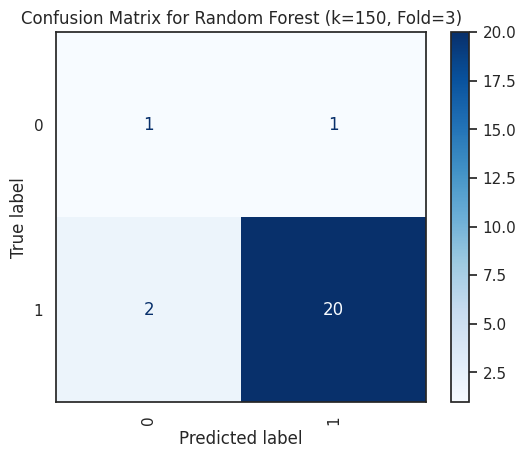

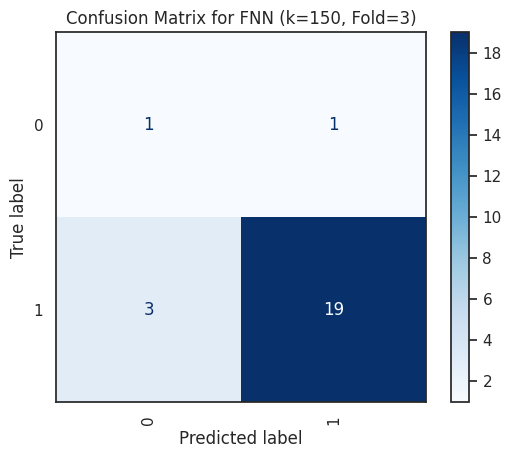

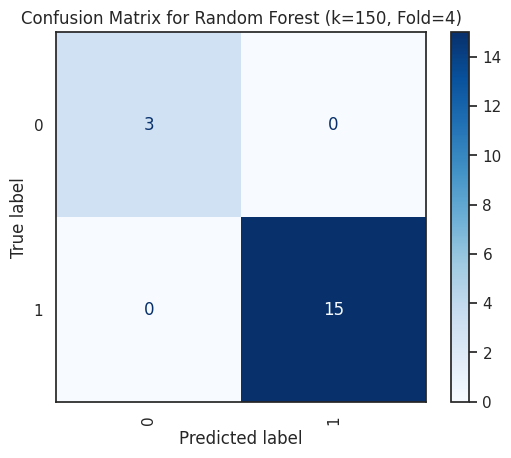

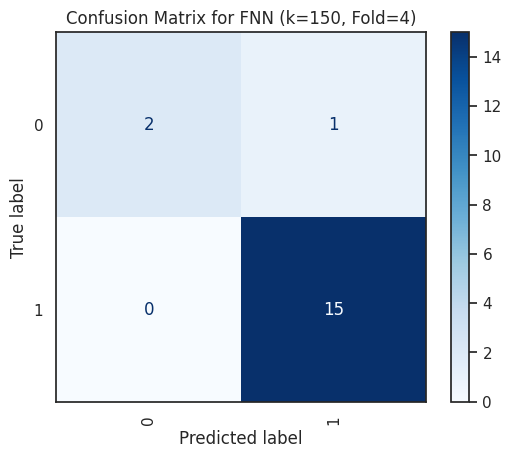

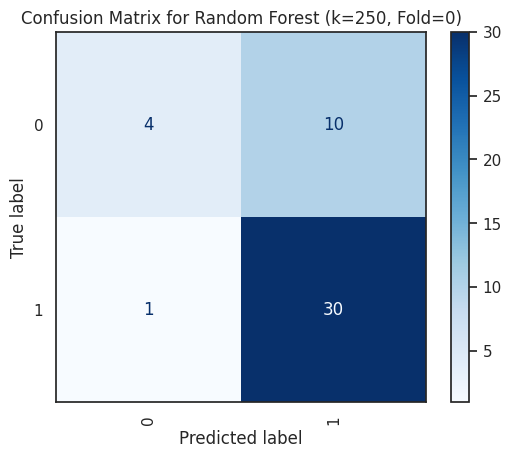

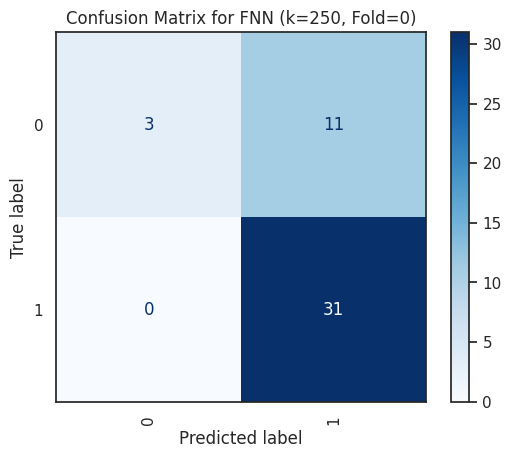

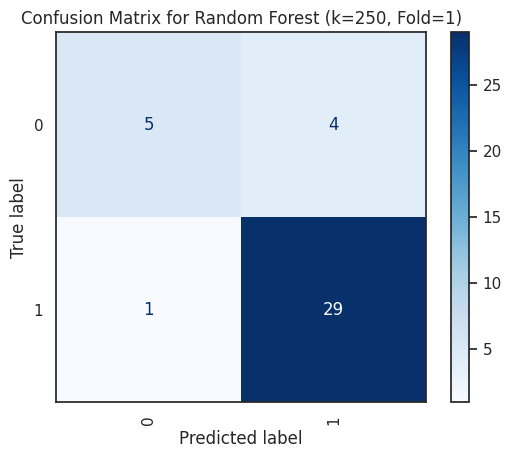

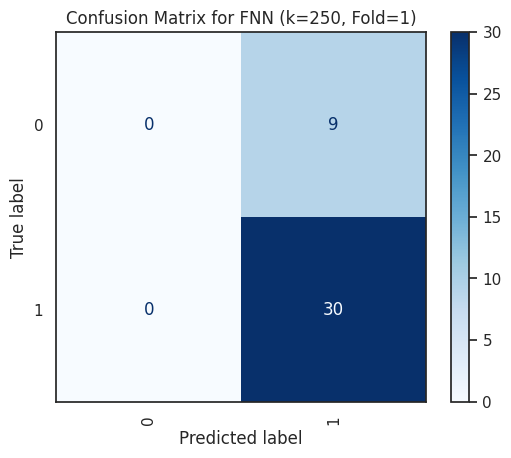

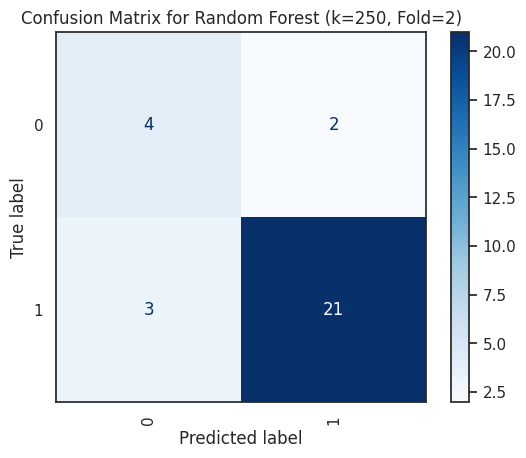

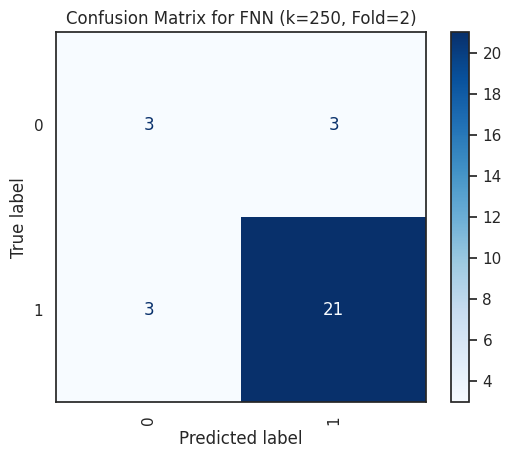

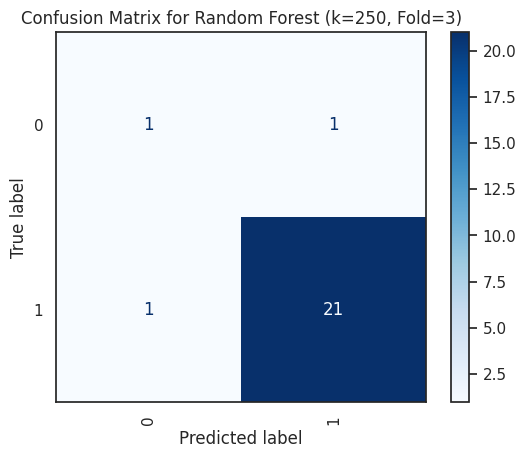

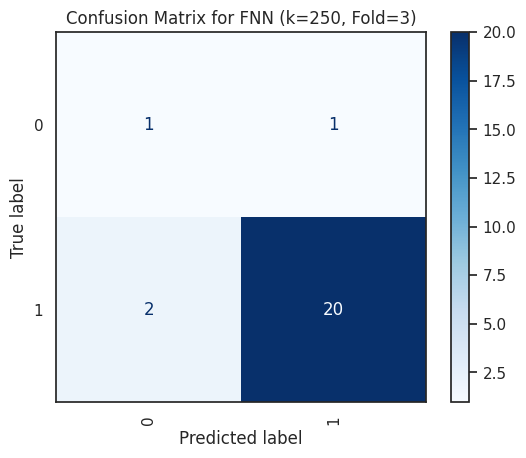

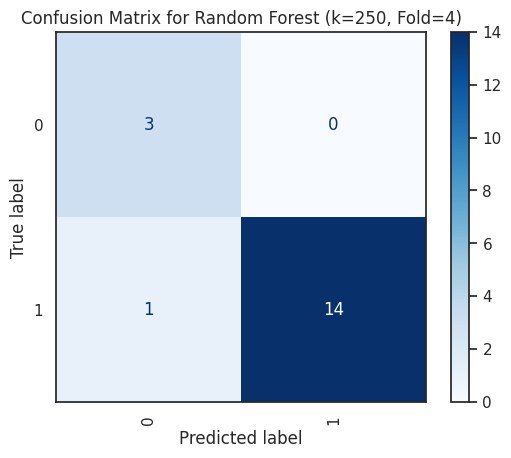

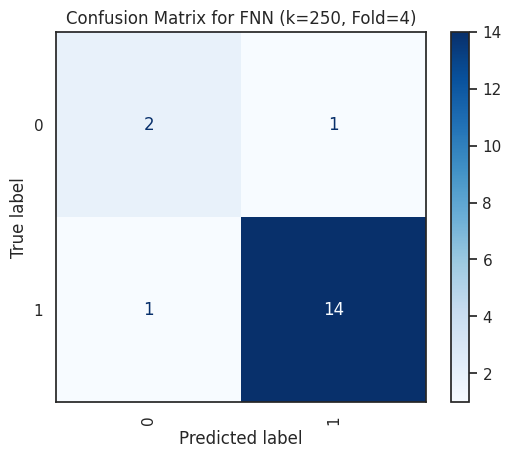

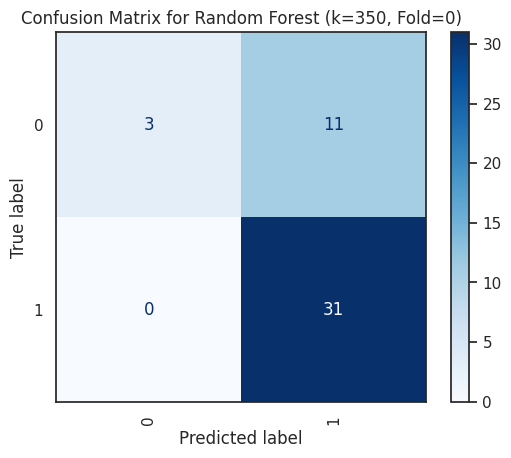

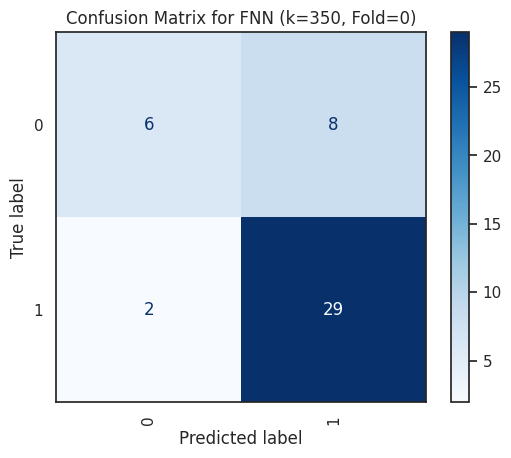

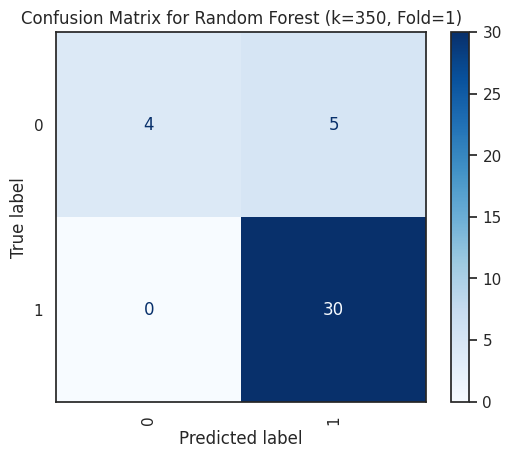

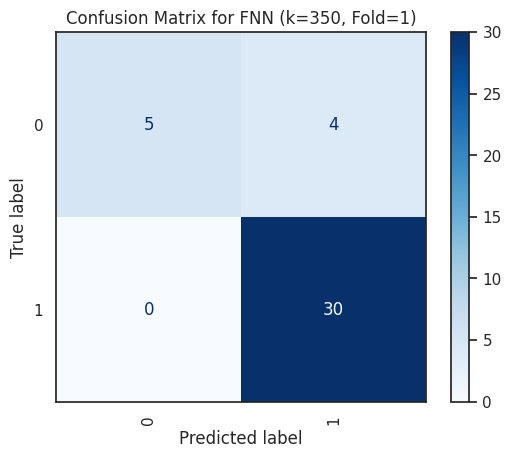

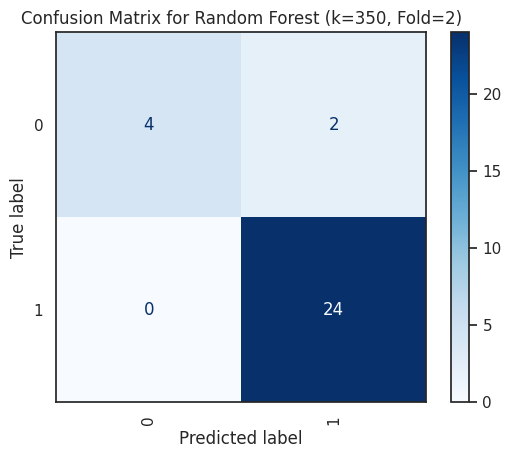

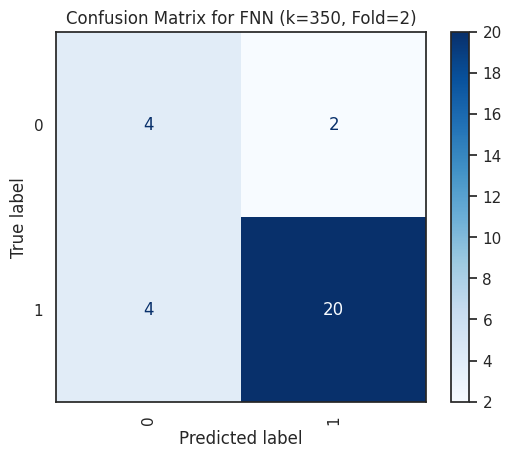

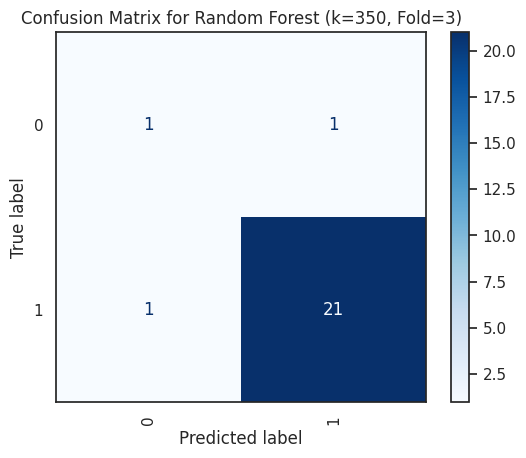

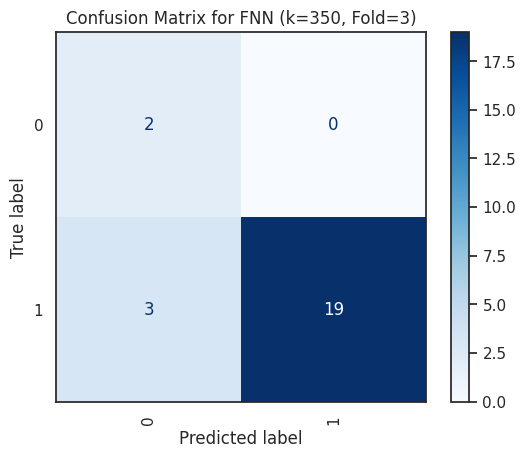

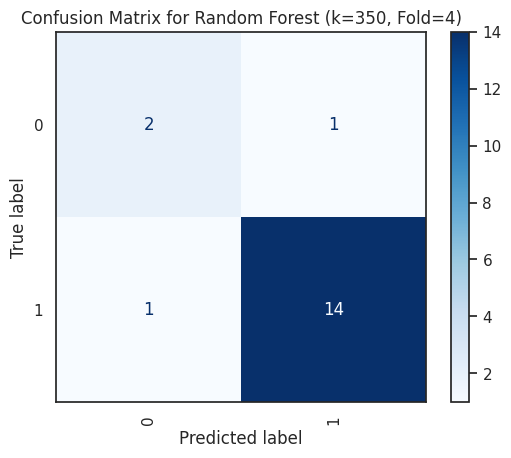

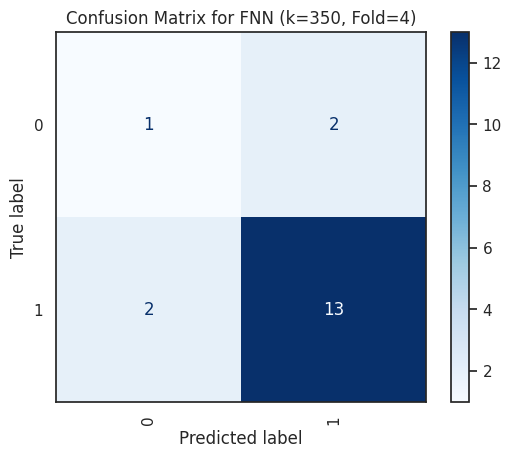

In [ ]:
#gets each data entry
for entry in accuracy_data_combined_d:
    k = entry['k']
    fold = entry['fold']
    model = entry['model']
    y_true = entry['true']
    y_pred = entry['predictions']

    #compute cm
    cm = confusion_matrix(y_true, y_pred)

    #ensure labels match the true/pred classes (sometimes fold contains all of one class)
    labels = np.unique(np.concatenate((y_true, y_pred)))

    #show cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {model} (k={k}, Fold={fold})")
    plt.show()

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

###**Part E**

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
label_encoder_c = LabelEncoder()
part_c_df['PID'] = label_encoder_c.fit_transform(part_c_df['PID'])
num_speakers_c = len(label_encoder_c.classes_)

# label encode the PID column for part d
label_encoder_d = LabelEncoder()
part_d_df['PID'] = label_encoder_d.fit_transform(part_d_df['PID'])
num_speakers_d = len(label_encoder_d.classes_)

# number of folds
num_folds = 5

# generates folds, ensuring label encoding is correct within each fold
def create_folds(dataframe, num_folds, label_encoder):
    # create an empty list to store folds
    folds = [[] for _ in range(num_folds)]

    # group by PID
    grouped = dataframe.groupby('PID')

    # distribute QIDs into folds randomly
    for pid, group in grouped:
        qids = group['QID'].tolist()
        random.shuffle(qids)
        for i, qid in enumerate(qids):
            # assign QIDs to folds in a round-robin fashion
            folds[i % num_folds].append(group[group['QID'] == qid])

    # concatenate rows within each fold and re-encode PID within each fold
    fold_dfs = [pd.concat(fold).reset_index(drop=True) for fold in folds]
    for fold_df in fold_dfs:
        fold_df['PID'] = label_encoder.fit_transform(fold_df['PID'])  # Re-encode within fold

    return fold_dfs

# create folds for both tasks, using the appropriate label encoder for each
fold_dfs_c = create_folds(part_c_df, num_folds, label_encoder_c)
fold_dfs_d = create_folds(part_d_df, num_folds, label_encoder_d)


In [ ]:
def train_adversary(X_train, y_adversary, X_val, y_adversary_val, num_speakers):
    adversary = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_speakers, activation='softmax')
    ])

    # compile adversary
    adversary.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # train adversary
    adversary.fit(X_train, y_adversary, epochs=10, batch_size=32, validation_data=(X_val, y_adversary_val), verbose=0)

    return adversary

In [ ]:
# number of features
k_values = [25, 50, 150, 250, 350]
total = len(k_values) * len(fold_dfs_c)

# get bert columns
bert_columns_c = part_c_df.columns[1014:]

# accuracy data for part c and part d
accuracy_data_combined_c = []

# speaker-dependent features
speaker_dependent_features = list(set(sorted_xgb_features[:20] + sorted_fnn_features[:20]))


#-------------------- part c --------------------
for k in k_values:
    # compute mi and select features for part c
    selected_features_c = compute_mi_and_select_features(part_c_df, k_tfidf=k, k_sentiment=4, k_bert=k, k_other=6)

    # remove speaker-dependent features
    selected_features_c = [f for f in selected_features_c if f not in speaker_dependent_features]

    for i in range(len(fold_dfs_c)):
        print(f'remaining iterations: {total}')
        total -= 1

        # split train/val
        train_df_c = pd.concat(fold_dfs_c[:i] + fold_dfs_c[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df_c = fold_dfs_c[i].sample(frac=1).reset_index(drop=True)

        # prepare datasets
        train_data_c = prepare_dataset(train_df_c, selected_features_c)
        val_data_c = prepare_dataset(val_df_c, selected_features_c)

        # separate features and labels
        X_train_c = train_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_train_c = train_data_c['Degree of Explanation']
        X_val_c = val_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_val_c = val_data_c['Degree of Explanation']

        # prepare adversary labels
        y_adversary_c = train_data_c['PID'].astype(int).to_numpy()
        y_adversary_val_c = val_data_c['PID'].astype(int).to_numpy()

        # scale features
        scaler = StandardScaler()
        X_train_c = scaler.fit_transform(X_train_c)
        X_val_c = scaler.transform(X_val_c)

        # smote to oversample
        smote = SMOTE()
        X_train_c_balanced, y_train_c_balanced = smote.fit_resample(X_train_c, y_train_c)

        # train adversary
        adversary_c = train_adversary(X_train_c, y_adversary_c, X_val_c, y_adversary_val_c, num_speakers_c)
        adversary_accuracy_c = adversary_c.evaluate(X_val_c, y_adversary_val_c, verbose=0)[1]

        # run rf
        rf_acc_c, rf_bacc_c, rf_y_pred_c, rf_model = random_forest_model(X_train_c_balanced, y_train_c_balanced, X_val_c, y_val_c)

        feature_importances = rf_model.feature_importances_
        feature_names = train_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).columns
        important_features = sorted(zip(feature_importances, feature_names), reverse=True)

        # store rf results
        accuracy_data_combined_c.append({
            'model': 'Random Forest',
            'k': k,
            'fold': i,
            'accuracy': rf_acc_c,
            'balanced_accuracy': rf_bacc_c,
            'adversary_accuracy': adversary_accuracy_c,
            'predictions': rf_y_pred_c.tolist(),
            'important features': important_features,
            'true': y_val_c.tolist(),
        })

        # run fnn
        fnn_acc_c, fnn_bacc_c, fnn_y_pred_c, model = fnn_model_1(X_train_c, y_train_c, X_val_c, y_val_c)

        # get abs fnn weights
        input_layer_weights = model.layers[0].get_weights()[0]  # Weights from input to first hidden layer
        feature_importance_fnn = np.sum(np.abs(input_layer_weights), axis=1)

        # map importance scores to feature names
        importance_scores = zip(feature_importance_fnn, feature_names)
        sorted_importance = sorted(importance_scores, key=lambda x: x[0], reverse=True)

        # store fnn results
        accuracy_data_combined_c.append({
            'model': 'FNN',
            'k': k,
            'fold': i,
            'accuracy': fnn_acc_c,
            'balanced_accuracy': fnn_bacc_c,
            'adversary_accuracy': adversary_accuracy_c,
            'predictions': fnn_y_pred_c.tolist(),
            'important features': sorted_importance,
            'true': y_val_c.tolist(),
        })


remaining iterations: 25


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_405 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_406 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_140 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_407 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_408 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_141 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_409 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_410 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.6340 - loss: 0.6350 - val_accuracy: 0.8537 - val_loss: 0.3649
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7834 - loss: 0.4582 - val_accuracy: 0.8537 - val_loss: 0.3543
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7951 - loss: 0.3378 - val_accuracy: 0.8537 - val_loss: 0.3914
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8103 - loss: 0.2222 - val_accuracy: 0.8049 - val_loss: 0.4149
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9905 - loss: 0.1127 - val_accuracy: 0.7805 - val_loss: 0.6018
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0731 - val_accuracy: 0.7561 - val_loss: 0.9155
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 1.0000 - loss: 0.0281 - val_accuracy: 0.7561 - val_loss: 1.3094
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.7317 - val_loss:

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_414 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_415 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_144 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_145 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7775 - loss: 0.5964 - val_accuracy: 0.8000 - val_loss: 0.4807
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8278 - loss: 0.3558 - val_accuracy: 0.8000 - val_loss: 0.5384
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8435 - loss: 0.3109 - val_accuracy: 0.8000 - val_loss: 0.5180
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8555 - loss: 0.2160 - val_accuracy: 0.8667 - val_loss: 0.5301
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9415 - loss: 0.1500 - val_accuracy: 0.8333 - val_loss: 0.7207
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9599 - loss: 0.0960 - val_accuracy: 0.8667 - val_loss: 0.7519
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9939 - loss: 0.0496 - val_accuracy: 0.8667 - val_loss: 0.8955
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9845 - loss: 0.0530 - val_accuracy: 0.8667 - val_loss: 1.18

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_423 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_424 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_148 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_425 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_426 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_149 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_427 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_428 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.6889 - loss: 0.6302 - val_accuracy: 0.9259 - val_loss: 0.3444
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7924 - loss: 0.4439 - val_accuracy: 0.9259 - val_loss: 0.3709
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7945 - loss: 0.3083 - val_accuracy: 0.9259 - val_loss: 0.4720
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8560 - loss: 0.1975 - val_accuracy: 0.7778 - val_loss: 0.5680
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9657 - loss: 0.1355 - val_accuracy: 0.9259 - val_loss: 0.7879
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9787 - loss: 0.0802 - val_accuracy: 0.7778 - val_loss: 0.9337
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9818 - loss: 0.0720 - val_accuracy: 0.8889 - val_loss: 1.1513
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9940 - loss: 0.0246 - val_accuracy: 0.8889 - val_loss: 1.4659

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_432 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_433 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_434 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_435 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_153 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_436 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_437 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.5324 - loss: 0.5986 - val_accuracy: 0.6316 - val_loss: 0.8588
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8455 - loss: 0.3647 - val_accuracy: 0.6316 - val_loss: 0.6793
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8476 - loss: 0.3119 - val_accuracy: 0.6316 - val_loss: 0.9404
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8262 - loss: 0.3015 - val_accuracy: 0.6842 - val_loss: 0.7809
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9175 - loss: 0.1509 - val_accuracy: 0.6842 - val_loss: 1.2157
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9912 - loss: 0.0790 - val_accuracy: 0.6842 - val_loss: 1.6493
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9849 - loss: 0.0495 - val_accuracy: 0.6842 - val_loss: 2.2615
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 0.6842 - val_loss: 3.146

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_441 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_442 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_443 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_444 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_157 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_445 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_446 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7123 - loss: 0.6207 - val_accuracy: 0.8462 - val_loss: 0.3618
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8126 - loss: 0.4124 - val_accuracy: 0.8462 - val_loss: 0.3302
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8032 - loss: 0.3167 - val_accuracy: 0.7692 - val_loss: 0.3738
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9271 - loss: 0.2017 - val_accuracy: 0.6923 - val_loss: 0.5694
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9686 - loss: 0.1102 - val_accuracy: 0.6923 - val_loss: 0.9664
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9817 - loss: 0.0505 - val_accuracy: 0.6923 - val_loss: 1.6598
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9945 - loss: 0.0296 - val_accuracy: 0.6923 - val_loss: 2.2421
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9945 - loss: 0.0197 - val_accuracy: 0.6923 - val_loss: 2.6397

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_450 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_451 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_160 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_452 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_453 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_161 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_454 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_455 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.5949 - loss: 0.6167 - val_accuracy: 0.8537 - val_loss: 0.3573
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.8107 - loss: 0.4311 - val_accuracy: 0.8537 - val_loss: 0.3266
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8264 - loss: 0.3198 - val_accuracy: 0.8537 - val_loss: 0.2965
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9480 - loss: 0.1912 - val_accuracy: 0.8537 - val_loss: 0.3183
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9653 - loss: 0.1123 - val_accuracy: 0.8537 - val_loss: 0.4224
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 0.0450 - val_accuracy: 0.8293 - val_loss: 0.5647
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.8537 - val_loss: 0.8576
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8537 - val_loss:

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_459 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_460 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_164 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_461 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_462 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_165 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_463 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_464 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 943ms/step - accuracy: 0.6269 - loss: 0.5989 - val_accuracy: 0.8000 - val_loss: 0.6128
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8547 - loss: 0.3968 - val_accuracy: 0.8667 - val_loss: 0.5348
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9130 - loss: 0.3901 - val_accuracy: 0.8000 - val_loss: 0.5998
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8402 - loss: 0.2740 - val_accuracy: 0.8667 - val_loss: 0.4223
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9724 - loss: 0.0989 - val_accuracy: 0.8333 - val_loss: 0.4268
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.0584 - val_accuracy: 0.8667 - val_loss: 0.6030
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.8667 - val_loss: 0.8101
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8667 - val_loss: 0.9

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_468 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_469 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_168 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_470 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_471 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_169 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_472 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_473 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 534ms/step - accuracy: 0.5843 - loss: 0.6011 - val_accuracy: 0.9259 - val_loss: 0.2868
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7987 - loss: 0.4154 - val_accuracy: 0.9259 - val_loss: 0.3159
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.9182 - loss: 0.2414 - val_accuracy: 0.9259 - val_loss: 0.3683
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9434 - loss: 0.0895 - val_accuracy: 0.9259 - val_loss: 0.5608
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9849 - loss: 0.0526 - val_accuracy: 0.8889 - val_loss: 0.7649
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9849 - loss: 0.0315 - val_accuracy: 0.7778 - val_loss: 0.8108
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.9259 - val_loss: 1.0454
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9259 - val_loss: 

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_477 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_478 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_172 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_479 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_480 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_173 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_481 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_482 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.8127 - loss: 0.4924 - val_accuracy: 0.6316 - val_loss: 2.3551
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.8611 - loss: 0.3673 - val_accuracy: 0.6842 - val_loss: 0.6918
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8725 - loss: 0.2545 - val_accuracy: 0.6316 - val_loss: 3.0510
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9258 - loss: 0.1621 - val_accuracy: 0.6842 - val_loss: 2.5639
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0529 - val_accuracy: 0.6316 - val_loss: 2.6362
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.6842 - val_loss: 5.6319
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.6842 - val_loss: 9.1695
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6842 - val_loss

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_486 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_487 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_176 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_488 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_489 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_177 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_490 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_491 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - accuracy: 0.6006 - loss: 0.6070 - val_accuracy: 0.8462 - val_loss: 0.5200
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8063 - loss: 0.3803 - val_accuracy: 0.8462 - val_loss: 0.8232
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8688 - loss: 0.2087 - val_accuracy: 0.6154 - val_loss: 0.8428
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9762 - loss: 0.1049 - val_accuracy: 0.7692 - val_loss: 1.5024
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0232 - val_accuracy: 0.6154 - val_loss: 2.3984
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.6154 - val_loss: 3.5841
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 7.7046e-04 - val_accuracy: 0.7692 - val_loss: 4.8136
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9890 - loss: 0.0401 - val_accuracy: 0.6154 - val_loss

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_495 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_496 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_180 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_497 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_498 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_181 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_499 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_500 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.4965 - loss: 0.6933 - val_accuracy: 0.8537 - val_loss: 0.6307
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8186 - loss: 0.4140 - val_accuracy: 0.8780 - val_loss: 0.4312
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8823 - loss: 0.3000 - val_accuracy: 0.8780 - val_loss: 0.6276
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9827 - loss: 0.0997 - val_accuracy: 0.8780 - val_loss: 0.5550
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.9024 - val_loss: 1.2331
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9024 - val_loss: 2.2740
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9024 - val_loss: 2.7924
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 7.2867e-04 - val_accuracy: 0.9024 - val_l

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_504 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_505 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_184 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_506 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_507 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_185 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_508 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_509 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.6236 - loss: 0.6175 - val_accuracy: 0.8000 - val_loss: 0.7065
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8476 - loss: 0.3144 - val_accuracy: 0.3333 - val_loss: 0.8851
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8675 - loss: 0.3641 - val_accuracy: 0.8000 - val_loss: 1.8816
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8185 - loss: 0.4668 - val_accuracy: 0.8333 - val_loss: 0.9888
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0370 - val_accuracy: 0.7667 - val_loss: 0.6454
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0354 - val_accuracy: 0.9000 - val_loss: 1.0768
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8000 - val_loss: 2.1124
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8000 - val_loss: 

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_513 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_514 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_188 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_515 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_516 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_189 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_517 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_518 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.6272 - loss: 0.5983 - val_accuracy: 0.9259 - val_loss: 0.3147
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7835 - loss: 0.4649 - val_accuracy: 0.9259 - val_loss: 0.3204
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8997 - loss: 0.1592 - val_accuracy: 0.7407 - val_loss: 0.5070
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9665 - loss: 0.0815 - val_accuracy: 0.9259 - val_loss: 0.5624
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9909 - loss: 0.0103 - val_accuracy: 0.9259 - val_loss: 0.8048
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9259 - val_loss: 0.9153
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 3.4523e-04 - val_accuracy: 0.9259 - val_loss: 0.9718
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 6.3859e-05 - val_accuracy: 0.9259 - val

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_522 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_523 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_192 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_524 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_525 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_193 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_526 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_527 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.8309 - loss: 0.5015 - val_accuracy: 0.6316 - val_loss: 0.9291
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8439 - loss: 0.3386 - val_accuracy: 0.6316 - val_loss: 0.7200
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9616 - loss: 0.1141 - val_accuracy: 0.6842 - val_loss: 1.1714
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.6842 - val_loss: 2.7067
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 6.3407e-04 - val_accuracy: 0.6842 - val_loss: 3.9652
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 1.5802e-05 - val_accuracy: 0.6842 - val_loss: 4.9681
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.8570e-06 - val_accuracy: 0.6842 - val_loss: 5.7151
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 1.0000 - loss: 8.2955e-07 - val_accuracy: 0.6

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_531 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_532 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_196 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_533 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_534 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_197 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_535 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_536 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.6826 - loss: 0.6566 - val_accuracy: 0.8462 - val_loss: 0.4246
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8220 - loss: 0.3905 - val_accuracy: 0.8462 - val_loss: 0.4043
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8701 - loss: 0.2447 - val_accuracy: 0.6923 - val_loss: 0.3527
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9914 - loss: 0.0663 - val_accuracy: 0.8462 - val_loss: 0.5271
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.6154 - val_loss: 0.5777
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.6154 - val_loss: 0.7428
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8462 - val_loss: 1.6443
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 6.4505e-05 - val_accuracy: 0.8462 - val_loss: 

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_540 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_541 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_200 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_542 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_543 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_201 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_544 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_545 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.6239 - loss: 0.6784 - val_accuracy: 0.8537 - val_loss: 0.4632
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.7587 - loss: 0.4461 - val_accuracy: 0.8537 - val_loss: 0.5738
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.7795 - loss: 0.3578 - val_accuracy: 0.8537 - val_loss: 0.5217
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9385 - loss: 0.1414 - val_accuracy: 0.9268 - val_loss: 0.5134
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0275 - val_accuracy: 0.8780 - val_loss: 1.0423
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.9024 - val_loss: 1.4841
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9024 - val_loss: 1.7852
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 1.2945e-04 - val_accuracy: 0.9024 - val_los

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_549 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_550 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_204 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_551 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_552 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_205 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_553 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_554 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.5633 - loss: 0.7459 - val_accuracy: 0.8000 - val_loss: 0.5575
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8207 - loss: 0.4649 - val_accuracy: 0.8000 - val_loss: 0.6554
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8422 - loss: 0.2540 - val_accuracy: 0.8333 - val_loss: 0.4135
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9899 - loss: 0.1351 - val_accuracy: 0.8333 - val_loss: 0.6574
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 0.8667 - val_loss: 0.5465
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.8333 - val_loss: 1.0775
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.9195e-04 - val_accuracy: 0.8333 - val_loss: 1.8140
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 5.8175e-04 - val_accuracy: 0.8000 - val_loss

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_558 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_559 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_208 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_560 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_561 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_209 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_562 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_563 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.6539 - loss: 0.7470 - val_accuracy: 0.9259 - val_loss: 0.4720
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7830 - loss: 0.4575 - val_accuracy: 0.9259 - val_loss: 0.2880
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8560 - loss: 0.2958 - val_accuracy: 0.9259 - val_loss: 0.3213
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9423 - loss: 0.1296 - val_accuracy: 0.9259 - val_loss: 0.3781
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 0.7778 - val_loss: 0.5975
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.7778 - val_loss: 0.9722
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8889 - val_loss: 0.8403
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.5511e-04 - val_accuracy: 0.9259 - val_loss: 0.

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_567 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_568 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_212 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_569 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_570 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_213 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_571 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_572 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.4799 - loss: 0.7369 - val_accuracy: 0.7368 - val_loss: 0.5258
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8200 - loss: 0.3258 - val_accuracy: 0.6316 - val_loss: 1.1842
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8870 - loss: 0.2319 - val_accuracy: 0.6316 - val_loss: 1.1985
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9528 - loss: 0.1283 - val_accuracy: 0.6842 - val_loss: 1.5562
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0206 - val_accuracy: 0.7895 - val_loss: 1.0716
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.7895 - val_loss: 1.0579
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 4.9725e-04 - val_accuracy: 0.7895 - val_loss: 1.0759
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 1.3284e-04 - val_accuracy: 0.7895 - val

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_576 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_577 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_216 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_578 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_579 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_217 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_580 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_581 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6324 - loss: 0.6599 - val_accuracy: 0.6923 - val_loss: 0.6570
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8310 - loss: 0.4711 - val_accuracy: 0.8462 - val_loss: 0.4009
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8440 - loss: 0.2918 - val_accuracy: 0.6923 - val_loss: 0.4110
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9548 - loss: 0.1393 - val_accuracy: 0.8462 - val_loss: 0.5808
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0350 - val_accuracy: 0.6923 - val_loss: 0.9322
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.7692 - val_loss: 1.0233
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 1.0000 - loss: 2.6955e-04 - val_accuracy: 0.8462 - val_loss: 0.9561
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.9052e-04 - val_accuracy: 0.8462 - val_

Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_585 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_586 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_220 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_587 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_588 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_221 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_589 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_590 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - accuracy: 0.6821 - loss: 0.8430 - val_accuracy: 0.8537 - val_loss: 0.4790
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8203 - loss: 0.4547 - val_accuracy: 0.8537 - val_loss: 0.6628
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.7912 - loss: 0.3386 - val_accuracy: 0.8780 - val_loss: 0.5091
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.9653 - loss: 0.1727 - val_accuracy: 0.8780 - val_loss: 1.1176
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.9753 - loss: 0.0625 - val_accuracy: 0.8537 - val_loss: 1.8123
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.8780 - val_loss: 1.6573
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 1.0000 - loss: 6.8393e-04 - val_accuracy: 0.8537 - val_loss: 1.5961
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.8780 - val_l

Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_594 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_595 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_224 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_596 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_597 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_225 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_598 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_599 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.7843 - loss: 0.6457 - val_accuracy: 0.8000 - val_loss: 0.8109
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8464 - loss: 0.4402 - val_accuracy: 0.8667 - val_loss: 0.4178
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.9449 - loss: 0.2430 - val_accuracy: 0.8000 - val_loss: 1.0086
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9382 - loss: 0.0869 - val_accuracy: 0.7667 - val_loss: 0.5145
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.8000 - val_loss: 1.6318
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9939 - loss: 0.0191 - val_accuracy: 0.8000 - val_loss: 2.7346
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8000 - val_loss: 2.7544
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 1.0000 - loss: 3.4459e-05 - val_accuracy: 0.8000 - val_l

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_603 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_604 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_228 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_605 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_606 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_229 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_607 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_608 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.4500 - loss: 0.7621 - val_accuracy: 0.9259 - val_loss: 0.2687
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7809 - loss: 0.4567 - val_accuracy: 0.9259 - val_loss: 0.2824
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8810 - loss: 0.3180 - val_accuracy: 0.9259 - val_loss: 0.3004
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8316 - loss: 0.2469 - val_accuracy: 0.9259 - val_loss: 0.4455
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0537 - val_accuracy: 0.8519 - val_loss: 0.4688
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9909 - loss: 0.0194 - val_accuracy: 0.8519 - val_loss: 0.6289
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8519 - val_loss: 0.9341
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.4961e-04 - val_accuracy: 0.8889 - val_loss: 

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_612 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_613 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_232 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_614 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_615 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_233 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_616 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_617 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.6690 - loss: 0.8137 - val_accuracy: 0.6316 - val_loss: 1.4622
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8673 - loss: 0.3359 - val_accuracy: 0.6316 - val_loss: 2.9022
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8580 - loss: 0.2978 - val_accuracy: 0.6316 - val_loss: 1.8325
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9943 - loss: 0.1416 - val_accuracy: 0.6316 - val_loss: 4.8778
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 0.6316 - val_loss: 9.0121
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.6316 - val_loss: 9.8924
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 5.4423e-04 - val_accuracy: 0.6842 - val_loss: 10.2452
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.4105e-04 - val_accuracy: 0.6842 - val_los

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_621 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_622 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_236 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_623 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_624 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_237 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_625 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_626 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5396 - loss: 0.7636 - val_accuracy: 0.8462 - val_loss: 0.4523
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8153 - loss: 0.3959 - val_accuracy: 0.5385 - val_loss: 0.6535
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9655 - loss: 0.1649 - val_accuracy: 0.7692 - val_loss: 0.7397
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.7692 - val_loss: 1.0493
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8462 - val_loss: 1.8079
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 1.6530e-04 - val_accuracy: 0.8462 - val_loss: 2.6044
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.3986e-04 - val_accuracy: 0.8462 - val_loss: 3.0959
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.6722e-05 - val_accuracy: 0.8462 - val_

In [ ]:
# number of features
k_values = [25, 50, 150, 250, 350]
total = len(k_values) * len(fold_dfs_d)

# get bert columns
bert_columns_d = part_d_df.columns[1014:]

# accuracy data for part c and part d
accuracy_data_combined_d = []

# speaker-dependent features
speaker_dependent_features = list(set(sorted_xgb_features[:20] + sorted_fnn_features[:20]))

#-------------------- part d --------------------
for k in k_values:
    # compute mi and select features for part d
    selected_features_d = compute_mi_and_select_features(part_d_df, k_tfidf=k, k_sentiment=4, k_bert=k, k_other=6)

    # remove speaker-dependent features
    selected_features_d = [f for f in selected_features_d if f not in speaker_dependent_features]

    for i in range(len(fold_dfs_d)):
        print(f'remaining iterations: {total}')
        total -= 1

        # split train/val
        train_df_d = pd.concat(fold_dfs_d[:i] + fold_dfs_d[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df_d = fold_dfs_d[i].sample(frac=1).reset_index(drop=True)

        # prepare datasets
        train_data_d = prepare_dataset(train_df_d, selected_features_d)
        val_data_d = prepare_dataset(val_df_d, selected_features_d)

        # separate features and labels
        X_train_d = train_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_train_d = train_data_d['Degree of Explanation']
        X_val_d = val_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_val_d = val_data_d['Degree of Explanation']

        # prepare adversary labels
        y_adversary_d = train_data_d['PID'].astype(int).to_numpy()
        y_adversary_val_d = val_data_d['PID'].astype(int).to_numpy()

        # scale features
        scaler = StandardScaler()
        X_train_d = scaler.fit_transform(X_train_d)
        X_val_d = scaler.transform(X_val_d)

        # smote to oversample
        smote = SMOTE()
        X_train_d_balanced, y_train_d_balanced = smote.fit_resample(X_train_d, y_train_d)

        # train adversary
        adversary_d = train_adversary(X_train_d, y_adversary_d, X_val_d, y_adversary_val_d, num_speakers_d)
        adversary_accuracy_d = adversary_d.evaluate(X_val_d, y_adversary_val_d, verbose=0)[1]

        # get important features for adversary
        input_layer_weights = adversary_d.layers[0].get_weights()[0]
        adversary_importances = np.sum(np.abs(input_layer_weights), axis=1)
        feature_names = train_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).columns
        feature_importance_dict = dict(zip(feature_names, adversary_importances))

        #sort important features
        sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        # run rf
        rf_acc_d, rf_bacc_d, rf_y_pred_d, rf_model = random_forest_model(X_train_d_balanced, y_train_d_balanced, X_val_d, y_val_d)

        # store rf results
        accuracy_data_combined_d.append({
            'model': 'Random Forest',
            'k': k,
            'fold': i,
            'accuracy': rf_acc_d,
            'balanced_accuracy': rf_bacc_d,
            'adversary_accuracy': adversary_accuracy_d,
            'predictions': rf_y_pred_d.tolist(),
            'important ad features': sorted_importances,
            'true': y_val_d.tolist(),
        })

        # run fnn
        fnn_acc_d, fnn_bacc_d, fnn_y_pred_d, model = fnn_model_1(X_train_d, y_train_d, X_val_d, y_val_d)

        # store fnn results
        accuracy_data_combined_d.append({
            'model': 'FNN',
            'k': k,
            'fold': i,
            'accuracy': fnn_acc_d,
            'balanced_accuracy': fnn_bacc_d,
            'adversary_accuracy': adversary_accuracy_d,
            'predictions': fnn_y_pred_d.tolist(),
            'important ad features': sorted_importance,
            'true': y_val_d.tolist(),
        })

remaining iterations: 25


Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_630 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_631 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_240 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_632 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_633 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_241 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_634 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_635 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7271 - loss: 0.5774 - val_accuracy: 0.7111 - val_loss: 0.7206
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8101 - loss: 0.3163 - val_accuracy: 0.8222 - val_loss: 0.5727
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9196 - loss: 0.1869 - val_accuracy: 0.7778 - val_loss: 0.9595
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9912 - loss: 0.0543 - val_accuracy: 0.7556 - val_loss: 1.8712
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 0.7333 - val_loss: 2.7218
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.7556 - val_loss: 3.3142
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.7333 - val_loss: 4.0884
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 8.0151e-05 - val_accuracy: 0.7333 - val_loss: 4.

Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_639 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_640 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_244 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_641 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_642 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_245 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_643 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_644 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.5243 - loss: 0.6747 - val_accuracy: 0.8718 - val_loss: 0.3502
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8495 - loss: 0.3772 - val_accuracy: 0.9231 - val_loss: 0.2416
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9171 - loss: 0.2524 - val_accuracy: 0.8974 - val_loss: 0.2406
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9877 - loss: 0.0772 - val_accuracy: 0.8974 - val_loss: 0.3055
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9827 - loss: 0.0550 - val_accuracy: 0.8462 - val_loss: 0.3806
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.8462 - val_loss: 0.3823
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8462 - val_loss: 0.7205
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8462 - val_loss: 1.

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_648 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_649 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_248 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_650 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_651 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_249 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_652 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_653 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6083 - loss: 0.6500 - val_accuracy: 0.9000 - val_loss: 0.3813
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7996 - loss: 0.3734 - val_accuracy: 0.9333 - val_loss: 0.2522
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9120 - loss: 0.2813 - val_accuracy: 0.9333 - val_loss: 0.2320
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9716 - loss: 0.1211 - val_accuracy: 0.9000 - val_loss: 0.2503
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9790 - loss: 0.0649 - val_accuracy: 0.9000 - val_loss: 0.3071
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9968 - loss: 0.0183 - val_accuracy: 0.9000 - val_loss: 0.4592
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9000 - val_loss: 0.8167
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9947 - loss: 0.0120 - val_accuracy: 0.8333 - val_loss: 1.1874

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_657 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_658 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_252 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_659 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_660 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_253 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_661 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_662 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.6594 - loss: 0.5518 - val_accuracy: 0.7917 - val_loss: 0.5270
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8685 - loss: 0.3409 - val_accuracy: 0.7917 - val_loss: 0.7623
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9049 - loss: 0.2146 - val_accuracy: 0.7500 - val_loss: 0.8898
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9208 - loss: 0.1808 - val_accuracy: 0.8333 - val_loss: 1.3481
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9772 - loss: 0.0892 - val_accuracy: 0.8333 - val_loss: 1.1517
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9743 - loss: 0.0706 - val_accuracy: 0.9167 - val_loss: 1.0986
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9918 - loss: 0.0239 - val_accuracy: 0.9167 - val_loss: 1.3385
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.9167 - val_loss: 1.4393

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_666 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_667 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_256 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_668 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_669 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_257 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_670 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_671 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.6727 - loss: 0.5861 - val_accuracy: 0.8889 - val_loss: 0.3770
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8884 - loss: 0.3123 - val_accuracy: 0.8333 - val_loss: 0.2199
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9237 - loss: 0.1957 - val_accuracy: 0.8889 - val_loss: 0.9082
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9262 - loss: 0.1478 - val_accuracy: 0.8333 - val_loss: 0.2805
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9512 - loss: 0.1552 - val_accuracy: 0.8889 - val_loss: 0.7925
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9789 - loss: 0.0507 - val_accuracy: 0.8889 - val_loss: 1.4094
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9867 - loss: 0.0528 - val_accuracy: 0.8333 - val_loss: 1.0106
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9919 - loss: 0.0160 - val_accuracy: 0.8889 - val_loss: 0.9862

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_675 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_676 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_260 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_677 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_678 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_261 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_679 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_680 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.5293 - loss: 0.6633 - val_accuracy: 0.7111 - val_loss: 0.5398
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8165 - loss: 0.3633 - val_accuracy: 0.8222 - val_loss: 0.4935
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9083 - loss: 0.2460 - val_accuracy: 0.8222 - val_loss: 0.8066
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9435 - loss: 0.1263 - val_accuracy: 0.8444 - val_loss: 1.0116
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 0.8000 - val_loss: 0.6205
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9849 - loss: 0.0280 - val_accuracy: 0.8222 - val_loss: 0.7249
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8222 - val_loss: 1.0390
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8889 - val_loss: 1.41

Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_684 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_685 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_264 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_686 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_687 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_265 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_688 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_689 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5527 - loss: 0.6385 - val_accuracy: 0.7436 - val_loss: 0.5481
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7985 - loss: 0.4520 - val_accuracy: 0.8974 - val_loss: 0.3867
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9038 - loss: 0.2068 - val_accuracy: 0.8974 - val_loss: 0.6312
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9738 - loss: 0.0950 - val_accuracy: 0.8718 - val_loss: 0.7617
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9880 - loss: 0.0227 - val_accuracy: 0.8462 - val_loss: 1.0140
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.8718 - val_loss: 1.2645
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9231 - val_loss: 1.5335
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9231 - val_loss: 1.714

Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_693 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_694 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_268 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_695 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_696 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_269 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_697 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_698 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5644 - loss: 0.6665 - val_accuracy: 0.9000 - val_loss: 0.3905
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8575 - loss: 0.3836 - val_accuracy: 0.9667 - val_loss: 0.1833
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9529 - loss: 0.1931 - val_accuracy: 0.9000 - val_loss: 0.2314
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9884 - loss: 0.0556 - val_accuracy: 0.9667 - val_loss: 0.0918
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9667 - val_loss: 0.1013
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8333 - val_loss: 0.2715
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8667 - val_loss: 0.2493
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 1.6111e-04 - val_accuracy: 0.9667 - val_loss: 

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_702 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_703 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_272 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_704 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_705 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_273 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_706 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_707 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.6362 - loss: 0.5823 - val_accuracy: 0.7083 - val_loss: 1.5684
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8349 - loss: 0.3444 - val_accuracy: 0.7917 - val_loss: 0.8261
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9505 - loss: 0.1334 - val_accuracy: 0.7917 - val_loss: 2.9518
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9599 - loss: 0.0910 - val_accuracy: 0.7917 - val_loss: 2.9693
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9863 - loss: 0.0217 - val_accuracy: 0.8333 - val_loss: 4.6051
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9918 - loss: 0.0121 - val_accuracy: 0.8333 - val_loss: 5.0714
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.6200e-04 - val_accuracy: 0.7917 - val_loss: 5.0704
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.9453e-04 - val_accuracy: 0.7917 - val_loss

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_711 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_712 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_276 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_713 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_714 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_277 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_715 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_716 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 554ms/step - accuracy: 0.7687 - loss: 0.6203 - val_accuracy: 0.7222 - val_loss: 0.4615
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7817 - loss: 0.3654 - val_accuracy: 1.0000 - val_loss: 0.1045
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9810 - loss: 0.1368 - val_accuracy: 1.0000 - val_loss: 0.0603
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0223
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 9.4864e-04 - val_accuracy: 0.9444 - val_loss: 0.1380
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 7.9491e-04 - val_accuracy: 0.9444 - val_loss: 0.1068
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 9.1773e-05 - val_accuracy: 1.0000 - 

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_720 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_721 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_280 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_722 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_723 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_281 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_724 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_725 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.6559 - loss: 0.6304 - val_accuracy: 0.7111 - val_loss: 0.9727
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8393 - loss: 0.3664 - val_accuracy: 0.5111 - val_loss: 0.9474
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.8116 - loss: 0.3806 - val_accuracy: 0.7333 - val_loss: 1.3992
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.8832 - loss: 0.2222 - val_accuracy: 0.8222 - val_loss: 1.0567
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.9943 - loss: 0.0246 - val_accuracy: 0.8000 - val_loss: 1.1255
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.7778 - val_loss: 1.4061
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 5.7138e-04 - val_accuracy: 0.7778 - val_loss: 1.6530
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.1848e-04 - val_accuracy: 0.7778 - v

Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_729 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_730 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_284 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_731 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_732 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_285 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_733 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_734 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6317 - loss: 0.6572 - val_accuracy: 0.6923 - val_loss: 0.4687
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8489 - loss: 0.3769 - val_accuracy: 0.8462 - val_loss: 0.4460
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9825 - loss: 0.1354 - val_accuracy: 0.8462 - val_loss: 0.5771
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9914 - loss: 0.0550 - val_accuracy: 0.8462 - val_loss: 0.8681
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8718 - val_loss: 1.1076
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8974 - val_loss: 1.4244
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.3434e-05 - val_accuracy: 0.8974 - val_loss: 1.6878
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.0140e-05 - val_accuracy: 0.8974 - val_loss

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_738 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_739 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_288 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_740 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_741 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_289 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_742 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_743 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5123 - loss: 0.7161 - val_accuracy: 0.9000 - val_loss: 0.2475
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8029 - loss: 0.3513 - val_accuracy: 0.9000 - val_loss: 0.2692
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9413 - loss: 0.1808 - val_accuracy: 0.7667 - val_loss: 0.4770
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9864 - loss: 0.0363 - val_accuracy: 0.9333 - val_loss: 0.4249
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9968 - loss: 0.0160 - val_accuracy: 0.9333 - val_loss: 0.5487
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8333 - val_loss: 1.1717
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8000 - val_loss: 1.7184
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 6.8192e-04 - val_accuracy: 0.8333 - val_loss:

Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_747 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_748 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_292 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_749 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_750 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_293 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_751 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_752 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6376 - loss: 0.6367 - val_accuracy: 0.8333 - val_loss: 0.5657
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8265 - loss: 0.3885 - val_accuracy: 0.7917 - val_loss: 0.9219
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9352 - loss: 0.1454 - val_accuracy: 0.7500 - val_loss: 1.1721
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9729 - loss: 0.0559 - val_accuracy: 0.7500 - val_loss: 2.3748
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.7083 - val_loss: 2.4265
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 9.9212e-04 - val_accuracy: 0.7083 - val_loss: 2.8883
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.7500 - val_loss: 3.6917
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 2.7745e-05 - val_accuracy: 0.7500 - val_loss

Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_757 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_296 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_758 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_759 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_297 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_760 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_761 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7665 - loss: 0.6940 - val_accuracy: 0.8333 - val_loss: 0.5399
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8316 - loss: 0.4200 - val_accuracy: 0.8889 - val_loss: 0.2900
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9264 - loss: 0.1913 - val_accuracy: 0.8889 - val_loss: 0.2126
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9945 - loss: 0.0503 - val_accuracy: 0.8889 - val_loss: 0.3401
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.8889 - val_loss: 0.2384
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 6.4945e-04 - val_accuracy: 0.9444 - val_loss: 0.1475
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8889 - val_loss: 0.5195
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9945 - loss: 0.0118 - val_accuracy: 0.9444 - val_loss: 0.

Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_765 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_766 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_300 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_767 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_768 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_301 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_769 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_770 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4748 - loss: 0.8763 - val_accuracy: 0.7111 - val_loss: 0.6374
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8081 - loss: 0.3761 - val_accuracy: 0.7778 - val_loss: 0.8791
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9793 - loss: 0.0838 - val_accuracy: 0.7778 - val_loss: 1.4770
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.7778 - val_loss: 2.4180
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 4.1387e-04 - val_accuracy: 0.7778 - val_loss: 3.0577
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.8565e-05 - val_accuracy: 0.7556 - val_loss: 3.5514
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 4.3326e-07 - val_accuracy: 0.7556 - val_loss: 3.9413
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 6.5918e-07 - val_accuracy: 0.7556 

Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_774 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_775 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_304 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_776 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_777 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_305 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_778 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_779 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.5825 - loss: 0.7163 - val_accuracy: 0.2051 - val_loss: 0.8914
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6812 - loss: 0.5735 - val_accuracy: 0.8718 - val_loss: 0.4272
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8434 - loss: 0.3002 - val_accuracy: 0.7949 - val_loss: 0.4041
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9354 - loss: 0.2256 - val_accuracy: 0.8974 - val_loss: 0.5087
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9616 - loss: 0.0756 - val_accuracy: 0.8718 - val_loss: 0.5149
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9945 - loss: 0.0113 - val_accuracy: 0.8974 - val_loss: 0.5499
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9231 - val_loss: 0.9654
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9945 - loss: 0.0249 - val_accuracy: 0.9231 - val_loss: 0.7657

Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_783 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_784 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_308 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_785 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_786 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_309 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_787 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_788 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.6598 - loss: 0.5839 - val_accuracy: 0.7333 - val_loss: 0.5451
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8396 - loss: 0.3361 - val_accuracy: 0.6667 - val_loss: 0.5720
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9003 - loss: 0.1994 - val_accuracy: 0.9333 - val_loss: 0.3062
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9318 - loss: 0.1488 - val_accuracy: 0.9333 - val_loss: 0.3206
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9916 - loss: 0.0183 - val_accuracy: 0.8000 - val_loss: 0.5448
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.7667 - val_loss: 0.8006
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.8333 - val_loss: 0.8464
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8333 - val_loss: 0.86

Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_792 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_793 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_312 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_794 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_795 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_313 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_796 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_797 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.5054 - loss: 0.8930 - val_accuracy: 0.7083 - val_loss: 0.5557
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8090 - loss: 0.4506 - val_accuracy: 0.7083 - val_loss: 0.7235
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8513 - loss: 0.2336 - val_accuracy: 0.7500 - val_loss: 0.5249
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9416 - loss: 0.1915 - val_accuracy: 0.7500 - val_loss: 1.5123
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9866 - loss: 0.0593 - val_accuracy: 0.7083 - val_loss: 2.0231
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.7500 - val_loss: 2.1180
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 5.5243e-04 - val_accuracy: 0.7500 - val_loss: 2.1890
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 7.0169e-05 - val_accuracy: 0.7917 - val

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_801 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_802 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_316 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_803 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_804 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_317 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_805 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_806 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7054 - loss: 0.5640 - val_accuracy: 0.7778 - val_loss: 0.5109
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8504 - loss: 0.3109 - val_accuracy: 0.8333 - val_loss: 0.7617
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9386 - loss: 0.1531 - val_accuracy: 0.8889 - val_loss: 0.2199
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9919 - loss: 0.0387 - val_accuracy: 0.8889 - val_loss: 0.6011
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9945 - loss: 0.0118 - val_accuracy: 0.8889 - val_loss: 0.6416
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 5.7953e-04 - val_accuracy: 0.9444 - val_loss: 0.4977
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.8851e-04 - val_accuracy: 0.8889 - val_loss: 0.4421
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.7084e-04 - val_accuracy: 0.8889 - val

Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_810 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_811 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_320 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_812 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_813 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_321 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_814 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_815 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - accuracy: 0.6622 - loss: 0.7146 - val_accuracy: 0.7111 - val_loss: 0.5650
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.8519 - loss: 0.4042 - val_accuracy: 0.6000 - val_loss: 0.5872
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9486 - loss: 0.2708 - val_accuracy: 0.7111 - val_loss: 0.8875
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9793 - loss: 0.0657 - val_accuracy: 0.8000 - val_loss: 1.1004
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7111 - val_loss: 1.2815
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.7333 - val_loss: 1.8482
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2478e-05 - val_accuracy: 0.7556 - val_loss: 2.4746
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 2.7508e-05 - val_accuracy: 0.7556 - v

Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_819 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_820 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_324 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_821 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_822 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_325 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_823 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_824 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - accuracy: 0.7541 - loss: 0.7388 - val_accuracy: 0.8462 - val_loss: 0.4462
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8040 - loss: 0.3707 - val_accuracy: 0.8462 - val_loss: 0.3763
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9616 - loss: 0.1707 - val_accuracy: 0.8974 - val_loss: 0.5082
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.8462 - val_loss: 0.4472
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.8462 - val_loss: 0.5587
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.4198e-04 - val_accuracy: 0.9231 - val_loss: 0.8191
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.6772e-06 - val_accuracy: 0.9231 - val_loss: 1.1024
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.1426e-06 - val_accuracy: 0.9231

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_828 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_829 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_328 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_830 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_831 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_329 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_832 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_833 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 558ms/step - accuracy: 0.7115 - loss: 0.6775 - val_accuracy: 0.8000 - val_loss: 0.4760
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.8583 - loss: 0.3433 - val_accuracy: 0.7667 - val_loss: 0.4409
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9539 - loss: 0.1308 - val_accuracy: 0.8667 - val_loss: 0.5574
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9738 - loss: 0.0656 - val_accuracy: 0.9000 - val_loss: 0.8277
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.7667 - val_loss: 1.0300
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.9968 - loss: 0.0135 - val_accuracy: 0.7667 - val_loss: 1.2775
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 1.0000 - loss: 2.4666e-04 - val_accuracy: 0.8333 - val_loss: 1.3196
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 1.0000 - loss: 4.2636e-05 - val_accuracy: 0.9000 - v

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_837 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_838 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_332 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_839 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_840 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_333 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_841 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_842 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.6234 - loss: 0.7657 - val_accuracy: 0.7083 - val_loss: 0.5902
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.8599 - loss: 0.2969 - val_accuracy: 0.7083 - val_loss: 0.7273
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9566 - loss: 0.1269 - val_accuracy: 0.7500 - val_loss: 3.6072
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9484 - loss: 0.1236 - val_accuracy: 0.7083 - val_loss: 1.7691
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9866 - loss: 0.0369 - val_accuracy: 0.6667 - val_loss: 2.3117
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 6.1601e-05 - val_accuracy: 0.6667 - val_loss: 3.1024
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.6667 - val_loss: 3.6328
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 6.4611e-05 - val_accuracy: 0.6667 - v

Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_846 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_847 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_336 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_848 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_849 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_337 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_850 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_851 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.7376 - loss: 0.8961 - val_accuracy: 0.7222 - val_loss: 0.5036
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8004 - loss: 0.3707 - val_accuracy: 0.8889 - val_loss: 0.3388
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.9629 - loss: 0.1500 - val_accuracy: 0.8333 - val_loss: 0.4439
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.9750 - loss: 0.0498 - val_accuracy: 0.8333 - val_loss: 0.5606
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8333 - val_loss: 0.7224
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 1.0000 - loss: 6.5199e-04 - val_accuracy: 0.8333 - val_loss: 0.7392
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.9882 - loss: 0.0288 - val_accuracy: 0.8333 - val_loss: 0.9219
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 1.0000 - loss: 1.3246e-05 - val_accuracy: 0.8333 - v

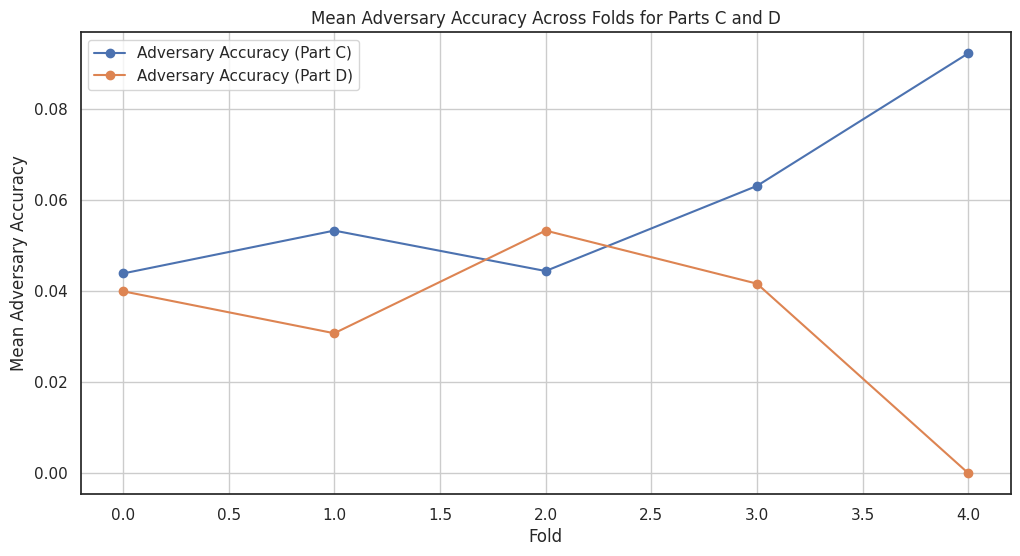

In [ ]:
#convert accuracy data for parts C and D into DataFrames
results_df_combined_c = pd.DataFrame(accuracy_data_combined_c)
results_df_combined_d = pd.DataFrame(accuracy_data_combined_d)

#filter for FNN results and calculate the mean adversary accuracy per fold
df_c_adversary = results_df_combined_c[results_df_combined_c['model'] == 'FNN'].groupby('fold')['adversary_accuracy'].mean().reset_index()
df_d_adversary = results_df_combined_d[results_df_combined_d['model'] == 'FNN'].groupby('fold')['adversary_accuracy'].mean().reset_index()

#ensure Random Forest results are available
avg_results_rf_c = results_df_combined_c[results_df_combined_c['model'] == 'Random Forest']
avg_results_rf_d = results_df_combined_d[results_df_combined_d['model'] == 'Random Forest']

#get the best adversary features for part C
best_rf_adversary_k_c = avg_results_rf_c.loc[avg_results_rf_c['accuracy'].idxmax(), 'k']
best_rf_adversary_features_all_c = avg_results_rf_c[avg_results_rf_c['k'] == best_rf_adversary_k_c]['important features'].iloc[0]
best_fnn_adversary_k_c = results_df_combined_c[results_df_combined_c['model'] == 'FNN'].loc[results_df_combined_c['balanced_accuracy'].idxmax(), 'k']
best_fnn_adversary_features_all_c = results_df_combined_c[(results_df_combined_c['model'] == 'FNN') & (results_df_combined_c['k'] == best_fnn_adversary_k_c)]['important features'].iloc[0]

#get the best adversary features for part D
best_rf_adversary_k_d = avg_results_rf_d.loc[avg_results_rf_d['accuracy'].idxmax(), 'k']
best_rf_adversary_features_all_d = avg_results_rf_d[avg_results_rf_d['k'] == best_rf_adversary_k_d]['important ad features'].iloc[0]
best_fnn_adversary_k_d = results_df_combined_d[results_df_combined_d['model'] == 'FNN'].loc[results_df_combined_d['accuracy'].idxmax()-1, 'k']
best_fnn_adversary_features_all_d = results_df_combined_d[(results_df_combined_d['model'] == 'FNN') & (results_df_combined_d['k'] == best_fnn_adversary_k_d)]['important ad features'].iloc[0]

#top 20 adversary features for C and D
best_rf_adversary_features_c = best_rf_adversary_features_all_c[:20]
best_fnn_adversary_features_c = best_fnn_adversary_features_all_c[:20]
best_rf_adversary_features_d = best_rf_adversary_features_all_d[:20]
best_fnn_adversary_features_d = best_fnn_adversary_features_all_d[:20]

#plot adversary accuracies
plt.figure(figsize=(12, 6))
plt.plot(df_c_adversary['fold'], df_c_adversary['adversary_accuracy'], label='Adversary Accuracy (Part C)', marker='o')
plt.plot(df_d_adversary['fold'], df_d_adversary['adversary_accuracy'], label='Adversary Accuracy (Part D)', marker='o')

#labels
plt.xlabel('Fold')
plt.ylabel('Mean Adversary Accuracy')
plt.title('Mean Adversary Accuracy Across Folds for Parts C and D')
plt.legend()
plt.grid()
plt.show()

plt.show()

In [ ]:
#combine lists
speaker_dependent_features = list(set(
    speaker_dependent_features +
    best_rf_adversary_features_c +
    best_fnn_adversary_features_c +
    best_rf_adversary_features_d +
    best_fnn_adversary_features_d
))

#check duplicates
speaker_dependent_features = list(set(speaker_dependent_features))

# -------------------- Part C --------------------
for k in k_values:
    # Compute MI and select features for Part C
    selected_features_c = compute_mi_and_select_features(part_c_df, k_tfidf=k, k_sentiment=4, k_bert=k, k_other=6)

    # Remove speaker-dependent features
    selected_features_c = [f for f in selected_features_c if f not in speaker_dependent_features]

    for i in range(len(fold_dfs_c)):
        print(f'Remaining iterations: {total}')
        total -= 1

        # Split train/val
        train_df_c = pd.concat(fold_dfs_c[:i] + fold_dfs_c[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df_c = fold_dfs_c[i].sample(frac=1).reset_index(drop=True)

        # Prepare datasets
        train_data_c = prepare_dataset(train_df_c, selected_features_c)
        val_data_c = prepare_dataset(val_df_c, selected_features_c)

         #separate features and labels
        X_train_c = train_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_train_c = train_data_c['Degree of Explanation']
        X_val_c = val_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_val_c = val_data_c['Degree of Explanation']

        #scale features
        scaler = StandardScaler()
        X_train_c = scaler.fit_transform(X_train_c)
        X_val_c = scaler.transform(X_val_c)

        #smote to oversample
        smote = SMOTE()
        X_train_c_balanced, y_train_c_balanced = smote.fit_resample(X_train_c, y_train_c)

        #run rf
        rf_acc_c, rf_bacc_c, rf_y_pred_c, rf_model = random_forest_model(X_train_c_balanced, y_train_c_balanced, X_val_c, y_val_c)

        feature_importances = rf_model.feature_importances_
        feature_names = train_data_c.drop(columns=['Degree of Explanation', 'PID', 'QID']).columns
        important_features = sorted(zip(feature_importances, feature_names), reverse=True)

        #store rf results
        accuracy_data_combined_c.append({
            'model': 'Random Forest',
            'k': k,
            'fold': i,
            'accuracy': rf_acc_c,
            'balanced_accuracy': rf_bacc_c,
            'predictions': rf_y_pred_c.tolist(),
            'important features' : important_features,
            'true': y_val_c.tolist(),
        })

        #run fnn
        fnn_acc_c, fnn_bacc_c, fnn_y_pred_c, model = fnn_model_1(X_train_c, y_train_c, X_val_c, y_val_c)

        #get abs fnn weights
        input_layer_weights = model.layers[0].get_weights()[0]  # Weights from input to first hidden layer
        feature_importance_fnn = np.sum(np.abs(input_layer_weights), axis=1)

        #map importance scores to feature names
        importance_scores = zip(feature_importance_fnn, feature_names)
        sorted_importance = sorted(importance_scores, key=lambda x: x[0], reverse=True)

        #store fnn results
        accuracy_data_combined_c.append({
            'model': 'FNN',
            'k': k,
            'fold': i,
            'accuracy': fnn_acc_c,
            'balanced_accuracy': fnn_bacc_c,
            'predictions': fnn_y_pred_c.tolist(),
            'important features' : sorted_importance,
            'true': y_val_c.tolist(),
        })

# -------------------- Part D --------------------
for k in k_values:
    # Compute MI and select features for Part D
    selected_features_d = compute_mi_and_select_features(part_d_df, k_tfidf=k, k_sentiment=4, k_bert=k, k_other=6)

    # Remove speaker-dependent features
    selected_features_d = [f for f in selected_features_d if f not in speaker_dependent_features]

    for i in range(len(fold_dfs_d)):
        print(f'Remaining iterations: {total}')
        total -= 1

        # Split train/val
        train_df_d = pd.concat(fold_dfs_d[:i] + fold_dfs_d[i+1:]).sample(frac=1).reset_index(drop=True)
        val_df_d = fold_dfs_d[i].sample(frac=1).reset_index(drop=True)

        # Prepare datasets
        train_data_d = prepare_dataset(train_df_d, selected_features_d)
        val_data_d = prepare_dataset(val_df_d, selected_features_d)

        #separate features and labels
        X_train_d = train_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_train_d = train_data_d['Degree of Explanation']
        X_val_d = val_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).to_numpy()
        y_val_d = val_data_d['Degree of Explanation']

        #scale features
        scaler = StandardScaler()
        X_train_d = scaler.fit_transform(X_train_d)
        X_val_d = scaler.transform(X_val_d)

        #smote to oversample
        smote = SMOTE()
        X_train_d_balanced, y_train_d_balanced = smote.fit_resample(X_train_d, y_train_d)

        #run rf
        rf_acc_d, rf_bacc_d, rf_y_pred_d, rf_model = random_forest_model(X_train_d_balanced, y_train_d_balanced, X_val_d, y_val_d)

        feature_importances = rf_model.feature_importances_
        feature_names = train_data_d.drop(columns=['Degree of Explanation', 'PID', 'QID']).columns
        important_features = sorted(zip(feature_importances, feature_names), reverse=True)

        #store rf results
        accuracy_data_combined_d.append({
            'model': 'Random Forest',
            'k': k,
            'fold': i,
            'accuracy': rf_acc_d,
            'balanced_accuracy': rf_bacc_d,
            'predictions': rf_y_pred_d.tolist(),
            'important features' : important_features,
            'true': y_val_d.tolist(),
        })

        #run fnn
        fnn_acc_d, fnn_bacc_d, fnn_y_pred_d, model = fnn_model_1(X_train_d, y_train_d, X_val_d, y_val_d)

        #get abs fnn weights
        input_layer_weights = model.layers[0].get_weights()[0]  # Weights from input to first hidden layer
        feature_importance_fnn = np.sum(np.abs(input_layer_weights), axis=1)

        #map importance scores to feature names
        importance_scores = zip(feature_importance_fnn, feature_names)
        sorted_importance = sorted(importance_scores, key=lambda x: x[0], reverse=True)

        #store fnn results
        accuracy_data_combined_d.append({
            'model': 'FNN',
            'k': k,
            'fold': i,
            'accuracy': fnn_acc_d,
            'balanced_accuracy': fnn_bacc_d,
            'predictions': fnn_y_pred_d.tolist(),
            'important features' : sorted_importance,
            'true': y_val_d.tolist(),
        })

Remaining iterations: 0


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_852 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_853 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_338 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_854 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_855 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_339 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_856 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_857 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.4640 - loss: 0.6956 - val_accuracy: 0.8537 - val_loss: 0.4708
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7834 - loss: 0.5366 - val_accuracy: 0.8537 - val_loss: 0.3784
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7951 - loss: 0.3432 - val_accuracy: 0.8537 - val_loss: 0.3902
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8264 - loss: 0.2583 - val_accuracy: 0.8293 - val_loss: 0.4417
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8865 - loss: 0.2157 - val_accuracy: 0.6585 - val_loss: 0.6503
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9653 - loss: 0.1306 - val_accuracy: 0.8049 - val_loss: 0.8008
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.9827 - loss: 0.0683 - val_accuracy: 0.7805 - val_loss: 1.2025
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 0.7073 - val_loss: 1.

Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_858 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_859 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_340 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_860 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_861 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_341 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_862 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_863 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.6166 - loss: 0.5680 - val_accuracy: 0.8000 - val_loss: 0.7198
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.8351 - loss: 0.3601 - val_accuracy: 0.8000 - val_loss: 0.6269
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8464 - loss: 0.2390 - val_accuracy: 0.8000 - val_loss: 0.9957
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8706 - loss: 0.1929 - val_accuracy: 0.8000 - val_loss: 1.3278
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9785 - loss: 0.0999 - val_accuracy: 0.8000 - val_loss: 1.7919
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9939 - loss: 0.0566 - val_accuracy: 0.7667 - val_loss: 2.0432
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9845 - loss: 0.0540 - val_accuracy: 0.7667 - val_loss: 2.6435
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9908 - loss: 0.0423 - val_accuracy: 0.7667 - val_loss:

Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_864 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_865 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_342 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_866 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_867 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_343 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_868 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_869 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.5319 - loss: 0.6403 - val_accuracy: 0.9259 - val_loss: 0.2131
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7955 - loss: 0.4157 - val_accuracy: 0.9259 - val_loss: 0.3684
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8745 - loss: 0.3026 - val_accuracy: 0.9259 - val_loss: 0.2476
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9511 - loss: 0.1650 - val_accuracy: 0.8519 - val_loss: 0.3592
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9696 - loss: 0.1094 - val_accuracy: 0.9259 - val_loss: 0.3634
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9849 - loss: 0.0625 - val_accuracy: 0.8519 - val_loss: 0.5225
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9940 - loss: 0.0380 - val_accuracy: 0.8519 - val_loss: 0.6985
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9808 - loss: 0.0971 - val_accuracy: 0.9259 - val_loss: 0

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_870 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_871 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_344 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_872 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_873 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_345 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_874 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_875 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.5977 - loss: 0.5660 - val_accuracy: 0.6316 - val_loss: 0.8569
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8694 - loss: 0.3032 - val_accuracy: 0.6316 - val_loss: 0.5540
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8403 - loss: 0.2641 - val_accuracy: 0.6316 - val_loss: 0.7959
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8771 - loss: 0.1893 - val_accuracy: 0.7895 - val_loss: 0.5699
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9637 - loss: 0.1603 - val_accuracy: 0.7895 - val_loss: 0.8093
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9616 - loss: 0.0852 - val_accuracy: 0.7895 - val_loss: 1.2052
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9849 - loss: 0.0462 - val_accuracy: 0.7895 - val_loss: 1.3233
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0227 - val_accuracy: 0.7895 - val_loss:

Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_876 (Dense)                    │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_877 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_346 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_878 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_879 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_347 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_880 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_881 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5728 - loss: 0.6075 - val_accuracy: 0.8462 - val_loss: 0.4797
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8282 - loss: 0.4333 - val_accuracy: 0.8462 - val_loss: 0.4465
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7907 - loss: 0.4001 - val_accuracy: 0.8462 - val_loss: 0.4022
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8407 - loss: 0.2637 - val_accuracy: 0.8462 - val_loss: 0.3990
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8767 - loss: 0.2035 - val_accuracy: 0.7692 - val_loss: 0.4052
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9548 - loss: 0.1315 - val_accuracy: 0.8462 - val_loss: 0.5763
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9634 - loss: 0.0753 - val_accuracy: 0.8462 - val_loss: 0.6585
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9911 - loss: 0.0330 - val_accuracy: 0.8462 - val_loss: 0.8399

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_882 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_883 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_348 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_884 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_885 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_349 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_886 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_887 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.5568 - loss: 0.6827 - val_accuracy: 0.8537 - val_loss: 0.7668
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8186 - loss: 0.3774 - val_accuracy: 0.8537 - val_loss: 0.9328
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8186 - loss: 0.2878 - val_accuracy: 0.8293 - val_loss: 0.9772
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9424 - loss: 0.1801 - val_accuracy: 0.8293 - val_loss: 1.9447
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9731 - loss: 0.0827 - val_accuracy: 0.8537 - val_loss: 3.2974
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 0.8293 - val_loss: 4.5917
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8049 - val_loss: 5.4180
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.3450e-04 - val_accuracy: 0.7805 - val_loss: 6.

Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_888 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_889 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_350 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_890 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_891 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_351 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_892 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_893 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.7042 - loss: 0.6055 - val_accuracy: 0.8000 - val_loss: 0.8435
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8289 - loss: 0.4026 - val_accuracy: 0.8000 - val_loss: 0.5346
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8174 - loss: 0.3200 - val_accuracy: 0.8000 - val_loss: 0.9186
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8247 - loss: 0.2234 - val_accuracy: 0.8000 - val_loss: 0.8668
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9845 - loss: 0.0993 - val_accuracy: 0.7667 - val_loss: 1.3169
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0376 - val_accuracy: 0.8000 - val_loss: 2.4654
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.8000 - val_loss: 2.7249
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7000 - val_loss: 2.921

Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_894 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_895 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_352 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_896 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_897 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_353 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_898 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_899 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.6174 - loss: 0.6135 - val_accuracy: 0.9259 - val_loss: 0.2641
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8005 - loss: 0.3702 - val_accuracy: 0.9259 - val_loss: 0.3121
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9298 - loss: 0.1762 - val_accuracy: 0.8889 - val_loss: 0.5104
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0486 - val_accuracy: 0.7778 - val_loss: 1.1999
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0248 - val_accuracy: 0.8519 - val_loss: 1.2363
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.8148 - val_loss: 1.6112
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.3600e-04 - val_accuracy: 0.7037 - val_loss: 3.4364
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9654 - loss: 0.1917 - val_accuracy: 0.8519 - val_loss: 1.

Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_900 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_901 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_354 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_902 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_903 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_355 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_904 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_905 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7925 - loss: 0.5614 - val_accuracy: 0.6316 - val_loss: 0.9464
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8632 - loss: 0.3096 - val_accuracy: 0.6316 - val_loss: 0.8737
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8851 - loss: 0.2399 - val_accuracy: 0.6316 - val_loss: 1.1062
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8848 - loss: 0.2045 - val_accuracy: 0.6316 - val_loss: 0.9970
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9756 - loss: 0.0915 - val_accuracy: 0.6316 - val_loss: 2.5385
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9398 - loss: 0.1177 - val_accuracy: 0.6316 - val_loss: 2.4675
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.6842 - val_loss: 2.1197
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.6842 - val_loss: 2.7662

Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_906 (Dense)                    │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_907 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_356 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_908 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_909 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_357 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_910 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_911 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.7636 - loss: 0.5059 - val_accuracy: 0.8462 - val_loss: 0.3740
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8672 - loss: 0.3167 - val_accuracy: 0.8462 - val_loss: 0.4040
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9514 - loss: 0.2021 - val_accuracy: 0.9231 - val_loss: 0.3040
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9702 - loss: 0.0583 - val_accuracy: 0.7692 - val_loss: 0.5158
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.8462 - val_loss: 0.5462
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 6.0969e-04 - val_accuracy: 0.7692 - val_loss: 0.7358
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.1824e-04 - val_accuracy: 0.7692 - val_loss: 0.9078
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.4919e-04 - val_accuracy: 0.7692 - val_

Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_912 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_913 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_358 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_914 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_915 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_359 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_916 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_917 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5295 - loss: 0.6616 - val_accuracy: 0.8537 - val_loss: 0.6323
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8186 - loss: 0.4266 - val_accuracy: 0.8537 - val_loss: 0.5075
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8476 - loss: 0.3056 - val_accuracy: 0.8780 - val_loss: 0.6025
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9827 - loss: 0.1442 - val_accuracy: 0.8780 - val_loss: 0.9501
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 0.8537 - val_loss: 1.4582
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8293 - val_loss: 2.1319
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.7505e-04 - val_accuracy: 0.8293 - val_loss: 2.7798
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.5702e-05 - val_accuracy: 0.8293 - v

Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_918 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_919 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_360 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_920 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_921 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_361 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_922 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_923 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.8072 - loss: 0.5379 - val_accuracy: 0.2667 - val_loss: 0.8296
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8112 - loss: 0.4836 - val_accuracy: 0.8000 - val_loss: 0.6521
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8334 - loss: 0.3828 - val_accuracy: 0.8667 - val_loss: 0.3839
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9602 - loss: 0.1203 - val_accuracy: 0.8000 - val_loss: 0.8313
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9538 - loss: 0.0903 - val_accuracy: 0.8667 - val_loss: 0.5519
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.8000 - val_loss: 0.5244
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8667 - val_loss: 0.8639
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 2.4711e-04 - val_accuracy: 0.8667 - val_loss: 1.

Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_924 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_925 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_362 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_926 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_927 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_363 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_928 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_929 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.4492 - loss: 0.7370 - val_accuracy: 0.9259 - val_loss: 0.2930
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8007 - loss: 0.4279 - val_accuracy: 0.9259 - val_loss: 0.3054
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9295 - loss: 0.2031 - val_accuracy: 0.9259 - val_loss: 0.4870
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.9665 - loss: 0.0639 - val_accuracy: 0.6667 - val_loss: 1.1050
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.9818 - loss: 0.0509 - val_accuracy: 0.8889 - val_loss: 1.0560
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9259 - val_loss: 1.5900
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9849 - loss: 0.0319 - val_accuracy: 0.8889 - val_loss: 1.5422
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 5.9784e-05 - val_accuracy: 0.8519 - val_loss

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_930 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_931 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_364 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_932 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_933 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_365 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_934 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_935 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.7510 - loss: 0.6220 - val_accuracy: 0.6316 - val_loss: 0.8349
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8351 - loss: 0.3818 - val_accuracy: 0.6316 - val_loss: 2.7933
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8361 - loss: 0.3334 - val_accuracy: 0.6842 - val_loss: 1.3189
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9699 - loss: 0.1603 - val_accuracy: 0.6316 - val_loss: 4.7940
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9793 - loss: 0.0672 - val_accuracy: 0.6316 - val_loss: 5.3413
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.7368 - val_loss: 4.7351
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.7368 - val_loss: 6.9809
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 2.3183e-04 - val_accuracy: 0.6842 - val_loss: 9.

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_936 (Dense)                    │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_937 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_366 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_938 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_939 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_367 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_940 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_941 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6977 - loss: 0.6364 - val_accuracy: 0.8462 - val_loss: 0.4344
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8490 - loss: 0.3739 - val_accuracy: 0.6923 - val_loss: 0.5451
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9494 - loss: 0.2990 - val_accuracy: 0.8462 - val_loss: 0.5823
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9021 - loss: 0.1563 - val_accuracy: 0.5385 - val_loss: 0.8580
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.5385 - val_loss: 1.2816
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.6923 - val_loss: 1.6820
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 7.3227e-04 - val_accuracy: 0.6923 - val_loss: 2.1422
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 1.0672e-04 - val_accuracy: 0.6923 - val_lo

Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_942 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_943 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_368 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_944 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_945 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_369 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_946 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_947 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4489 - loss: 0.8041 - val_accuracy: 0.8537 - val_loss: 0.4577
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8342 - loss: 0.3984 - val_accuracy: 0.8537 - val_loss: 0.3956
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8254 - loss: 0.3025 - val_accuracy: 0.8780 - val_loss: 0.3695
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9636 - loss: 0.1257 - val_accuracy: 0.9024 - val_loss: 0.4132
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 0.8293 - val_loss: 0.5338
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.8049 - val_loss: 0.7450
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 5.6615e-04 - val_accuracy: 0.8293 - val_loss: 0.8631
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 4.5666e-05 - val_accuracy: 0.8537 - val_loss

Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_948 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_949 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_370 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_950 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_951 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_371 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_952 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_953 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.8476 - loss: 0.7007 - val_accuracy: 0.3000 - val_loss: 0.7696
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7464 - loss: 0.5248 - val_accuracy: 0.8000 - val_loss: 1.0678
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8403 - loss: 0.3565 - val_accuracy: 0.8000 - val_loss: 0.8042
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9536 - loss: 0.1921 - val_accuracy: 0.8333 - val_loss: 1.1159
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9939 - loss: 0.0609 - val_accuracy: 0.8000 - val_loss: 2.1149
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.8000 - val_loss: 2.8005
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8000 - val_loss: 3.2161
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 3.8029e-04 - val_accuracy: 0.8000 - val_loss: 

Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_954 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_955 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_372 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_956 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_957 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_373 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_958 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_959 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.6143 - loss: 0.6968 - val_accuracy: 0.9259 - val_loss: 0.3251
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8088 - loss: 0.4085 - val_accuracy: 0.9259 - val_loss: 0.2954
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8649 - loss: 0.2125 - val_accuracy: 0.8889 - val_loss: 0.3545
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0651 - val_accuracy: 0.9259 - val_loss: 0.5353
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 0.9259 - val_loss: 0.8976
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.9926e-04 - val_accuracy: 0.9259 - val_loss: 0.8943
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.9581e-06 - val_accuracy: 0.9259 - val_loss: 0.9229
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9940 - loss: 0.0162 - val_accuracy: 0.9259 - val_loss

Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_960 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_961 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_374 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_962 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_963 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_375 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_964 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_965 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.4893 - loss: 0.7329 - val_accuracy: 0.6316 - val_loss: 0.7472
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8361 - loss: 0.3673 - val_accuracy: 0.6316 - val_loss: 2.6037
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8532 - loss: 0.3368 - val_accuracy: 0.6316 - val_loss: 0.6488
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9164 - loss: 0.1979 - val_accuracy: 0.6316 - val_loss: 3.6201
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0323 - val_accuracy: 0.6316 - val_loss: 5.2817
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.6842 - val_loss: 5.3751
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.3411e-04 - val_accuracy: 0.6842 - val_loss: 5.1904
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 1.4098e-04 - val_accuracy: 0.6842 - val_loss

Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_966 (Dense)                    │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_967 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_376 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_968 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_969 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_377 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_970 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_971 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8272 - loss: 0.6788 - val_accuracy: 0.8462 - val_loss: 0.4437
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8220 - loss: 0.4226 - val_accuracy: 0.8462 - val_loss: 0.4426
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9229 - loss: 0.1819 - val_accuracy: 0.8462 - val_loss: 0.5799
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0312 - val_accuracy: 0.8462 - val_loss: 1.0518
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8462 - val_loss: 2.3256
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 6.9271e-04 - val_accuracy: 0.8462 - val_loss: 3.2227
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 2.5544e-04 - val_accuracy: 0.8462 - val_loss: 3.6765
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.9551e-05 - val_accuracy: 0.8462 - val_

Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_972 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_973 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_378 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_974 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_975 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_379 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_976 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_977 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.5507 - loss: 0.7171 - val_accuracy: 0.8537 - val_loss: 0.5063
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8186 - loss: 0.4125 - val_accuracy: 0.8537 - val_loss: 0.6204
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8752 - loss: 0.1951 - val_accuracy: 0.8293 - val_loss: 0.4727
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9827 - loss: 0.0618 - val_accuracy: 0.8537 - val_loss: 1.4356
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8780 - val_loss: 1.6001
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 3.8430e-04 - val_accuracy: 0.8780 - val_loss: 1.6527
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8780 - val_loss: 1.9763
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 8.8481e-06 - val_accuracy: 0.9024 - val_loss

Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_978 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_979 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_380 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_980 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_981 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_381 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_982 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_983 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.6257 - loss: 0.6313 - val_accuracy: 0.8000 - val_loss: 0.5752
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8619 - loss: 0.3648 - val_accuracy: 0.8000 - val_loss: 1.6409
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9076 - loss: 0.1596 - val_accuracy: 0.8333 - val_loss: 1.0592
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9908 - loss: 0.0330 - val_accuracy: 0.8000 - val_loss: 4.2498
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.8000 - val_loss: 5.7709
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 9.4390e-04 - val_accuracy: 0.8000 - val_loss: 6.5307
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 1.8710e-05 - val_accuracy: 0.8000 - val_loss: 7.0706
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 9.6107e-06 - val_accuracy: 0.8000

Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_984 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_985 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_382 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_986 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_987 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_383 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_988 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_989 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6975 - loss: 0.7209 - val_accuracy: 0.9259 - val_loss: 0.3997
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7809 - loss: 0.4016 - val_accuracy: 0.9259 - val_loss: 0.2875
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8471 - loss: 0.2399 - val_accuracy: 0.8519 - val_loss: 0.3660
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 0.9259 - val_loss: 0.6892
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.8889 - val_loss: 0.9170
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 7.4792e-05 - val_accuracy: 0.8519 - val_loss: 1.1293
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.4270e-06 - val_accuracy: 0.8148 - val_loss: 1.3782
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 1.9040e-05 - val_accuracy: 0.8148 - val

Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_990 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_991 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_384 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_992 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_993 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_385 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_994 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_995 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.5376 - loss: 0.9478 - val_accuracy: 0.6316 - val_loss: 0.6232
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7605 - loss: 0.4545 - val_accuracy: 0.6316 - val_loss: 1.3196
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8528 - loss: 0.2795 - val_accuracy: 0.6316 - val_loss: 0.7320
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9559 - loss: 0.1758 - val_accuracy: 0.6316 - val_loss: 0.8655
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9912 - loss: 0.0692 - val_accuracy: 0.6316 - val_loss: 2.0724
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.6316 - val_loss: 1.9972
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 9.8580e-04 - val_accuracy: 0.6842 - val_loss: 1.6086
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 8.5569e-04 - val_accuracy: 0.6316 - va

Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_996 (Dense)                    │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_997 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_386 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_998 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_999 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_387 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1000 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1001 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.7251 - loss: 0.7867 - val_accuracy: 0.8462 - val_loss: 0.4401
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7907 - loss: 0.4489 - val_accuracy: 0.8462 - val_loss: 0.4426
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8056 - loss: 0.3678 - val_accuracy: 0.7692 - val_loss: 0.4188
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9707 - loss: 0.1666 - val_accuracy: 0.8462 - val_loss: 0.6362
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0422 - val_accuracy: 0.6923 - val_loss: 0.6810
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.6923 - val_loss: 0.9349
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 1.0715e-04 - val_accuracy: 0.7692 - val_loss: 1.0894
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6158e-05 - val_accuracy: 0.7692 - val_loss

Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1002 (Dense)                   │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1003 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_388 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1004 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1005 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_389 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1006 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1007 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.7843 - loss: 0.5417 - val_accuracy: 0.7111 - val_loss: 1.1270
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8620 - loss: 0.2814 - val_accuracy: 0.7556 - val_loss: 0.6963
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9300 - loss: 0.1629 - val_accuracy: 0.7556 - val_loss: 1.7854
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9849 - loss: 0.0587 - val_accuracy: 0.7333 - val_loss: 1.6695
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.7333 - val_loss: 3.3291
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.7778 - val_loss: 5.4916
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9943 - loss: 0.0120 - val_accuracy: 0.7111 - val_loss: 5.5249
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.8746e-04 - val_accuracy: 0.7333 - val_loss: 4.

Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1008 (Dense)                   │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1009 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_390 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1010 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1011 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_391 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1012 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1013 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6189 - loss: 0.6223 - val_accuracy: 0.8462 - val_loss: 0.3309
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7983 - loss: 0.4040 - val_accuracy: 0.8462 - val_loss: 0.2917
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9221 - loss: 0.2530 - val_accuracy: 0.8718 - val_loss: 0.3387
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9500 - loss: 0.1067 - val_accuracy: 0.8718 - val_loss: 0.4185
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9765 - loss: 0.0495 - val_accuracy: 0.8974 - val_loss: 0.5520
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.7949 - val_loss: 0.8140
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.8974 - val_loss: 1.0003
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 4.2450e-04 - val_accuracy: 0.8974 - val_loss:

Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1014 (Dense)                   │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1015 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_392 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1016 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1017 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_393 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1018 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1019 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.6367 - loss: 0.6014 - val_accuracy: 0.9333 - val_loss: 0.3010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8836 - loss: 0.2876 - val_accuracy: 0.8333 - val_loss: 0.3016
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9308 - loss: 0.1610 - val_accuracy: 0.8667 - val_loss: 0.3114
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9078 - loss: 0.1995 - val_accuracy: 0.9000 - val_loss: 0.3219
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9686 - loss: 0.0854 - val_accuracy: 0.9000 - val_loss: 0.3330
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0242 - val_accuracy: 0.9000 - val_loss: 0.4186
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9884 - loss: 0.0136 - val_accuracy: 0.9000 - val_loss: 0.4818
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9333 - val_loss: 0.6

Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1020 (Dense)                   │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1021 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_394 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1022 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1023 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_395 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1024 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1025 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6689 - loss: 0.5828 - val_accuracy: 0.7917 - val_loss: 0.6635
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8725 - loss: 0.2685 - val_accuracy: 0.7917 - val_loss: 1.6733
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9020 - loss: 0.2019 - val_accuracy: 0.7500 - val_loss: 1.2085
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9428 - loss: 0.1036 - val_accuracy: 0.8333 - val_loss: 1.8025
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 0.0319 - val_accuracy: 0.8333 - val_loss: 1.9269
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9755 - loss: 0.0590 - val_accuracy: 0.7917 - val_loss: 3.1999
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.7917 - val_loss: 4.5193
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.7917 - val_loss: 4.94

Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1026 (Dense)                   │ (None, 2048)                │         124,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1027 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_396 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1028 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1029 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_397 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1030 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1031 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,386 (11.11 MB)

 Trainable params: 2,912,386 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5215 - loss: 0.6541 - val_accuracy: 0.7222 - val_loss: 0.5250
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8173 - loss: 0.4248 - val_accuracy: 0.8889 - val_loss: 0.2428
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8499 - loss: 0.2876 - val_accuracy: 1.0000 - val_loss: 0.1598
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9137 - loss: 0.1719 - val_accuracy: 0.9444 - val_loss: 0.1338
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9614 - loss: 0.1232 - val_accuracy: 0.8889 - val_loss: 0.1377
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9658 - loss: 0.0797 - val_accuracy: 0.8889 - val_loss: 0.1701
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9945 - loss: 0.0225 - val_accuracy: 0.8889 - val_loss: 0.2858
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.8889 - val_loss: 0.1789

Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1032 (Dense)                   │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1033 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_398 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1034 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1035 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_399 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1036 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1037 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.5869 - loss: 0.6069 - val_accuracy: 0.7111 - val_loss: 0.5559
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8221 - loss: 0.3492 - val_accuracy: 0.7111 - val_loss: 1.2281
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8324 - loss: 0.2477 - val_accuracy: 0.7111 - val_loss: 0.8751
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9352 - loss: 0.1167 - val_accuracy: 0.8222 - val_loss: 1.5786
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9907 - loss: 0.0354 - val_accuracy: 0.7333 - val_loss: 3.1654
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9849 - loss: 0.0426 - val_accuracy: 0.7778 - val_loss: 2.2549
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7111 - val_loss: 2.3907
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 5.8622e-04 - val_accuracy: 0.6889 - val_loss: 2.

Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1038 (Dense)                   │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1039 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_400 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1040 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1041 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_401 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1042 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1043 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.4616 - loss: 0.7460 - val_accuracy: 0.8462 - val_loss: 0.3595
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7876 - loss: 0.4214 - val_accuracy: 0.9231 - val_loss: 0.2809
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9033 - loss: 0.2339 - val_accuracy: 0.8462 - val_loss: 0.2557
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0585 - val_accuracy: 0.8718 - val_loss: 0.4693
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.8974 - val_loss: 0.4024
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8974 - val_loss: 0.5498
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.4618e-04 - val_accuracy: 0.8718 - val_loss: 0.8613
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.3511e-05 - val_accuracy: 0.8718 - val_loss

Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1044 (Dense)                   │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1045 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_402 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1046 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1047 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_403 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1048 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1049 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.4755 - loss: 0.6974 - val_accuracy: 0.9000 - val_loss: 0.3128
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7978 - loss: 0.3891 - val_accuracy: 0.9333 - val_loss: 0.1815
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9372 - loss: 0.2262 - val_accuracy: 0.9667 - val_loss: 0.1841
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0493 - val_accuracy: 0.9667 - val_loss: 0.1381
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9333 - val_loss: 0.1782
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9333 - val_loss: 0.2819
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.0290e-05 - val_accuracy: 0.9333 - val_loss: 0.3054
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9721e-05 - val_accuracy: 0.9333 - val_loss

Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1050 (Dense)                   │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1051 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_404 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1052 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1053 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_405 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1054 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1055 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.6065 - loss: 0.6382 - val_accuracy: 0.7083 - val_loss: 0.5285
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7594 - loss: 0.4018 - val_accuracy: 0.7083 - val_loss: 1.0560
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8683 - loss: 0.2687 - val_accuracy: 0.7500 - val_loss: 0.8306
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9458 - loss: 0.1620 - val_accuracy: 0.7917 - val_loss: 1.7241
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9755 - loss: 0.0851 - val_accuracy: 0.7917 - val_loss: 1.5438
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9962 - loss: 0.0098 - val_accuracy: 0.7917 - val_loss: 1.8527
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9923 - loss: 0.0188 - val_accuracy: 0.7917 - val_loss: 1.9180
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 2.1052e-04 - val_accuracy: 0.8750 - val_loss: 

Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1056 (Dense)                   │ (None, 2048)                │         227,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1057 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_406 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1058 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1059 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_407 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1060 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1061 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,786 (11.50 MB)

 Trainable params: 3,014,786 (11.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7691 - loss: 0.5627 - val_accuracy: 1.0000 - val_loss: 0.3830
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8595 - loss: 0.3246 - val_accuracy: 0.9444 - val_loss: 0.1458
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9525 - loss: 0.1225 - val_accuracy: 0.9444 - val_loss: 0.0982
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9867 - loss: 0.0284 - val_accuracy: 0.9444 - val_loss: 0.0971
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9444 - val_loss: 0.1907
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.5357e-04 - val_accuracy: 0.8889 - val_loss: 0.2929
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.0255e-04 - val_accuracy: 0.8889 - val_loss: 0.3308
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.5440e-05 - val_accuracy: 0.8889 - val_

Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1062 (Dense)                   │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1063 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_408 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1064 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1065 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_409 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1066 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1067 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.6591 - loss: 0.6952 - val_accuracy: 0.7111 - val_loss: 0.6048
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7785 - loss: 0.3972 - val_accuracy: 0.7111 - val_loss: 1.2499
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8927 - loss: 0.1727 - val_accuracy: 0.7333 - val_loss: 0.8206
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9398 - loss: 0.1025 - val_accuracy: 0.7333 - val_loss: 3.6499
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9849 - loss: 0.0388 - val_accuracy: 0.7778 - val_loss: 4.3733
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.1361e-04 - val_accuracy: 0.8000 - val_loss: 4.0978
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 4.4990e-04 - val_accuracy: 0.8000 - val_loss: 3.8947
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9943 - loss: 0.0051 - val_accuracy: 0.8000 - val_loss

Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1068 (Dense)                   │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1069 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_410 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1070 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1071 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_411 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1072 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1073 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.7616 - loss: 0.6425 - val_accuracy: 0.8974 - val_loss: 0.3397
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8208 - loss: 0.3160 - val_accuracy: 0.8974 - val_loss: 0.5723
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9697 - loss: 0.0729 - val_accuracy: 0.9231 - val_loss: 0.9292
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9765 - loss: 0.0432 - val_accuracy: 0.8718 - val_loss: 0.6594
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8205 - val_loss: 0.8444
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 1.2807e-04 - val_accuracy: 0.9231 - val_loss: 0.7627
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9231 - val_loss: 0.8300
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 9.9479e-04 - val_accuracy: 0.8974 - val

Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1074 (Dense)                   │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1075 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_412 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1076 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1077 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_413 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1078 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1079 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.4954 - loss: 0.7295 - val_accuracy: 0.7000 - val_loss: 0.6041
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8343 - loss: 0.4000 - val_accuracy: 0.9000 - val_loss: 0.2414
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9581 - loss: 0.1449 - val_accuracy: 0.9667 - val_loss: 0.2367
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9854 - loss: 0.0329 - val_accuracy: 0.9000 - val_loss: 0.3649
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8333 - val_loss: 0.7320
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.2597e-04 - val_accuracy: 0.9667 - val_loss: 0.4981
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9864 - loss: 0.0306 - val_accuracy: 0.9333 - val_loss: 0.5765
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 1.6771e-05 - val_accuracy: 0.7667 - val_loss

Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1080 (Dense)                   │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1081 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_414 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1082 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1083 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_415 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1084 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1085 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.6366 - loss: 0.6217 - val_accuracy: 0.7917 - val_loss: 0.4495
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8947 - loss: 0.3126 - val_accuracy: 0.7500 - val_loss: 0.8639
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9583 - loss: 0.1187 - val_accuracy: 0.7917 - val_loss: 1.1247
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9751 - loss: 0.0718 - val_accuracy: 0.7917 - val_loss: 1.0498
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9923 - loss: 0.0216 - val_accuracy: 0.8333 - val_loss: 1.3286
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9962 - loss: 0.0088 - val_accuracy: 0.7917 - val_loss: 2.1491
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 8.8048e-05 - val_accuracy: 0.7500 - val_loss: 2.3017
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 3.4683e-04 - val_accuracy: 0.7500 - va

Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1086 (Dense)                   │ (None, 2048)                │         636,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1087 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_416 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1088 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1089 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_417 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1090 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1091 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,424,386 (13.06 MB)

 Trainable params: 3,424,386 (13.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.6856 - loss: 0.5863 - val_accuracy: 0.8889 - val_loss: 0.3451
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8904 - loss: 0.3213 - val_accuracy: 0.7778 - val_loss: 0.4494
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8659 - loss: 0.2468 - val_accuracy: 0.7222 - val_loss: 1.0309
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8692 - loss: 0.2349 - val_accuracy: 0.8333 - val_loss: 0.3787
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9963 - loss: 0.0323 - val_accuracy: 0.7778 - val_loss: 0.6393
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 4.7945e-04 - val_accuracy: 0.8333 - val_loss: 0.9872
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 8.0609e-04 - val_accuracy: 0.8333 - val_loss: 1.2026
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8333 - val_loss

Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)                   │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1093 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_418 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1094 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1095 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_419 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1096 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1097 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.6036 - loss: 0.7609 - val_accuracy: 0.7778 - val_loss: 0.5608
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8206 - loss: 0.3756 - val_accuracy: 0.8000 - val_loss: 0.6812
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8951 - loss: 0.1933 - val_accuracy: 0.7556 - val_loss: 0.7987
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9943 - loss: 0.0290 - val_accuracy: 0.7556 - val_loss: 1.7980
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7556 - val_loss: 3.1578
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.7556 - val_loss: 3.5576
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 2.7009e-05 - val_accuracy: 0.7778 - val_loss: 3.5706
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 4.4788e-07 - val_accuracy: 0.7556 - val_loss

Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1098 (Dense)                   │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1099 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_420 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1100 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1101 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_421 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1102 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1103 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.7382 - loss: 0.8062 - val_accuracy: 0.8718 - val_loss: 0.3641
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7909 - loss: 0.3928 - val_accuracy: 0.8205 - val_loss: 0.3689
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9396 - loss: 0.2085 - val_accuracy: 0.8718 - val_loss: 0.5783
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9765 - loss: 0.0808 - val_accuracy: 0.8205 - val_loss: 0.4628
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9914 - loss: 0.0188 - val_accuracy: 0.8462 - val_loss: 0.4786
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.4398e-04 - val_accuracy: 0.9231 - val_loss: 0.3731
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 5.6519e-05 - val_accuracy: 0.9231 - val_loss: 0.4054
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.6722e-05 - val_accuracy: 0.9231

Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1104 (Dense)                   │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1105 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_422 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1106 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1107 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_423 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1108 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1109 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7578 - loss: 0.8007 - val_accuracy: 0.7000 - val_loss: 0.5393
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8375 - loss: 0.4378 - val_accuracy: 0.8667 - val_loss: 0.3044
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9110 - loss: 0.2102 - val_accuracy: 0.9333 - val_loss: 0.4093
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9864 - loss: 0.0782 - val_accuracy: 0.8333 - val_loss: 0.5368
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.0123 - val_accuracy: 0.7333 - val_loss: 1.2571
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9707 - loss: 0.0588 - val_accuracy: 0.9000 - val_loss: 0.6814
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9947 - loss: 0.0056 - val_accuracy: 0.9333 - val_loss: 0.7746
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 6.9110e-04 - val_accuracy: 0.9333 - val_loss: 0.

Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1110 (Dense)                   │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1111 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_424 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1112 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1113 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_425 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1114 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1115 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5597 - loss: 0.7080 - val_accuracy: 0.7500 - val_loss: 0.5164
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7800 - loss: 0.4093 - val_accuracy: 0.7500 - val_loss: 0.7238
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9079 - loss: 0.2246 - val_accuracy: 0.8333 - val_loss: 0.8273
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9811 - loss: 0.1011 - val_accuracy: 0.7500 - val_loss: 1.1092
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.7500 - val_loss: 1.5414
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.7500 - val_loss: 2.0995
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.1355e-04 - val_accuracy: 0.7917 - val_loss: 2.4885
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7500 - val_lo

Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1116 (Dense)                   │ (None, 2048)                │       1,046,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1117 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_426 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1118 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1119 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_427 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1120 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1121 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,833,986 (14.63 MB)

 Trainable params: 3,833,986 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5421 - loss: 0.7911 - val_accuracy: 0.7222 - val_loss: 0.7893
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8485 - loss: 0.3603 - val_accuracy: 0.8333 - val_loss: 0.3641
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8969 - loss: 0.2598 - val_accuracy: 0.8889 - val_loss: 0.4324
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9830 - loss: 0.0776 - val_accuracy: 0.8889 - val_loss: 0.4380
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9867 - loss: 0.0241 - val_accuracy: 0.8333 - val_loss: 0.8259
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.8333 - val_loss: 0.8532
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 7.9747e-04 - val_accuracy: 0.8889 - val_loss: 0.7618
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 1.8932e-04 - val_accuracy: 0.8889 - val_loss

Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1122 (Dense)                   │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1123 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_428 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1124 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1125 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_429 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1126 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1127 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.6970 - loss: 0.6946 - val_accuracy: 0.7556 - val_loss: 0.6588
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8881 - loss: 0.2956 - val_accuracy: 0.6889 - val_loss: 0.6788
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9491 - loss: 0.1268 - val_accuracy: 0.7333 - val_loss: 2.7993
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9824 - loss: 0.0438 - val_accuracy: 0.7778 - val_loss: 2.4796
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.7556 - val_loss: 2.2927
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9912 - loss: 0.0133 - val_accuracy: 0.7778 - val_loss: 3.7701
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 1.0307e-04 - val_accuracy: 0.7111 - val_loss: 5.6599
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 4.8003e-05 - val_accuracy: 0.7111 - val

Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1128 (Dense)                   │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1129 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_430 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1130 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1131 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_431 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1132 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1133 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.4689 - loss: 0.9307 - val_accuracy: 0.8718 - val_loss: 0.4510
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.8257 - loss: 0.4056 - val_accuracy: 0.8974 - val_loss: 0.4414
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9151 - loss: 0.1911 - val_accuracy: 0.8974 - val_loss: 0.6860
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9702 - loss: 0.0507 - val_accuracy: 0.7949 - val_loss: 0.4404
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9827 - loss: 0.0284 - val_accuracy: 0.9487 - val_loss: 0.4085
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 2.9227e-04 - val_accuracy: 0.9231 - val_loss: 1.1438
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9914 - loss: 0.0169 - val_accuracy: 0.8974 - val_loss: 0.9186
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9966 - loss: 0.0074 - val_accuracy: 0.8718 - val_loss: 

Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1134 (Dense)                   │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1135 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_432 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1136 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1137 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_433 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1138 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1139 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5760 - loss: 0.7686 - val_accuracy: 0.9000 - val_loss: 0.3218
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8668 - loss: 0.3336 - val_accuracy: 0.4667 - val_loss: 1.2348
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8032 - loss: 0.4022 - val_accuracy: 0.9333 - val_loss: 0.4485
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9038 - loss: 0.1686 - val_accuracy: 0.8333 - val_loss: 0.6253
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9895 - loss: 0.0391 - val_accuracy: 0.8333 - val_loss: 0.7814
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8333 - val_loss: 0.7690
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 6.3713e-04 - val_accuracy: 0.8667 - val_loss: 0.7706
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 9.8497e-04 - val_accuracy: 0.8667 - val_los

Model: "sequential_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1140 (Dense)                   │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1141 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_434 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1142 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1143 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_435 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1144 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1145 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.7568 - loss: 0.5118 - val_accuracy: 0.7917 - val_loss: 0.6599
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9644 - loss: 0.1509 - val_accuracy: 0.7083 - val_loss: 1.0303
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9350 - loss: 0.1038 - val_accuracy: 0.7500 - val_loss: 2.3420
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9923 - loss: 0.0285 - val_accuracy: 0.7500 - val_loss: 2.5053
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 5.8322e-05 - val_accuracy: 0.7083 - val_loss: 3.5699
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.7083 - val_loss: 4.1384
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 7.8408e-05 - val_accuracy: 0.7083 - val_loss: 3.9410
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 3.5768e-05 - val_accuracy: 0.7083 - val_

Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1146 (Dense)                   │ (None, 2048)                │       1,456,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1147 (Dense)                   │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_436 (Dropout)                │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1148 (Dense)                   │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1149 (Dense)                   │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_437 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1150 (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1151 (Dense)                   │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,586 (16.19 MB)

 Trainable params: 4,243,586 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.8010 - loss: 0.9270 - val_accuracy: 0.7222 - val_loss: 0.5350
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8176 - loss: 0.4434 - val_accuracy: 0.8333 - val_loss: 0.3686
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.8960 - loss: 0.2623 - val_accuracy: 0.8333 - val_loss: 0.5748
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9764 - loss: 0.0737 - val_accuracy: 0.8333 - val_loss: 1.0275
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9945 - loss: 0.0240 - val_accuracy: 0.8333 - val_loss: 1.4343
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.7778 - val_loss: 0.9024
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.7778 - val_loss: 1.0746
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.1265e-04 - val_accuracy: 0.7778 - val_lo

---------- Best Results ----------
Random Forest Features: 50 (Accuracy) | 50 (Balanced Accuracy)
	Mean ACC: 0.8654 | Mean BACC: 0.6533

FNN Features: 250 (Accuracy) | 250 (Balanced Accuracy)
	Mean ACC: 0.8423 | Mean BACC: 0.5856

---------- Best Model Deterministic Features ----------
Best RF Features (k=50):
[(0.045625846076459725, '636'), (0.04085799979137929, '705'), (0.03516522960719953, '624'), (0.03371868004925132, '571'), (0.0319600003140696, '674'), (0.03098348199215399, '151'), (0.03061409452755713, '420'), (0.02853680992657641, '320'), (0.02714279681877044, '717'), (0.02700212889235731, '602'), (0.025106568120285187, '492'), (0.02376745933315493, '470'), (0.022243339671687627, '747'), (0.021823899438209324, '621'), (0.020516516468672686, '714'), (0.020308634107530112, '515'), (0.019475277478488692, '2'), (0.018869258123560117, 'Answer WC'), (0.017687334871253017, 'got'), (0.01720231540238895, 'compound')]

Best FNN Features (k=250):
[(52.742584, 'processes'), (52.50698, '286

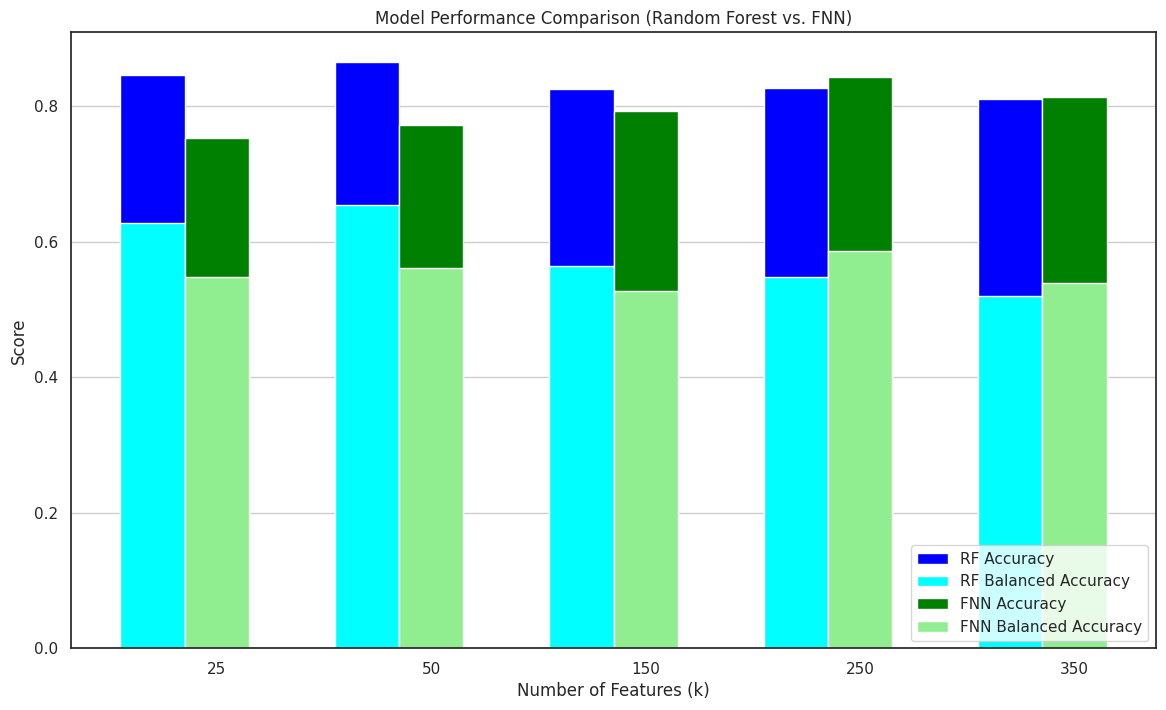

In [ ]:
#convert to df
results_df_combined = pd.DataFrame(accuracy_data_combined_c)

#get mean acc/bacc for rf across folds
avg_results_rf = results_df_combined[results_df_combined['model'] == 'Random Forest'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get mean acc/bacc for rf
avg_results_fnn = results_df_combined[results_df_combined['model'] == 'FNN'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get best mean acc/bacc results for rf
best_rf_acc_k = avg_results_rf.loc[avg_results_rf['accuracy'].idxmax(), 'k']
best_rf_bacc_k = avg_results_rf.loc[avg_results_rf['balanced_accuracy'].idxmax(), 'k']
best_rf_accuracy = avg_results_rf.loc[avg_results_rf['accuracy'].idxmax()]
best_rf_balanced_accuracy = avg_results_rf.loc[avg_results_rf['balanced_accuracy'].idxmax()]
best_rf_features_all_c = results_df_combined[(results_df_combined['model'] == 'Random Forest') & (results_df_combined['k'] == best_rf_acc_k)]['important features'].iloc[0]

#get best mean acc/bacc results for fnn
best_fnn_acc_k = avg_results_fnn.loc[avg_results_fnn['accuracy'].idxmax(), 'k']
best_fnn_bacc_k = avg_results_fnn.loc[avg_results_fnn['balanced_accuracy'].idxmax(), 'k']
best_fnn_accuracy = avg_results_fnn.loc[avg_results_fnn['accuracy'].idxmax()]
best_fnn_balanced_accuracy = avg_results_fnn.loc[avg_results_fnn['balanced_accuracy'].idxmax()]
best_fnn_features_all_c = results_df_combined[(results_df_combined['model'] == 'FNN') &  (results_df_combined['k'] == best_fnn_acc_k)]['important features'].iloc[0]

#top 20 deterministic features
best_rf_features_c = best_rf_features_all_c[:20]
best_fnn_features_c = best_fnn_features_all_c[:20]

#show best results
print("---------- Best Results ----------")
print(f"Random Forest Features: {best_rf_acc_k} (Accuracy) | {best_rf_bacc_k} (Balanced Accuracy)")
print(f"\tMean ACC: {best_rf_accuracy['accuracy']:.4f} | Mean BACC: {best_rf_balanced_accuracy['balanced_accuracy']:.4f}")
print(f"\nFNN Features: {best_fnn_acc_k} (Accuracy) | {best_fnn_bacc_k} (Balanced Accuracy)")
print(f"\tMean ACC: {best_fnn_accuracy['accuracy']:.4f} | Mean BACC: {best_fnn_balanced_accuracy['balanced_accuracy']:.4f}")
print("\n---------- Best Model Deterministic Features ----------")
print(f"Best RF Features (k={best_rf_bacc_k}):")
print(best_rf_features_c)
print(f"\nBest FNN Features (k={best_fnn_bacc_k}):")
print(best_fnn_features_c)

# plot bar graph
plt.figure(figsize=(14, 8))
bar_width = 0.3
x = np.arange(len(avg_results_rf['k']))

#rf bars
plt.bar(x - bar_width, avg_results_rf['accuracy'], width=bar_width, label='RF Accuracy', color='blue')
plt.bar(x - bar_width, avg_results_rf['balanced_accuracy'], width=bar_width, label='RF Balanced Accuracy', color='cyan')

#fnn bars
plt.bar(x, avg_results_fnn['accuracy'], width=bar_width, label='FNN Accuracy', color='green')
plt.bar(x, avg_results_fnn['balanced_accuracy'], width=bar_width, label='FNN Balanced Accuracy', color='lightgreen')

#labels
plt.xlabel('Number of Features (k)')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Random Forest vs. FNN)')
plt.xticks(x, avg_results_rf['k'])
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

---------- Best Results ----------
Random Forest Features: 50 (Accuracy) | 50 (Balanced Accuracy)
	Mean ACC: 0.8761 | Mean BACC: 0.7820

FNN Features: 50 (Accuracy) | 50 (Balanced Accuracy)
	Mean ACC: 0.8589 | Mean BACC: 0.7885

---------- Best Model Deterministic Features ----------
Best RF Features (k=50):
[(0.0430524416395746, '23'), (0.028244970765142107, '722'), (0.025405227714245016, 'having'), (0.023986340901732336, 'Answer Time'), (0.0206067237745402, '224'), (0.020532144568743374, 'Answer WC'), (0.019365218507119305, '741'), (0.019061817715227105, '205'), (0.018454530272181472, '302'), (0.01823244869975251, '667'), (0.017829820256257747, '411'), (0.017002585986950654, 'big'), (0.016448945689201508, '20.1'), (0.014765235743253056, '461'), (0.014745993630486018, '8'), (0.013265629241960276, '46'), (0.01284197566056494, '431'), (0.012218538378811263, '383'), (0.012013155523315538, '542'), (0.011428446127550462, '275')]

Best FNN Features (k=50):
[(52.80452, 'Answer Time'), (52.45

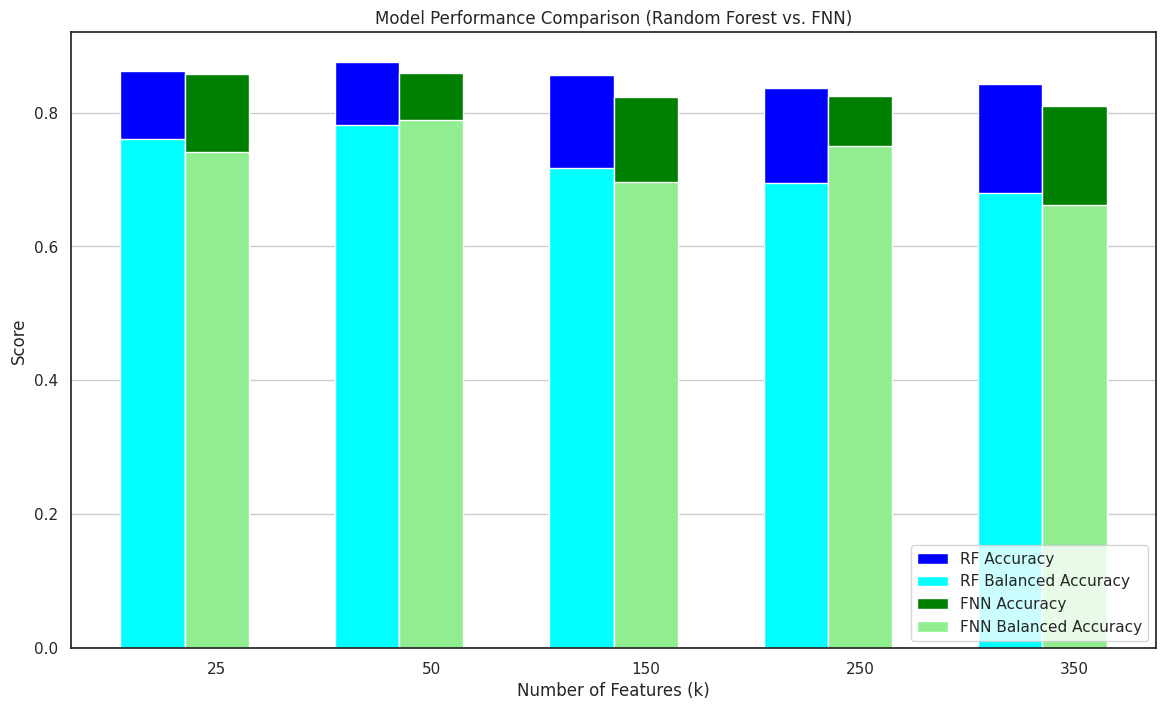

In [ ]:
#convert to df
results_df_combined_d = pd.DataFrame(accuracy_data_combined_d)

#get mean acc/bacc for rf across folds
avg_results_rf_d = results_df_combined_d[results_df_combined_d['model'] == 'Random Forest'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get mean acc/bacc for rf
avg_results_fnn_d = results_df_combined_d[results_df_combined_d['model'] == 'FNN'] \
    .groupby('k').agg({'accuracy': 'mean', 'balanced_accuracy': 'mean'}).reset_index()

#get best mean acc/bacc results
best_rf_acc_k_d = avg_results_rf_d.loc[avg_results_rf_d['accuracy'].idxmax(), 'k']
best_rf_bacc_k_d = avg_results_rf_d.loc[avg_results_rf_d['balanced_accuracy'].idxmax(), 'k']
best_rf_accuracy_d = avg_results_rf_d.loc[avg_results_rf_d['accuracy'].idxmax()]
best_rf_balanced_accuracy_d = avg_results_rf_d.loc[avg_results_rf_d['balanced_accuracy'].idxmax()]
best_rf_features_all_d = results_df_combined_d[(results_df_combined_d['model'] == 'Random Forest') & (results_df_combined_d['k'] == best_rf_acc_k_d)]['important features'].iloc[0]

#get best mean acc/bacc results for fnn
best_fnn_acc_k_d = avg_results_fnn_d.loc[avg_results_fnn_d['accuracy'].idxmax(), 'k']
best_fnn_bacc_k_d = avg_results_fnn_d.loc[avg_results_fnn_d['balanced_accuracy'].idxmax(), 'k']
best_fnn_accuracy_d = avg_results_fnn_d.loc[avg_results_fnn_d['accuracy'].idxmax()]
best_fnn_balanced_accuracy_d = avg_results_fnn_d.loc[avg_results_fnn_d['balanced_accuracy'].idxmax()]
best_fnn_features_all_d = results_df_combined_d[(results_df_combined_d['model'] == 'FNN') &  (results_df_combined_d['k'] == best_fnn_acc_k_d)]['important features'].iloc[0]

#show best results
print("---------- Best Results ----------")
print(f"Random Forest Features: {best_rf_acc_k_d} (Accuracy) | {best_rf_bacc_k_d} (Balanced Accuracy)")
print(f"\tMean ACC: {best_rf_accuracy_d['accuracy']:.4f} | Mean BACC: {best_rf_balanced_accuracy_d['balanced_accuracy']:.4f}")
print(f"\nFNN Features: {best_fnn_acc_k_d} (Accuracy) | {best_fnn_bacc_k_d} (Balanced Accuracy)")
print(f"\tMean ACC: {best_fnn_accuracy_d['accuracy']:.4f} | Mean BACC: {best_fnn_balanced_accuracy_d['balanced_accuracy']:.4f}")
print("\n---------- Best Model Deterministic Features ----------")
print(f"Best RF Features (k={best_rf_bacc_k_d}):")
print(best_rf_features_d)
print(f"\nBest FNN Features (k={best_fnn_bacc_k_d}):")
print(best_fnn_features_d)


# plot bar graph
plt.figure(figsize=(14, 8))
bar_width = 0.3
x = np.arange(len(avg_results_rf_d['k']))

#rf bars
plt.bar(x - bar_width, avg_results_rf_d['accuracy'], width=bar_width, label='RF Accuracy', color='blue')
plt.bar(x - bar_width, avg_results_rf_d['balanced_accuracy'], width=bar_width, label='RF Balanced Accuracy', color='cyan')

#fnn bars
plt.bar(x, avg_results_fnn_d['accuracy'], width=bar_width, label='FNN Accuracy', color='green')
plt.bar(x, avg_results_fnn_d['balanced_accuracy'], width=bar_width, label='FNN Balanced Accuracy', color='lightgreen')

#labels
plt.xlabel('Number of Features (k)')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Random Forest vs. FNN)')
plt.xticks(x, avg_results_rf_d['k'])
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

###**Part F**

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
!pip install transformers torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2LMHeadModel
import torch
import pandas as pd
import numpy as np

In [ ]:
# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Set pad_token to eos_token to avoid padding error
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=4)

In [ ]:
labels = ['under-explained', 'succinct', 'comprehensive', 'over-explained']
df = combined_df

In [ ]:
def tokenize_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs


In [ ]:
def create_prompt(response):
    prompt = f"Classify the following response into one of four categories: under-explained, succinct, comprehensive, over-explained. Response: {response}"
    return prompt

In [ ]:
# Classify the degree of explanation for each response
predictions = []
for i, row in df.iterrows():
    # Create prompt
    prompt = create_prompt(row['Transcript'])

    # Tokenize prompt
    inputs = tokenize_input(prompt)

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        predictions.append(labels[predicted_class])

In [ ]:
# Install necessary libraries
!pip install transformers torch

# Import necessary libraries
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2LMHeadModel, Trainer, TrainingArguments
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
# Set pad_token to eos_token to avoid padding error
tokenizer.pad_token = tokenizer.eos_token

model = GPT2ForSequenceClassification.from_pretrained("distilgpt2", num_labels=4)
# Set the pad_token_id for the model configuration to avoid batch size > 1 issues
model.config.pad_token_id = tokenizer.pad_token_id

# Define the label names
labels = ['Under-explained', 'Succinct', 'Comprehensive', 'Over-explained']

# Load the dataset
# Assuming your data is in a CSV format with a 'Transcript' and 'Degree of Explanation' column
df = combined_df

# Prepare the dataset for training
class InterviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['Transcript']
        label = labels.index(self.dataframe.iloc[idx]['Degree of Explanation'])

        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize dataset and dataloader
max_length = 256  # Reduced sequence length to speed up training
train_dataset = InterviewDataset(df, tokenizer, max_length)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Reduced number of epochs to speed up training
    per_device_train_batch_size=2,  # Reduced batch size
    gradient_accumulation_steps=2,  # Accumulate gradients to mimic a larger batch size
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="no",
    fp16=True  # Enable mixed precision training to speed up training
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_gpt2')

# After training, proceed with classification and textual reasoning generation as before
# Function to tokenize input text
def tokenize_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)  # Use reduced max_length
    return inputs

# Sample prompt engineering function
def create_prompt(response):
    prompt = f"Classify the following response into one of four categories: under-explained, succinct, comprehensive, over-explained. Response: {response}"
    return prompt

# Classify the degree of explanation for each response
predictions = []
for i, row in df.iterrows():
    # Create prompt
    prompt = create_prompt(row['Transcript'])

    # Tokenize prompt
    inputs = tokenize_input(prompt)

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
        predictions.append(labels[predicted_class])

# Add predictions to the dataframe
df['Predicted_Class'] = predictions

# Load a language model for generating textual reasoning
lm_model = GPT2LMHeadModel.from_pretrained("distilgpt2")

# Function to split long text into manageable chunks
def split_text_into_chunks(text, chunk_size=1024):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Generate textual reasoning for each prediction
reasonings = []
for i, row in df.iterrows():
    # Create a reasoning prompt based on the classification
    reasoning_prompt = f"Explain why the response '{row['Transcript']}' is classified as {row['Predicted_Class']}."
    # Split the prompt into manageable chunks
    chunks = split_text_into_chunks(reasoning_prompt, chunk_size=1024)

    # Generate reasoning for each chunk
    reasoning = ""
    for chunk in chunks:
        input_ids = tokenizer.encode(chunk, return_tensors='pt', max_length=1024, truncation=True)

        # Generate reasoning with adjusted settings
        with torch.no_grad():
            generated_output = lm_model.generate(
                input_ids,
                max_new_tokens=50,  # Limit the number of new tokens generated
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id,
                attention_mask=(input_ids != tokenizer.pad_token_id)
            )
            reasoning += tokenizer.decode(generated_output[0], skip_special_tokens=True) + " "

    reasonings.append(reasoning.strip())

# Add reasonings to the dataframe
df['Textual_Reasoning'] = reasonings

# Save the results to a CSV file
df.to_csv('classification_with_reasoning.csv', index=False)

# Print a sample of the results
print(df[['Transcript', 'Predicted_Class', 'Textual_Reasoning']].head())

In [ ]:
pd.set_option('display.max_colwidth', None)  # Prevent truncation of text
print(df[['Transcript', 'Predicted_Class', 'Textual_Reasoning']].head())

In [ ]:
df.to_excel('classification_with_reasoning.xlsx', index=False)

In [ ]:
# Compare the ground truth labels with predicted labels
correct_predictions = df['Degree of Explanation'] == df['Predicted_Class']
accuracy = correct_predictions.sum() / len(df)

print(f"Model Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df['Degree of Explanation'], df['Predicted_Class'], labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(df['Degree of Explanation'], df['Predicted_Class'], output_dict=True, labels=labels)
precision_scores = [report[label]['precision'] for label in labels]
recall_scores = [report[label]['recall'] for label in labels]
f1_scores = [report[label]['f1-score'] for label in labels]

# Plot precision, recall, and f1-score for each class
plt.figure(figsize=(12, 6))
index = range(len(labels))
plt.bar(index, precision_scores, width=0.25, label='Precision', color='blue', alpha=0.6)
plt.bar([i + 0.25 for i in index], recall_scores, width=0.25, label='Recall', color='orange', alpha=0.6)
plt.bar([i + 0.5 for i in index], f1_scores, width=0.25, label='F1 Score', color='green', alpha=0.6)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks([i + 0.25 for i in index], labels)
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.legend()
plt.show()

In [ ]:
misclassified = df[df['Degree of Explanation'] != df['Predicted_Class']]
misclassified_counts = misclassified.groupby(['Degree of Explanation', 'Predicted_Class']).size().unstack().fillna(0)

misclassified_counts.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
plt.xlabel('True Label')
plt.ylabel('Count of Misclassified Samples')
plt.title('Misclassification Analysis by True and Predicted Classes')
plt.show()

In [ ]:
training_logs = trainer.state.log_history  # This assumes you used `Trainer` for training.
losses = [log['loss'] for log in training_logs if 'loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss', color='red')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()